# Description

The goal of this notebook is to practice using GPyTorch by replicating GP results on test datasets with 
1. standard SE GPs, 
2. SM GPs, 
3. SKI-GPs, and 
4. Additive GPs. 

Additive GPs require implementation of the Additive GP model, but this should not be too difficult.

Test datasets will include 
1. Boston Housing (standard regression benchmark with small N=506 and d=13)
2. Addition of Sines (synthetic dataset from Additive GP paper N=~20 and d=2)
3. Breast (standard classification benchmark with small N=569 and d=30)

In [1]:
import numpy as np
import os 
import sys
import matplotlib.pyplot as plt
import sklearn
import torch
import gpytorch
from scipy.io import loadmat

%matplotlib inline

In [2]:
from torch import tensor
from gpytorch.models import ExactGP
from gpytorch.kernels import Kernel, ScaleKernel, RBFKernel, GridInterpolationKernel

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.random_projection import GaussianRandomProjection
from sklearn.datasets import  fetch_kddcup99, make_friedman1, make_regression, fetch_openml, load_boston, load_breast_cancer

In [106]:
boston = load_boston()
bostonX = torch.FloatTensor(boston['data'])
bostonY = torch.FloatTensor(boston['target'])
bostonFeats = boston['feature_names']

In [117]:
bostonX.shape

torch.Size([506, 13])

In [118]:
sinesX = np.hstack([
    np.vstack([np.random.uniform(-2,-1.5, size=10),
               np.random.uniform(-2, 2, size=10)]),
    np.vstack([np.random.uniform(-2,2, size=10),
               np.random.uniform(-2, -1.5, size=10)])
]).T
sinesY = np.sin(sinesX[:, 0]*2+.5) + np.sin(sinesX[:,1]*2+0.5)

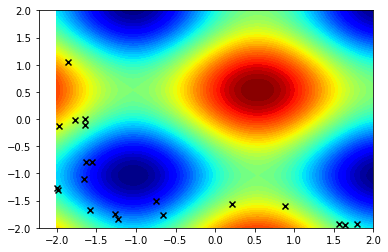

In [119]:
_x = _y = np.linspace(-2, 2, num=1000)
sinesMG = np.meshgrid(_x, _y)
z = np.sin(sinesMG[0]*2+0.5) + np.sin(sinesMG[1]*2.+0.5)
plt.contourf(sinesMG[0], sinesMG[1], z, 50, cmap='jet')
plt.scatter(sinesX[:, 0], sinesX[:,1], marker='x', c='k')

In [120]:
sinesX = torch.FloatTensor(sinesX)
sinesY = torch.FloatTensor(sinesY)

In [121]:
breast = load_breast_cancer()
breastX = torch.FloatTensor(breast['data'])
breastY = torch.FloatTensor(breast['target'])
breastFeats = breast['feature_names']

In [122]:
breastX.shape

torch.Size([569, 30])

In [123]:
airlineM = loadmat('./airlinedata (1).mat')
airlineX = airlineM['xtrain']
airlineY = airlineM['ytrain']
airlineXtest = airlineM['xtest']
airlineYtest = airlineM['ytest']

In [435]:
class ExactGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        train_x = torch.FloatTensor(train_x)
        train_y = torch.FloatTensor(train_y)
        
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel
    
    def forward(self, x):
        x = torch.FloatTensor(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [436]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
SE_model = ExactGPModel(bostonX[:400], bostonY[:400], likelihood, 
                       kernel=ScaleKernel(RBFKernel(ard_num_dims=13)))
SE_model.eval()
SE_unfit_pred = SE_model(torch.FloatTensor(bostonX[400:]))

In [437]:
likelihood.eval()

GaussianLikelihood()

In [444]:
mvn = likelihood(SE_model(bostonX[400:]))
-mvn.log_prob(bostonY[400:]).item()

10648.9873046875

In [132]:
# Go into eval mode
SE_model.train()
likelihood.train()

optimizer = torch.optim.Adam(SE_model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the amount of training data
mll = gpytorch.ExactMarginalLogLikelihood(likelihood, SE_model)

training_iter = 100
for i in range(training_iter):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = SE_model(bostonX[:400])
    # Calc loss and backprop gradients
    loss = -mll(output, bostonY[:400])
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 2.924
Iter 2/100 - Loss: 2.920
Iter 3/100 - Loss: 2.903
Iter 4/100 - Loss: 2.896
Iter 5/100 - Loss: 2.885
Iter 6/100 - Loss: 2.889
Iter 7/100 - Loss: 2.872
Iter 8/100 - Loss: 2.888
Iter 9/100 - Loss: 2.873
Iter 10/100 - Loss: 2.891
Iter 11/100 - Loss: 2.865
Iter 12/100 - Loss: 2.883
Iter 13/100 - Loss: 2.878
Iter 14/100 - Loss: 2.884
Iter 15/100 - Loss: 2.861
Iter 16/100 - Loss: 2.875
Iter 17/100 - Loss: 2.876
Iter 18/100 - Loss: 2.863
Iter 19/100 - Loss: 2.859
Iter 20/100 - Loss: 2.862
Iter 21/100 - Loss: 2.844
Iter 22/100 - Loss: 2.838
Iter 23/100 - Loss: 2.831
Iter 24/100 - Loss: 2.854
Iter 25/100 - Loss: 2.835
Iter 26/100 - Loss: 2.826
Iter 27/100 - Loss: 2.846
Iter 28/100 - Loss: 2.829
Iter 29/100 - Loss: 2.828
Iter 30/100 - Loss: 2.840
Iter 31/100 - Loss: 2.839
Iter 32/100 - Loss: 2.813
Iter 33/100 - Loss: 2.807
Iter 34/100 - Loss: 2.812
Iter 35/100 - Loss: 2.821
Iter 36/100 - Loss: 2.822
Iter 37/100 - Loss: 2.803
Iter 38/100 - Loss: 2.800
Iter 39/100 - Loss: 2

In [136]:
SE_model.eval()
likelihood.eval()
SE_fit_pred = SE_model(bostonX[400:])
SE_fit_pred.mean

tensor([ 9.3794, 10.3302, 15.6194, 11.1963, 14.3626, 15.1207, 18.7652, 39.8639,
        17.0207, 23.5774, 23.5876, 23.5872, 23.5874, 23.2875, 23.5859, 23.5875,
        23.5876, 23.5392, 23.5876, 23.5872, 24.5492, 23.1149, 25.3862, 23.5876,
        23.5875, 23.5876, 23.5872, 23.5875, 23.5690, 23.5851, 23.5734, 23.5824,
        23.5688, 23.5690, 23.5569, 23.5794, 23.5874, 23.5876, 23.5869, 12.7545,
        12.2414, 15.4389, 14.4746, 14.9961, 21.5751, 23.5872, 19.0639, 16.0394,
        11.7378, 19.5277, 23.5876, 22.4306, 18.4567, 18.4905, 23.5876, 23.5862,
        23.5875, 23.5876, 21.9679, 18.9077, 22.9584, 20.3460, 20.0563, 25.6732,
        26.6917, 30.7687, 23.5872, 24.7637, 30.1992, 26.8935, 24.1644, 30.4813,
        28.5684, 34.8837, 32.3795, 20.3706, 17.5227, 17.4660, 23.3973, 32.9636,
        30.5663, 35.6017, 35.4547, 27.3007, 31.2105, 31.8276, 27.9354, 32.1201,
        22.8805, 22.8368, 21.6571, 22.9101, 24.7735, 21.2188, 21.9450, 21.9951,
        20.2227, 20.4257, 21.7092, 19.84

In [137]:
((SE_fit_pred.mean - bostonY[400:])**2).mean()

tensor(77.5886, grad_fn=<MeanBackward1>)

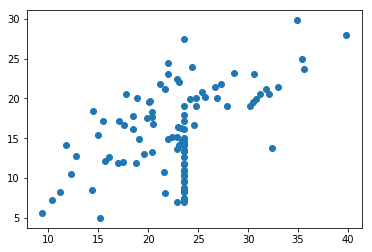

In [141]:
plt.scatter(SE_fit_pred.mean.detach().numpy(), bostonY[400:].numpy())

In [142]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


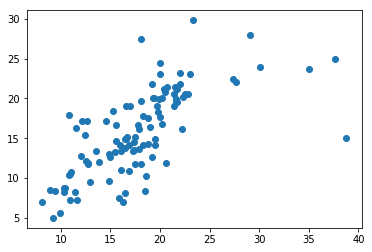

In [143]:
rf = RandomForestRegressor()
rf.fit(bostonX[:400].numpy(),
       bostonY[:400].numpy())
rf_pred = rf.predict(bostonX[400:].numpy())
plt.scatter(rf_pred, bostonY[400:].numpy())

In [144]:
((rf_pred - bostonY[400:].numpy())**2).mean()

22.36819978880272

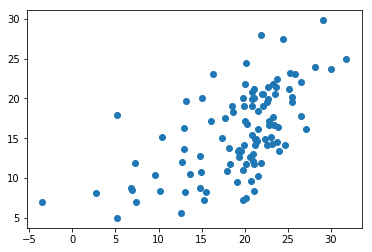

In [145]:
lr = LinearRegression()
lr.fit(bostonX[:400].numpy(),
       bostonY[:400].numpy())
lr_pred = lr.predict(bostonX[400:].numpy())
plt.scatter(lr_pred, bostonY[400:].numpy())

In [146]:
((lr_pred - bostonY[400:].numpy())**2).mean()

37.89387

In [147]:
from gpytorch.kernels import AdditiveKernel, AdditiveStructureKernel

In [151]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
AGP_model = ExactGPModel(bostonX[:400], bostonY[:400], likelihood, 
                       kernel=ScaleKernel(AdditiveStructureKernel(RBFKernel(), 13)))
AGP_model.eval()
AGP_unfit_pred = AGP_model(torch.FloatTensor(bostonX[400:]))

In [152]:
# Go into eval mode
AGP_model.train()
likelihood.train()

optimizer = torch.optim.Adam(AGP_model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the amount of training data
mll = gpytorch.ExactMarginalLogLikelihood(likelihood, AGP_model)

training_iter = 100
for i in range(training_iter):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = AGP_model(bostonX[:400])
    # Calc loss and backprop gradients
    loss = -mll(output, bostonY[:400])
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 6.904
Iter 2/100 - Loss: 6.506
Iter 3/100 - Loss: 6.146
Iter 4/100 - Loss: 5.863
Iter 5/100 - Loss: 5.578
Iter 6/100 - Loss: 5.354
Iter 7/100 - Loss: 5.141
Iter 8/100 - Loss: 4.946
Iter 9/100 - Loss: 4.787
Iter 10/100 - Loss: 4.636
Iter 11/100 - Loss: 4.501
Iter 12/100 - Loss: 4.384
Iter 13/100 - Loss: 4.319
Iter 14/100 - Loss: 4.221
Iter 15/100 - Loss: 4.133
Iter 16/100 - Loss: 4.079
Iter 17/100 - Loss: 4.021
Iter 18/100 - Loss: 3.962
Iter 19/100 - Loss: 3.933
Iter 20/100 - Loss: 3.888
Iter 21/100 - Loss: 3.840
Iter 22/100 - Loss: 3.804
Iter 23/100 - Loss: 3.769
Iter 24/100 - Loss: 3.748
Iter 25/100 - Loss: 3.710
Iter 26/100 - Loss: 3.682
Iter 27/100 - Loss: 3.660
Iter 28/100 - Loss: 3.632
Iter 29/100 - Loss: 3.613
Iter 30/100 - Loss: 3.601
Iter 31/100 - Loss: 3.554
Iter 32/100 - Loss: 3.556
Iter 33/100 - Loss: 3.554
Iter 34/100 - Loss: 3.526
Iter 35/100 - Loss: 3.504
Iter 36/100 - Loss: 3.475
Iter 37/100 - Loss: 3.485
Iter 38/100 - Loss: 3.473
Iter 39/100 - Loss: 3

In [153]:
AGP_model.eval()
likelihood.eval()
AGP_fit_pred = AGP_model(bostonX[400:])
AGP_fit_pred.mean

tensor([ 7.8555,  8.7282, 12.9529,  9.6916, 11.0755, 14.5148, 18.0006, 18.0716,
        15.2729, 18.0327, 19.5550, 15.8997, 10.0749, 12.4962, 13.9026,  8.9114,
        17.1384, 12.8052, 10.0009, 13.1471, 10.6620, 17.3558, 14.1306, 16.6623,
        19.2602, 11.7279, 15.8409, 13.2339, 12.1808, 16.5079, 17.6181, 13.9206,
        23.9585, 20.1836, 16.0882,  9.2202, 12.2938,  8.5252, 12.2940, 11.2979,
         6.0960, 13.5742, 15.2364, 13.3317, 14.3192,  7.6870, 21.6310, 15.2520,
        16.5050, 15.2885, 20.2353, 21.0744, 23.4910, 31.7036, 19.8482, 23.6576,
        22.6534, 21.6986, 16.2044, 16.6136, 28.2627, 12.8557, 18.2114, 22.6899,
        17.8672, 13.4117, 15.1613, 18.4627, 16.7069, 14.4303, 18.1081, 23.9223,
        16.9656, 33.1828, 22.4702, 20.3938, 24.8797, 14.4196, 16.3722, 14.8971,
        21.0152, 27.3114, 28.7738, 13.3293, 14.9573, 16.6483, 20.1965, 27.4391,
        12.9622, 10.9007, 13.4018, 13.0222, 14.0223, 16.2295, 16.3494, 15.5709,
        14.4523, 16.8920, 18.7822, 15.73

28.249012


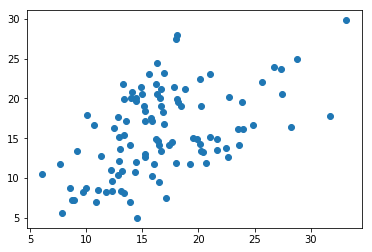

In [154]:
print(((AGP_fit_pred.mean.detach().numpy() - bostonY[400:].numpy())**2).mean())
plt.scatter(AGP_fit_pred.mean.detach().numpy(), bostonY[400:].numpy())

New dataset - just working on the Sin functions now

In [161]:
def fit_gp_model(gp_model, gp_likelihood, xs, ys, lr=0.1, gp_mll=None, training_iter=100):
    if gp_mll is None:
        gp_mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)
    
    gp_model.train()
    gp_likelihood.train()

    optimizer = torch.optim.Adam(gp_model.parameters(), lr=lr)

    # "Loss" for GPs - the marginal log likelihood
    # num_data refers to the amount of training data

    for i in range(training_iter):
        # Zero backpropped gradients from previous iteration
        optimizer.zero_grad()
        # Get predictive output
        output = gp_model(xs)
        # Calc loss and backprop gradients
        loss = -gp_mll(output, ys)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
        optimizer.step()

In [163]:
l = gpytorch.likelihoods.GaussianLikelihood()
SE_model = ExactGPModel(sinesX, sinesY, likelihood=l, kernel=ScaleKernel(RBFKernel(ard_num_dims=2)))
l2 = gpytorch.likelihoods.GaussianLikelihood()
AGP_model = ExactGPModel(sinesX, sinesY, likelihood=l,
                        kernel=ScaleKernel(AdditiveStructureKernel(RBFKernel(), 2)))
rf_model = RandomForestRegressor()
rf_model.fit(sinesX.numpy(), sinesY.numpy())
lr_model = LinearRegression()
lr_model.fit(sinesX.numpy(), sinesY.numpy())

/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [164]:
fit_gp_model(SE_model, l, sinesX, sinesY)
fit_gp_model(AGP_model, l2, sinesX, sinesY)

Iter 1/100 - Loss: 1.643
Iter 2/100 - Loss: 1.635
Iter 3/100 - Loss: 1.628
Iter 4/100 - Loss: 1.619
Iter 5/100 - Loss: 1.610
Iter 6/100 - Loss: 1.620
Iter 7/100 - Loss: 1.614
Iter 8/100 - Loss: 1.612
Iter 9/100 - Loss: 1.606
Iter 10/100 - Loss: 1.604
Iter 11/100 - Loss: 1.604
Iter 12/100 - Loss: 1.600
Iter 13/100 - Loss: 1.598
Iter 14/100 - Loss: 1.597
Iter 15/100 - Loss: 1.594
Iter 16/100 - Loss: 1.593
Iter 17/100 - Loss: 1.592
Iter 18/100 - Loss: 1.591
Iter 19/100 - Loss: 1.591
Iter 20/100 - Loss: 1.589
Iter 21/100 - Loss: 1.590
Iter 22/100 - Loss: 1.587
Iter 23/100 - Loss: 1.586
Iter 24/100 - Loss: 1.585
Iter 25/100 - Loss: 1.585
Iter 26/100 - Loss: 1.584
Iter 27/100 - Loss: 1.584
Iter 28/100 - Loss: 1.583
Iter 29/100 - Loss: 1.582
Iter 30/100 - Loss: 1.582
Iter 31/100 - Loss: 1.581
Iter 32/100 - Loss: 1.581
Iter 33/100 - Loss: 1.580
Iter 34/100 - Loss: 1.580
Iter 35/100 - Loss: 1.580
Iter 36/100 - Loss: 1.580
Iter 37/100 - Loss: 1.579
Iter 38/100 - Loss: 1.579
Iter 39/100 - Loss: 1

In [176]:
sinesMGflat = np.vstack([sinesMG[0].flatten(), sinesMG[1].flatten()]).T
sinesMGflat.shape

(1000000, 2)

In [182]:
rf_pred = rf_model.predict(sinesMGflat)
lr_pred = lr_model.predict(sinesMGflat)
SE_model.eval()
AGP_model.eval()
SE_pred = SE_model(torch.FloatTensor(sinesMGflat)).mean.detach().numpy()
AGP_pred = AGP_model(torch.FloatTensor(sinesMGflat)).mean.detach().numpy()

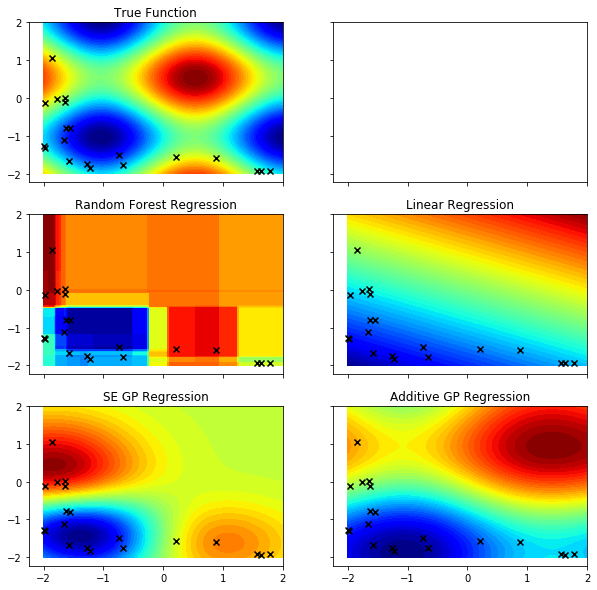

In [200]:
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=[10,10])
ax[0,0].contourf(sinesMG[0], sinesMG[1], z, 50, cmap='jet')
ax[0,0].scatter(sinesX[:, 0], sinesX[:,1], marker='x', c='k')
ax[0,0].set_title('True Function')

ax[1,0].contourf(sinesMG[0], sinesMG[1], rf_pred.reshape(1000,1000), 50, cmap='jet')
ax[1,0].scatter(sinesX[:, 0], sinesX[:,1], marker='x', c='k')
ax[1,0].set_title('Random Forest Regression')

ax[1,1].contourf(sinesMG[0], sinesMG[1], lr_pred.reshape(1000,1000), 50, cmap='jet')
ax[1,1].scatter(sinesX[:, 0], sinesX[:,1], marker='x', c='k')
ax[1,1].set_title('Linear Regression')

ax[2,0].contourf(sinesMG[0], sinesMG[1], SE_pred.reshape(1000,1000), 50, cmap='jet')
ax[2,0].scatter(sinesX[:, 0], sinesX[:,1], marker='x', c='k')
ax[2,0].set_title('SE GP Regression')

ax[2,1].contourf(sinesMG[0], sinesMG[1], AGP_pred.reshape(1000,1000), 50, cmap='jet')
ax[2,1].scatter(sinesX[:, 0], sinesX[:,1], marker='x', c='k')
ax[2,1].set_title('Additive GP Regression')
plt.show()

# New task: classification. Now using variational inference. The one where u is integrated out.


In [202]:
from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

In [204]:
class GPClassificationModel(AbstractVariationalGP,):
    def __init__(self, train_x, kernel):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(self, train_x, variational_distribution)
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

In [205]:
breastX.shape

torch.Size([569, 30])

In [206]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [207]:
l = gpytorch.likelihoods.BernoulliLikelihood()
SE_model = GPClassificationModel(breastX[:400], 
                                 kernel=ScaleKernel(RBFKernel(ard_num_dims=30)))
l2 = gpytorch.likelihoods.BernoulliLikelihood()
AGP_model = GPClassificationModel(breastX[:400],
                                  kernel=ScaleKernel(AdditiveStructureKernel(RBFKernel(), 2)))
rf_model = RandomForestClassifier()
rf_model.fit(breastX[:400].numpy(), breastY[:400].numpy())
lr_model = LogisticRegression()
lr_model.fit(breastX[:400], breastY[:400].numpy())

/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [208]:
fit_gp_model(SE_model, l, breastX[:400], breastY[:400], gp_mll=gpytorch.mlls.VariationalELBO(l, SE_model, 400))
fit_gp_model(AGP_model, l2, breastX[:400], breastY[:400], gp_mll=gpytorch.mlls.VariationalELBO(l2, AGP_model, 400))

Iter 1/100 - Loss: 0.829
Iter 2/100 - Loss: 2.288
Iter 3/100 - Loss: 2.699
Iter 4/100 - Loss: 2.826
Iter 5/100 - Loss: 3.181
Iter 6/100 - Loss: 2.366
Iter 7/100 - Loss: 2.588
Iter 8/100 - Loss: 2.376
Iter 9/100 - Loss: 2.555
Iter 10/100 - Loss: 2.697
Iter 11/100 - Loss: 2.231
Iter 12/100 - Loss: 2.107
Iter 13/100 - Loss: 1.948
Iter 14/100 - Loss: 2.203
Iter 15/100 - Loss: 2.000
Iter 16/100 - Loss: 1.822
Iter 17/100 - Loss: 1.819
Iter 18/100 - Loss: 2.081
Iter 19/100 - Loss: 1.636
Iter 20/100 - Loss: 1.716
Iter 21/100 - Loss: 1.887
Iter 22/100 - Loss: 1.970
Iter 23/100 - Loss: 1.590
Iter 24/100 - Loss: 1.723
Iter 25/100 - Loss: 1.817
Iter 26/100 - Loss: 2.065
Iter 27/100 - Loss: 1.638
Iter 28/100 - Loss: 1.339
Iter 29/100 - Loss: 1.305
Iter 30/100 - Loss: 1.389
Iter 31/100 - Loss: 1.213
Iter 32/100 - Loss: 1.443
Iter 33/100 - Loss: 1.731
Iter 34/100 - Loss: 1.243
Iter 35/100 - Loss: 1.294
Iter 36/100 - Loss: 1.174
Iter 37/100 - Loss: 1.329
Iter 38/100 - Loss: 1.079
Iter 39/100 - Loss: 1

In [210]:
SE_model

GPClassificationModel(
  (variational_strategy): VariationalStrategy(
    (variational_distribution): CholeskyVariationalDistribution()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel()
  )
)

In [211]:
AGP_model

GPClassificationModel(
  (variational_strategy): VariationalStrategy(
    (variational_distribution): CholeskyVariationalDistribution()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): AdditiveStructureKernel(
      (base_kernel): RBFKernel()
    )
  )
)

In [221]:
y = breastY[400:].numpy()
rf_pred = rf_model.predict(breastX[400:].numpy())
lr_pred = lr_model.predict(breastX[400:].numpy())
SE_model.eval()
l.eval()
AGP_model.eval()
l2.eval()
SE_pred = l(SE_model(breastX[400:])).mean.detach().numpy() >= 0.5
# AGP_pred = AGP_model(breastX[400:]).mean.detach().numpy()

print('{:15s} {:15s}'.format('Model Type', 'Accuracy'))
print('{:15s} {:1.4f}'.format('Random Forest', np.abs(y==rf_pred).mean()))
print('{:15s} {:1.4f}'.format('Log. Regression', np.abs(y==lr_pred).mean()))
print('{:15s} {:1.4f}'.format('RBF GP', np.abs(y==SE_pred).mean()))
# print('{:15s} {:15s}'.format('Additive GP', np.abs(y-AGP_pred).mean()))

Model Type      Accuracy       
Random Forest   0.9527
Log. Regression 0.9467
RBF GP          0.7692


In [233]:
breastX.shape

torch.Size([569, 30])

In [319]:
import rp
import imp
imp.reload(rp)

<module 'rp' from '/home/ian/Documents/Research/Scalable_GPs/rp.py'>

In [320]:
# regular RP
W = rp.gen_rp(30, 5, dist='gaussian')
breastRP = breastX.matmul(W)

In [388]:
A = rp.gen_rp(30, 200, dist='gaussian')
b = rp.gen_rp(1, 200, dist='gaussian')
breastELMsigmoid = rp.Sigmoid(A, b, breastX)
breastELMgaussian = rp.Gaussian(A, b, breastX)
breastELMfourier = rp.Fourier(A, b, breastX)
breastELMhard_limit = rp.Hard_limit(A, b, breastX)

In [389]:
class LogisticRegressionModel(torch.nn.Module):

    def __init__(self, input_dim, output_dim):

        super(LogisticRegressionModel, self).__init__() 
        # Calling Super Class's constructor
        self.linear = torch.nn.Linear(input_dim, output_dim)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        # Here the forward pass is simply a linear function
        out = self.sigmoid(self.linear(x))
        return out

In [401]:
def torch_lr(X, y, Xtest, epochs=30000, verbose=True, lr=0.1):
    [n,d] = X.shape
    model = LogisticRegressionModel(d,1)
    criterion = torch.nn.BCELoss()
    optimiser = torch.optim.SGD(model.parameters(), lr=lr) #Stochastic Gradient Descent
    epochs = epochs
    
    for epoch in range(epochs):
        #clear grads as discussed in prev post
        optimiser.zero_grad()
        #forward to get predicted values
        outputs = model.forward(X)
        loss = criterion(outputs, y)
        loss.backward()# back props
        optimiser.step()# update the parameters
        if verbose or epoch==epochs-1:
            print('epoch {}, loss {}'.format(epoch+1,loss.item()))
    optimiser.zero_grad()
    with torch.no_grad():
        y_pred = model(X)
        y_pred_test = model(Xtest)
        
    return model, y_pred, y_pred_test

In [328]:
[_, rp_pred, rp_test_pred] = torch_lr(breastRP[:400], breastY[:400].unsqueeze(1), breastRP[400:], lr=0.0001)

epoch 1, loss 11.829080581665039
epoch 2, loss 11.829082489013672
epoch 3, loss 11.829082489013672
epoch 4, loss 11.829082489013672
epoch 5, loss 11.829083442687988
epoch 6, loss 11.828068733215332
epoch 7, loss 11.828069686889648
epoch 8, loss 11.827353477478027
epoch 9, loss 11.827353477478027
epoch 10, loss 11.827354431152344
epoch 11, loss 11.827354431152344
epoch 12, loss 11.827356338500977
epoch 13, loss 11.827356338500977
epoch 14, loss 11.826079368591309
epoch 15, loss 11.824346542358398
epoch 16, loss 11.824348449707031
epoch 17, loss 11.824349403381348
epoch 18, loss 11.822615623474121
epoch 19, loss 11.822160720825195
epoch 20, loss 11.821602821350098
epoch 21, loss 11.821603775024414
epoch 22, loss 11.821606636047363
epoch 23, loss 11.821223258972168
epoch 24, loss 11.821223258972168
epoch 25, loss 11.791547775268555
epoch 26, loss 11.790201187133789
epoch 27, loss 11.78918743133545
epoch 28, loss 11.788804054260254
epoch 29, loss 11.7885103225708
epoch 30, loss 11.78851222

In [341]:
train_err_rp = torch.mean(((rp_pred > 0.5).squeeze().float() - breastY[:400])**2)
test_err_rp = torch.mean(((rp_test_pred > 0.5).squeeze().float() - breastY[400:])**2)
print("Train Error {:2.3f}, Test Error {:2.3f} (Random Projections + Logistic Regression)".format(train_err_rp, test_err_rp))

Train Error 0.153, Test Error 0.195 (Random Projections + Logistic Regression)


In [359]:
def train_routine(X, Y, Xtest, Ytest, method):
    [_, pred, test_pred] = torch_lr(X, Y.unsqueeze(1), Xtest, lr=0.0001, verbose=False)
    train_err = torch.mean(((pred > 0.5).squeeze().float() - Y)**2)
    test_err = torch.mean(((test_pred > 0.5).squeeze().float() - Ytest)**2)
    print("Train Error {:2.3f}, Test Error {:2.3f} ({})".format(train_err, test_err, method))

In [404]:
train_routine(breastRP[:400], breastY[:400], breastRP[400:], breastY[400:], 'RP + Logistic Regression')

epoch 30000, loss 11.950418472290039
Train Error 0.433, Test Error 0.231 (RP + Logistic Regression)


In [405]:
train_routine(breastELMsigmoid[:400], breastY[:400], breastELMsigmoid[400:], breastY[400:], 'Sigmoid ELM + Logistic Regression')

epoch 30000, loss 0.22053208947181702
Train Error 0.083, Test Error 0.083 (Sigmoid ELM + Logistic Regression)


In [406]:
train_routine(breastELMfourier[:400], breastY[:400], breastELMfourier[400:], breastY[400:], 'Cosine ELM + Logistic Regression')

epoch 30000, loss 0.15825466811656952
Train Error 0.000, Test Error 0.450 (Cosine ELM + Logistic Regression)


In [411]:
breastELMgaussian = breastELMgaussian.squeeze()

In [416]:
train_routine(breastELMgaussian[:400], breastY[:400], breastELMgaussian[400:], breastY[400:], 'Gaussian ELM + Logistic Regression')

epoch 30000, loss 11.950418472290039
Train Error 0.433, Test Error 0.231 (Gaussian ELM + Logistic Regression)


In [415]:
train_routine(breastELMhard_limit[:400], breastY[:400], breastELMhard_limit[400:], breastY[400:], 'Hard Limit ELM + Logistic Regression')

epoch 30000, loss 0.21974597871303558
Train Error 0.085, Test Error 0.083 (Hard Limit ELM + Logistic Regression)


In [420]:
train_routine(breastX[:400], breastY[:400], breastX[400:], breastY[400:], 'Just Logistic Regression')

epoch 30000, loss 0.39064690470695496
Train Error 0.093, Test Error 0.059 (Just Logistic Regression)


In [ ]:
fit_gp_model(AGP_model, l2, breastX[:400], breastY[:400], gp_mll=gpytorch.mlls.VariationalELBO(l2, AGP_model, 400))

In [423]:
AGP_model = GPClassificationModel(breastRP[:400],
                                  kernel=ScaleKernel(AdditiveStructureKernel(RBFKernel(), 2)))

In [424]:
gpytorch.mlls.VariationalMarginalLogLikelihood?

In [425]:
gpytorch.mlls.VariationalELBOEmpirical?

In [426]:
gpytorch.mlls.VariationalELBO?

In [430]:
fit_gp_model(AGP_model, l2, breastRP[:400], breastY[:400], lr=0.01, gp_mll=gpytorch.mlls.VariationalELBO(l2, AGP_model, 400), training_iter=1000)

Iter 1/1000 - Loss: 4.257
Iter 2/1000 - Loss: 2.636
Iter 3/1000 - Loss: 2.592
Iter 4/1000 - Loss: 1.799
Iter 5/1000 - Loss: 2.488
Iter 6/1000 - Loss: 2.473
Iter 7/1000 - Loss: 2.528
Iter 8/1000 - Loss: 2.109
Iter 9/1000 - Loss: 2.886
Iter 10/1000 - Loss: 3.688
Iter 11/1000 - Loss: 1.798
Iter 12/1000 - Loss: 1.873
Iter 13/1000 - Loss: 2.915
Iter 14/1000 - Loss: 3.314
Iter 15/1000 - Loss: 3.303
Iter 16/1000 - Loss: 2.989
Iter 17/1000 - Loss: 2.349
Iter 18/1000 - Loss: 1.798
Iter 19/1000 - Loss: 3.360
Iter 20/1000 - Loss: 2.353
Iter 21/1000 - Loss: 2.846
Iter 22/1000 - Loss: 3.636
Iter 23/1000 - Loss: 3.204
Iter 24/1000 - Loss: 3.115
Iter 25/1000 - Loss: 2.422
Iter 26/1000 - Loss: 2.889
Iter 27/1000 - Loss: 2.075
Iter 28/1000 - Loss: 2.055
Iter 29/1000 - Loss: 2.234
Iter 30/1000 - Loss: 1.820
Iter 31/1000 - Loss: 2.371
Iter 32/1000 - Loss: 3.995
Iter 33/1000 - Loss: 2.281
Iter 34/1000 - Loss: 3.645
Iter 35/1000 - Loss: 1.826
Iter 36/1000 - Loss: 1.949
Iter 37/1000 - Loss: 1.782
Iter 38/10

Iter 298/1000 - Loss: 0.475
Iter 299/1000 - Loss: 0.545
Iter 300/1000 - Loss: 0.473
Iter 301/1000 - Loss: 0.468
Iter 302/1000 - Loss: 0.476
Iter 303/1000 - Loss: 0.522
Iter 304/1000 - Loss: 0.485
Iter 305/1000 - Loss: 0.499
Iter 306/1000 - Loss: 0.491
Iter 307/1000 - Loss: 0.472
Iter 308/1000 - Loss: 0.436
Iter 309/1000 - Loss: 0.550
Iter 310/1000 - Loss: 0.472
Iter 311/1000 - Loss: 0.491
Iter 312/1000 - Loss: 0.431
Iter 313/1000 - Loss: 0.465
Iter 314/1000 - Loss: 0.474
Iter 315/1000 - Loss: 0.458
Iter 316/1000 - Loss: 0.450
Iter 317/1000 - Loss: 0.460
Iter 318/1000 - Loss: 0.473
Iter 319/1000 - Loss: 0.459
Iter 320/1000 - Loss: 0.461
Iter 321/1000 - Loss: 0.457
Iter 322/1000 - Loss: 0.495
Iter 323/1000 - Loss: 0.440
Iter 324/1000 - Loss: 0.434
Iter 325/1000 - Loss: 0.479
Iter 326/1000 - Loss: 0.443
Iter 327/1000 - Loss: 0.431
Iter 328/1000 - Loss: 0.454
Iter 329/1000 - Loss: 0.461
Iter 330/1000 - Loss: 0.441
Iter 331/1000 - Loss: 0.455
Iter 332/1000 - Loss: 0.446
Iter 333/1000 - Loss

Iter 591/1000 - Loss: 0.366
Iter 592/1000 - Loss: 0.364
Iter 593/1000 - Loss: 0.368
Iter 594/1000 - Loss: 0.369
Iter 595/1000 - Loss: 0.374
Iter 596/1000 - Loss: 0.370
Iter 597/1000 - Loss: 0.351
Iter 598/1000 - Loss: 0.366
Iter 599/1000 - Loss: 0.364
Iter 600/1000 - Loss: 0.362
Iter 601/1000 - Loss: 0.370
Iter 602/1000 - Loss: 0.356
Iter 603/1000 - Loss: 0.367
Iter 604/1000 - Loss: 0.353
Iter 605/1000 - Loss: 0.349
Iter 606/1000 - Loss: 0.349
Iter 607/1000 - Loss: 0.352
Iter 608/1000 - Loss: 0.349
Iter 609/1000 - Loss: 0.356
Iter 610/1000 - Loss: 0.359
Iter 611/1000 - Loss: 0.371
Iter 612/1000 - Loss: 0.349
Iter 613/1000 - Loss: 0.356
Iter 614/1000 - Loss: 0.359
Iter 615/1000 - Loss: 0.368
Iter 616/1000 - Loss: 0.349
Iter 617/1000 - Loss: 0.362
Iter 618/1000 - Loss: 0.367
Iter 619/1000 - Loss: 0.352
Iter 620/1000 - Loss: 0.347
Iter 621/1000 - Loss: 0.349
Iter 622/1000 - Loss: 0.356
Iter 623/1000 - Loss: 0.359
Iter 624/1000 - Loss: 0.353
Iter 625/1000 - Loss: 0.352
Iter 626/1000 - Loss

KeyboardInterrupt: 

In [432]:
pred_agp_rp = AGP_model(breastRP[:400])
pred_agp_rp_test = AGP_model(breastRP[400:])

AttributeError: 'Tensor' object has no attribute 'evaluate_kernel'

Goal - see how the number of random projections affects the performance of a GP in high dimensions

Method - on a large number of benchmark datasets, vary the number of components used in a GP, determine the distribution of empirical performance, and study the expected trend in performance. 
 * Should there be setting of hyperparameters? Yes
 * Should "scalable GP" methods be tested in tandem? Perhaps not initially.
 * Should there be cross-validation? Perhaps yes.
 * What choice of GP model should be used? ARD with GP is an easy choice, but perhaps not the best?
 * How should the experiments be performed? It should be reasonably fast and modular and not take too much time to set up.
 * How should the GP models be optimized? 
   - Using MLL and, say, ADAM, we'd need see what works for the learning rate and/or number of epochs.
   - Maybe we can start with reasonable values (low learning rates and relatively high epochs)


In [445]:
10*5*10*10*16/60/60

22.22222222222222

In [495]:
import pandas as  pd

In [450]:
df = pd.read_csv('./early_partial_result.csv', index_col=0)

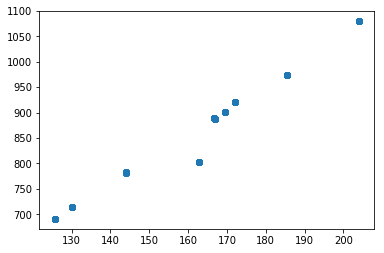

In [456]:
plt.scatter(df['mse'].values, df['test_nll'].values)

In [457]:
3489/60/60

0.9691666666666666

In [452]:
df['']

,fold,mse,repeat,test_nll,test_nmll,train_nll,train_nmll,train_time,dataset
0,0,203.989563,0,1079.646973,21.169521,5239.901367,11.517622,45.176552,housing
1,0,203.989029,1,1079.611938,21.169895,5241.134277,11.518874,45.207898,housing
2,0,203.989609,2,1079.568726,21.168240,5240.715820,11.518463,45.711532,housing
3,0,203.988739,3,1079.662354,21.168131,5240.639160,11.518350,45.543470,housing
4,0,203.989792,4,1079.564819,21.166733,5240.546387,11.516733,43.871764,housing
5,0,203.989029,5,1079.581665,21.167900,5240.642090,11.517544,44.064404,housing
6,0,203.987473,6,1079.642822,21.169821,5240.490723,11.518460,44.693269,housing
7,0,203.988144,7,1079.519409,21.169950,5240.214844,11.519488,44.893738,housing
8,0,203.989197,8,1079.602661,21.168266,5241.418457,11.518588,41.709107,housing
9,0,203.989166,9,1079.700562,21.170130,5241.502441,11.517249,42.205009,housing


In [461]:
text = """2019-02-27 18:11:45.069518 - {'fold': 0, 'repeat': 0, 'mse': 0.07313001155853271, 'train_time': 18.21050319587812, 'train_nmll': -0.2634676694869995, 'test_nmll': 0.1407051980495453, 'train_nll': -44.74034118652344, 'test_nll': 2.7185821533203125}
2019-02-27 18:12:00.226547 - {'fold': 0, 'repeat': 1, 'mse': 0.07101680338382721, 'train_time': 15.156932359095663, 'train_nmll': -0.3156649172306061, 'test_nmll': 0.09640350192785263, 'train_nll': -55.485595703125, 'test_nll': 1.827188491821289}
2019-02-27 18:12:14.976521 - {'fold': 0, 'repeat': 2, 'mse': 0.0729895606637001, 'train_time': 14.749871701002121, 'train_nmll': -0.33502256870269775, 'test_nmll': 0.12224707752466202, 'train_nll': -60.2880859375, 'test_nll': 1.9846649169921875}
2019-02-27 18:12:32.428572 - {'fold': 0, 'repeat': 3, 'mse': 0.07267884910106659, 'train_time': 17.451954272808507, 'train_nmll': -0.3168109357357025, 'test_nmll': 0.10245494544506073, 'train_nll': -57.21910095214844, 'test_nll': 2.033468246459961}
2019-02-27 18:12:50.532522 - {'fold': 0, 'repeat': 4, 'mse': 0.07327921688556671, 'train_time': 18.103849983075634, 'train_nmll': -0.30941280722618103, 'test_nmll': 0.10161761939525604, 'train_nll': -56.501953125, 'test_nll': 2.196195602416992}
2019-02-27 18:13:09.019194 - {'fold': 0, 'repeat': 5, 'mse': 0.0732535719871521, 'train_time': 18.48656295402907, 'train_nmll': -0.30751970410346985, 'test_nmll': 0.0895085334777832, 'train_nll': -56.59431457519531, 'test_nll': 2.646084785461426}
2019-02-27 18:13:26.929771 - {'fold': 0, 'repeat': 6, 'mse': 0.07185467332601547, 'train_time': 17.910462913801894, 'train_nmll': -0.3173889219760895, 'test_nmll': 0.08940563350915909, 'train_nll': -55.40254211425781, 'test_nll': 1.7056026458740234}
2019-02-27 18:13:44.154237 - {'fold': 0, 'repeat': 7, 'mse': 0.06981224566698074, 'train_time': 17.224359273910522, 'train_nmll': -0.3206741213798523, 'test_nmll': 0.07380914688110352, 'train_nll': -56.395660400390625, 'test_nll': 1.4421100616455078}
2019-02-27 18:14:00.339749 - {'fold': 0, 'repeat': 8, 'mse': 0.07199053466320038, 'train_time': 16.185413589002565, 'train_nmll': -0.29403144121170044, 'test_nmll': 0.11769142001867294, 'train_nll': -55.4827880859375, 'test_nll': 2.8016586303710938}
2019-02-27 18:14:15.780302 - {'fold': 0, 'repeat': 9, 'mse': 0.07235368341207504, 'train_time': 15.440453397808596, 'train_nmll': -0.3291492760181427, 'test_nmll': 0.1162177100777626, 'train_nll': -60.36065673828125, 'test_nll': 2.8631792068481445}
2019-02-27 18:14:32.861268 - {'fold': 1, 'repeat': 0, 'mse': 0.11360534280538559, 'train_time': 17.077840640908107, 'train_nmll': -0.28347915410995483, 'test_nmll': 0.2866275906562805, 'train_nll': -49.554046630859375, 'test_nll': 5.902166366577148}
2019-02-27 18:14:51.460686 - {'fold': 1, 'repeat': 1, 'mse': 0.11146263033151627, 'train_time': 18.59930858388543, 'train_nmll': -0.2905139625072479, 'test_nmll': 0.2832842767238617, 'train_nll': -53.72662353515625, 'test_nll': 5.748804092407227}
2019-02-27 18:15:09.042793 - {'fold': 1, 'repeat': 2, 'mse': 0.11420182138681412, 'train_time': 17.582008921075612, 'train_nmll': -0.2900673747062683, 'test_nmll': 0.3057405352592468, 'train_nll': -51.738739013671875, 'test_nll': 6.139369964599609}
2019-02-27 18:15:25.784808 - {'fold': 1, 'repeat': 3, 'mse': 0.11382995545864105, 'train_time': 16.741913278819993, 'train_nmll': -0.28129780292510986, 'test_nmll': 0.29796624183654785, 'train_nll': -50.55900573730469, 'test_nll': 5.977133750915527}
2019-02-27 18:15:41.206844 - {'fold': 1, 'repeat': 4, 'mse': 0.11060360819101334, 'train_time': 15.42194188782014, 'train_nmll': -0.29422301054000854, 'test_nmll': 0.28671130537986755, 'train_nll': -51.523162841796875, 'test_nll': 5.461488723754883}
2019-02-27 18:15:57.275471 - {'fold': 1, 'repeat': 5, 'mse': 0.10469625890254974, 'train_time': 16.06852599978447, 'train_nmll': -0.28496822714805603, 'test_nmll': 0.22790570557117462, 'train_nll': -50.65010070800781, 'test_nll': 4.701238632202148}
2019-02-27 18:16:15.330078 - {'fold': 1, 'repeat': 6, 'mse': 0.11308322101831436, 'train_time': 18.054498884128407, 'train_nmll': -0.2845016419887543, 'test_nmll': 0.29927167296409607, 'train_nll': -51.882537841796875, 'test_nll': 6.319060325622559}
2019-02-27 18:16:32.099123 - {'fold': 1, 'repeat': 7, 'mse': 0.11144665628671646, 'train_time': 16.76894857501611, 'train_nmll': -0.2794318199157715, 'test_nmll': 0.28132185339927673, 'train_nll': -51.071533203125, 'test_nll': 5.76005744934082}
2019-02-27 18:16:49.169997 - {'fold': 1, 'repeat': 8, 'mse': 0.11449108272790909, 'train_time': 17.070773703046143, 'train_nmll': -0.2876618206501007, 'test_nmll': 0.2892300486564636, 'train_nll': -52.158233642578125, 'test_nll': 6.062398910522461}
2019-02-27 18:17:07.461416 - {'fold': 1, 'repeat': 9, 'mse': 0.11356166750192642, 'train_time': 18.29131321585737, 'train_nmll': -0.2714404761791229, 'test_nmll': 0.3129608631134033, 'train_nll': -50.911712646484375, 'test_nll': 6.253701210021973}
2019-02-27 18:17:23.281131 - {'fold': 2, 'repeat': 0, 'mse': 0.21850375831127167, 'train_time': 15.816631419118494, 'train_nmll': -0.4107917845249176, 'test_nmll': 0.7454472780227661, 'train_nll': -73.01565551757812, 'test_nll': 14.683549880981445}
2019-02-27 18:17:41.105429 - {'fold': 2, 'repeat': 1, 'mse': 0.21834659576416016, 'train_time': 17.824198314920068, 'train_nmll': -0.41024237871170044, 'test_nmll': 0.7289853096008301, 'train_nll': -74.57078552246094, 'test_nll': 14.68086051940918}
2019-02-27 18:17:59.273297 - {'fold': 2, 'repeat': 2, 'mse': 0.21653692424297333, 'train_time': 18.167761659016833, 'train_nmll': -0.42084741592407227, 'test_nmll': 0.7059102058410645, 'train_nll': -74.41102600097656, 'test_nll': 13.961114883422852}
2019-02-27 18:18:17.240324 - {'fold': 2, 'repeat': 3, 'mse': 0.2095552384853363, 'train_time': 17.966930235968903, 'train_nmll': -0.4102265238761902, 'test_nmll': 0.6910058259963989, 'train_nll': -74.63522338867188, 'test_nll': 14.391742706298828}
2019-02-27 18:18:31.571884 - {'fold': 2, 'repeat': 4, 'mse': 0.21895098686218262, 'train_time': 14.331469602882862, 'train_nmll': -0.42560508847236633, 'test_nmll': 0.7271007299423218, 'train_nll': -73.88310241699219, 'test_nll': 14.718072891235352}
2019-02-27 18:18:46.669751 - {'fold': 2, 'repeat': 5, 'mse': 0.21205875277519226, 'train_time': 15.097777640912682, 'train_nmll': -0.41609853506088257, 'test_nmll': 0.7306585311889648, 'train_nll': -73.60650634765625, 'test_nll': 14.169485092163086}
2019-02-27 18:19:01.062892 - {'fold': 2, 'repeat': 6, 'mse': 0.21396282315254211, 'train_time': 14.39304105588235, 'train_nmll': -0.3957200050354004, 'test_nmll': 0.7162789106369019, 'train_nll': -73.50315856933594, 'test_nll': 14.09029769897461}
2019-02-27 18:19:17.451044 - {'fold': 2, 'repeat': 7, 'mse': 0.21389946341514587, 'train_time': 16.388057185104117, 'train_nmll': -0.40240225195884705, 'test_nmll': 0.7139172554016113, 'train_nll': -70.59149169921875, 'test_nll': 14.204385757446289}
2019-02-27 18:19:31.802826 - {'fold': 2, 'repeat': 8, 'mse': 0.21828272938728333, 'train_time': 14.351690171053633, 'train_nmll': -0.4188632667064667, 'test_nmll': 0.7449111938476562, 'train_nll': -74.04939270019531, 'test_nll': 14.446914672851562}
2019-02-27 18:19:46.137856 - {'fold': 2, 'repeat': 9, 'mse': 0.21590809524059296, 'train_time': 14.334940182976425, 'train_nmll': -0.435134619474411, 'test_nmll': 0.7548227310180664, 'train_nll': -75.48574829101562, 'test_nll': 14.754270553588867}
2019-02-27 18:20:00.455362 - {'fold': 3, 'repeat': 0, 'mse': 0.853351891040802, 'train_time': 14.315171902999282, 'train_nmll': -0.4241360127925873, 'test_nmll': 1.5160795450210571, 'train_nll': -71.681640625, 'test_nll': 30.431856155395508}
2019-02-27 18:20:15.924563 - {'fold': 3, 'repeat': 1, 'mse': 0.8506598472595215, 'train_time': 15.469100632937625, 'train_nmll': -0.41301336884498596, 'test_nmll': 1.5533394813537598, 'train_nll': -81.260009765625, 'test_nll': 30.473098754882812}
2019-02-27 18:20:31.171032 - {'fold': 3, 'repeat': 2, 'mse': 0.8377593755722046, 'train_time': 15.246373763075098, 'train_nmll': -0.38563409447669983, 'test_nmll': 1.5473642349243164, 'train_nll': -70.06747436523438, 'test_nll': 30.862133026123047}
2019-02-27 18:20:45.432819 - {'fold': 3, 'repeat': 3, 'mse': 0.8601816892623901, 'train_time': 14.261698884889483, 'train_nmll': -0.4595881998538971, 'test_nmll': 1.5485234260559082, 'train_nll': -81.09773254394531, 'test_nll': 30.884611129760742}
2019-02-27 18:21:02.312148 - {'fold': 3, 'repeat': 4, 'mse': 0.8530999422073364, 'train_time': 16.879230545135215, 'train_nmll': -0.38162359595298767, 'test_nmll': 1.5379407405853271, 'train_nll': -67.87925720214844, 'test_nll': 30.960702896118164}
2019-02-27 18:21:20.492315 - {'fold': 3, 'repeat': 5, 'mse': 0.8423398733139038, 'train_time': 18.180061443010345, 'train_nmll': -0.38558927178382874, 'test_nmll': 1.527492642402649, 'train_nll': -66.33442687988281, 'test_nll': 31.08075523376465}
2019-02-27 18:21:37.825674 - {'fold': 3, 'repeat': 6, 'mse': 0.8561797142028809, 'train_time': 17.333263223059475, 'train_nmll': -0.24162986874580383, 'test_nmll': 1.5561165809631348, 'train_nll': -33.7474365234375, 'test_nll': 31.165355682373047}
2019-02-27 18:21:53.156303 - {'fold': 3, 'repeat': 7, 'mse': 0.8379753828048706, 'train_time': 15.330527472076938, 'train_nmll': -0.38623929023742676, 'test_nmll': 1.549367070198059, 'train_nll': -68.81118774414062, 'test_nll': 30.703977584838867}
2019-02-27 18:22:11.344464 - {'fold': 3, 'repeat': 8, 'mse': 0.8531299829483032, 'train_time': 18.188052335986868, 'train_nmll': -0.3783525228500366, 'test_nmll': 1.5724542140960693, 'train_nll': -67.3887939453125, 'test_nll': 30.90804100036621}
2019-02-27 18:22:29.549200 - {'fold': 3, 'repeat': 9, 'mse': 0.8592060804367065, 'train_time': 18.20462896488607, 'train_nmll': 123.69509887695312, 'test_nmll': 1.5460364818572998, 'train_nll': 6584.7353515625, 'test_nll': 30.505956649780273}
2019-02-27 18:22:47.781530 - {'fold': 4, 'repeat': 0, 'mse': 0.08149678260087967, 'train_time': 18.229260136839002, 'train_nmll': -0.3289904296398163, 'test_nmll': 0.2194478064775467, 'train_nll': -58.52452087402344, 'test_nll': 4.030065536499023}
2019-02-27 18:23:05.986399 - {'fold': 4, 'repeat': 1, 'mse': 0.07448487728834152, 'train_time': 18.204760735156015, 'train_nmll': -0.3267630636692047, 'test_nmll': 0.09723100811243057, 'train_nll': -57.66743469238281, 'test_nll': 1.9170646667480469}
2019-02-27 18:23:22.539245 - {'fold': 4, 'repeat': 2, 'mse': 0.08174772560596466, 'train_time': 16.55275223311037, 'train_nmll': -0.33116453886032104, 'test_nmll': 0.1733894795179367, 'train_nll': -56.27386474609375, 'test_nll': 3.099142074584961}
2019-02-27 18:23:39.658154 - {'fold': 4, 'repeat': 3, 'mse': 0.07613369077444077, 'train_time': 17.118809775914997, 'train_nmll': -0.32485657930374146, 'test_nmll': 0.10367412865161896, 'train_nll': -55.96417236328125, 'test_nll': 2.265148162841797}
2019-02-27 18:23:57.875794 - {'fold': 4, 'repeat': 4, 'mse': 0.07921221852302551, 'train_time': 18.21753255208023, 'train_nmll': -0.31203493475914, 'test_nmll': 0.12974634766578674, 'train_nll': -55.756134033203125, 'test_nll': 2.519791603088379}
2019-02-27 18:24:16.102958 - {'fold': 4, 'repeat': 5, 'mse': 0.0886274129152298, 'train_time': 18.227059626951814, 'train_nmll': -0.32428106665611267, 'test_nmll': 0.18425516784191132, 'train_nll': -57.42669677734375, 'test_nll': 3.8311729431152344}
2019-02-27 18:24:34.326168 - {'fold': 4, 'repeat': 6, 'mse': 0.07723501324653625, 'train_time': 18.223102311138064, 'train_nmll': -0.31923726201057434, 'test_nmll': 0.11244859546422958, 'train_nll': -59.056640625, 'test_nll': 2.4830026626586914}
2019-02-27 18:24:52.364618 - {'fold': 4, 'repeat': 7, 'mse': 0.07900796830654144, 'train_time': 18.038340855855495, 'train_nmll': -0.3318019509315491, 'test_nmll': 0.12183447182178497, 'train_nll': -58.89497375488281, 'test_nll': 2.679959297180176}
2019-02-27 18:25:10.510746 - {'fold': 4, 'repeat': 8, 'mse': 0.07450731098651886, 'train_time': 18.14602127391845, 'train_nmll': -0.31643176078796387, 'test_nmll': 0.10555648803710938, 'train_nll': -57.270599365234375, 'test_nll': 1.772836685180664}
2019-02-27 18:25:27.772499 - {'fold': 4, 'repeat': 9, 'mse': 0.09144625067710876, 'train_time': 17.261643741978332, 'train_nmll': -0.3159395754337311, 'test_nmll': 0.19917531311511993, 'train_nll': -57.89202880859375, 'test_nll': 3.7566328048706055}
2019-02-27 18:25:45.691671 - {'fold': 5, 'repeat': 0, 'mse': 0.14937156438827515, 'train_time': 17.916039165109396, 'train_nmll': -0.2359265685081482, 'test_nmll': 0.34131336212158203, 'train_nll': -42.74237060546875, 'test_nll': 7.060683250427246}
2019-02-27 18:26:03.876167 - {'fold': 5, 'repeat': 1, 'mse': 0.14970770478248596, 'train_time': 18.184389875037596, 'train_nmll': -0.23861075937747955, 'test_nmll': 0.3432798981666565, 'train_nll': -42.303466796875, 'test_nll': 6.688614845275879}
2019-02-27 18:26:22.098564 - {'fold': 5, 'repeat': 2, 'mse': 0.15101319551467896, 'train_time': 18.22229140298441, 'train_nmll': -0.2335556000471115, 'test_nmll': 0.3489514887332916, 'train_nll': -41.864898681640625, 'test_nll': 7.081062316894531}
2019-02-27 18:26:40.353545 - {'fold': 5, 'repeat': 3, 'mse': 0.1504264771938324, 'train_time': 18.254871569108218, 'train_nmll': -0.24253718554973602, 'test_nmll': 0.3594795763492584, 'train_nll': -42.07684326171875, 'test_nll': 7.307163238525391}
2019-02-27 18:26:58.628392 - {'fold': 5, 'repeat': 4, 'mse': 0.14764076471328735, 'train_time': 18.2747361198999, 'train_nmll': -0.2222708761692047, 'test_nmll': 0.32825273275375366, 'train_nll': -41.858734130859375, 'test_nll': 6.865884780883789}
2019-02-27 18:27:16.918633 - {'fold': 5, 'repeat': 5, 'mse': 0.15069450438022614, 'train_time': 18.2901240051724, 'train_nmll': -0.2447182536125183, 'test_nmll': 0.3386062979698181, 'train_nll': -42.751922607421875, 'test_nll': 6.565106391906738}
2019-02-27 18:27:35.105505 - {'fold': 5, 'repeat': 6, 'mse': 0.15027645230293274, 'train_time': 18.18676426797174, 'train_nmll': -0.23199166357517242, 'test_nmll': 0.33426323533058167, 'train_nll': -41.69612121582031, 'test_nll': 6.913460731506348}
2019-02-27 18:27:50.657527 - {'fold': 5, 'repeat': 7, 'mse': 0.14804817736148834, 'train_time': 15.551911474904045, 'train_nmll': -0.23907259106636047, 'test_nmll': 0.34354862570762634, 'train_nll': -42.075439453125, 'test_nll': 6.797041893005371}
2019-02-27 18:28:04.754666 - {'fold': 5, 'repeat': 8, 'mse': 0.14946624636650085, 'train_time': 14.097027603071183, 'train_nmll': -0.24104046821594238, 'test_nmll': 0.3491881489753723, 'train_nll': -42.01475524902344, 'test_nll': 6.8922576904296875}
2019-02-27 18:28:19.457065 - {'fold': 5, 'repeat': 9, 'mse': 0.15092256665229797, 'train_time': 14.702297115931287, 'train_nmll': -0.23815858364105225, 'test_nmll': 0.35303401947021484, 'train_nll': -42.765167236328125, 'test_nll': 6.919231414794922}
2019-02-27 18:28:37.371577 - {'fold': 6, 'repeat': 0, 'mse': 0.12068501859903336, 'train_time': 17.911359908990562, 'train_nmll': -0.29917246103286743, 'test_nmll': 0.10735120624303818, 'train_nll': -51.86021423339844, 'test_nll': 1.9154472351074219}
2019-02-27 18:28:55.632959 - {'fold': 6, 'repeat': 1, 'mse': 0.13953742384910583, 'train_time': 18.261273419950157, 'train_nmll': -0.36837640404701233, 'test_nmll': 0.19281630218029022, 'train_nll': -59.04396057128906, 'test_nll': 3.939436912536621}
2019-02-27 18:29:13.896656 - {'fold': 6, 'repeat': 2, 'mse': 0.12254844605922699, 'train_time': 18.263588688103482, 'train_nmll': -0.3283643126487732, 'test_nmll': 0.09349622577428818, 'train_nll': -62.15473937988281, 'test_nll': 2.289091110229492}
2019-02-27 18:29:32.345848 - {'fold': 6, 'repeat': 3, 'mse': 0.13072344660758972, 'train_time': 18.44908790709451, 'train_nmll': -0.3639377951622009, 'test_nmll': 0.17950811982154846, 'train_nll': -58.73896789550781, 'test_nll': 3.2430477142333984}
2019-02-27 18:29:49.526263 - {'fold': 6, 'repeat': 4, 'mse': 0.13586106896400452, 'train_time': 17.18031847011298, 'train_nmll': -0.3707706034183502, 'test_nmll': 0.184502512216568, 'train_nll': -72.21722412109375, 'test_nll': 3.6274843215942383}
2019-02-27 18:30:06.207829 - {'fold': 6, 'repeat': 5, 'mse': 0.1243552714586258, 'train_time': 16.68147629289888, 'train_nmll': -0.3088621497154236, 'test_nmll': 0.12628111243247986, 'train_nll': -53.31666564941406, 'test_nll': 2.199808120727539}
2019-02-27 18:30:21.496770 - {'fold': 6, 'repeat': 6, 'mse': 0.12925125658512115, 'train_time': 15.288851825986058, 'train_nmll': -0.33676019310951233, 'test_nmll': 0.14344587922096252, 'train_nll': -59.41123962402344, 'test_nll': 2.4758548736572266}
2019-02-27 18:30:38.705241 - {'fold': 6, 'repeat': 7, 'mse': 0.12151427567005157, 'train_time': 17.20836605411023, 'train_nmll': -0.3051258623600006, 'test_nmll': 0.11023473739624023, 'train_nll': -56.92771911621094, 'test_nll': 1.972787857055664}
2019-02-27 18:30:56.924192 - {'fold': 6, 'repeat': 8, 'mse': 0.12382207810878754, 'train_time': 18.218832046957687, 'train_nmll': -0.2953052222728729, 'test_nmll': 0.12415709346532822, 'train_nll': -55.29254150390625, 'test_nll': 2.4248552322387695}
2019-02-27 18:31:13.284610 - {'fold': 6, 'repeat': 9, 'mse': 0.1243102103471756, 'train_time': 16.360321642132476, 'train_nmll': -0.3115311563014984, 'test_nmll': 0.10461731255054474, 'train_nll': -54.33343505859375, 'test_nll': 2.040456771850586}
2019-02-27 18:31:27.985402 - {'fold': 7, 'repeat': 0, 'mse': 0.4325105547904968, 'train_time': 14.698460306972265, 'train_nmll': -0.32341131567955017, 'test_nmll': 0.45436805486679077, 'train_nll': -55.999267578125, 'test_nll': 8.961737632751465}
2019-02-27 18:31:46.273182 - {'fold': 7, 'repeat': 1, 'mse': 0.418281227350235, 'train_time': 18.287673061015084, 'train_nmll': -0.3163553774356842, 'test_nmll': 0.4427938461303711, 'train_nll': -57.802886962890625, 'test_nll': 8.54616641998291}
2019-02-27 18:32:03.411046 - {'fold': 7, 'repeat': 2, 'mse': 0.42604732513427734, 'train_time': 17.13775462890044, 'train_nmll': -0.3148457705974579, 'test_nmll': 0.42977532744407654, 'train_nll': -55.556640625, 'test_nll': 8.402076721191406}
2019-02-27 18:32:21.671796 - {'fold': 7, 'repeat': 3, 'mse': 0.4223395884037018, 'train_time': 18.260641156928614, 'train_nmll': -0.3231687843799591, 'test_nmll': 0.42918896675109863, 'train_nll': -56.6063232421875, 'test_nll': 8.802035331726074}
2019-02-27 18:32:37.282508 - {'fold': 7, 'repeat': 4, 'mse': 0.4170282781124115, 'train_time': 15.610616330057383, 'train_nmll': -0.32495439052581787, 'test_nmll': 0.42543545365333557, 'train_nll': -57.512542724609375, 'test_nll': 8.687837600708008}
2019-02-27 18:32:51.553626 - {'fold': 7, 'repeat': 5, 'mse': 0.43593916296958923, 'train_time': 14.271027064882219, 'train_nmll': -0.3383655250072479, 'test_nmll': 0.4166452884674072, 'train_nll': -62.72467041015625, 'test_nll': 8.520566940307617}
2019-02-27 18:33:07.695486 - {'fold': 7, 'repeat': 6, 'mse': 0.4296094477176666, 'train_time': 16.14176002610475, 'train_nmll': -0.3348335325717926, 'test_nmll': 0.37096816301345825, 'train_nll': -59.04804992675781, 'test_nll': 7.610174179077148}
2019-02-27 18:33:25.937205 - {'fold': 7, 'repeat': 7, 'mse': 0.43011680245399475, 'train_time': 18.241612574085593, 'train_nmll': -0.342119425535202, 'test_nmll': 0.404533326625824, 'train_nll': -58.72698974609375, 'test_nll': 7.887367248535156}
2019-02-27 18:33:44.053112 - {'fold': 7, 'repeat': 8, 'mse': 0.42360058426856995, 'train_time': 18.115799690131098, 'train_nmll': -0.32772096991539, 'test_nmll': 0.3781060576438904, 'train_nll': -57.618682861328125, 'test_nll': 7.806077003479004}
2019-02-27 18:34:02.253531 - {'fold': 7, 'repeat': 9, 'mse': 0.43700069189071655, 'train_time': 18.200312295928597, 'train_nmll': -0.3429202735424042, 'test_nmll': 0.3720884323120117, 'train_nll': -61.3040771484375, 'test_nll': 7.696181297302246}
2019-02-27 18:34:20.273530 - {'fold': 8, 'repeat': 0, 'mse': 0.06592128425836563, 'train_time': 18.016983011038974, 'train_nmll': -0.3614695966243744, 'test_nmll': 0.03901243209838867, 'train_nll': -69.66181945800781, 'test_nll': 0.603912353515625}
2019-02-27 18:34:36.160924 - {'fold': 8, 'repeat': 1, 'mse': 0.06254877150058746, 'train_time': 15.887287876103073, 'train_nmll': -0.5266926884651184, 'test_nmll': 0.024799251928925514, 'train_nll': -71.3802490234375, 'test_nll': 0.4683094024658203}
2019-02-27 18:34:54.065629 - {'fold': 8, 'repeat': 2, 'mse': 0.05376816913485527, 'train_time': 17.90460748807527, 'train_nmll': -0.35221320390701294, 'test_nmll': -0.06891040503978729, 'train_nll': -64.32748413085938, 'test_nll': -1.2784957885742188}
2019-02-27 18:35:09.854046 - {'fold': 8, 'repeat': 3, 'mse': 0.053352098912000656, 'train_time': 15.78831567405723, 'train_nmll': -0.3863074481487274, 'test_nmll': -0.06424150615930557, 'train_nll': -65.45083618164062, 'test_nll': -0.9634552001953125}
2019-02-27 18:35:28.241761 - {'fold': 8, 'repeat': 4, 'mse': 0.052479278296232224, 'train_time': 18.387605712050572, 'train_nmll': -0.3430960774421692, 'test_nmll': -0.09386339038610458, 'train_nll': -67.76054382324219, 'test_nll': -1.4993858337402344}
2019-02-27 18:35:46.518476 - {'fold': 8, 'repeat': 5, 'mse': 0.06778699159622192, 'train_time': 18.276605509920046, 'train_nmll': -0.39957165718078613, 'test_nmll': 0.05058012157678604, 'train_nll': -73.02555847167969, 'test_nll': 0.9563617706298828}
2019-02-27 18:36:04.831461 - {'fold': 8, 'repeat': 6, 'mse': 0.05147678777575493, 'train_time': 18.31287638703361, 'train_nmll': -0.09581103920936584, 'test_nmll': -0.07746925204992294, 'train_nll': -33.42242431640625, 'test_nll': -1.729217529296875}
2019-02-27 18:36:21.677077 - {'fold': 8, 'repeat': 7, 'mse': 0.058241426944732666, 'train_time': 16.84550837590359, 'train_nmll': -0.4309307634830475, 'test_nmll': -0.014904499053955078, 'train_nll': -72.79869079589844, 'test_nll': 0.09648704528808594}
2019-02-27 18:36:36.652095 - {'fold': 8, 'repeat': 8, 'mse': 0.0545177236199379, 'train_time': 14.974919433007017, 'train_nmll': -0.36213403940200806, 'test_nmll': -0.06717748939990997, 'train_nll': -61.48161315917969, 'test_nll': -1.4332599639892578}
2019-02-27 18:36:51.051855 - {'fold': 8, 'repeat': 9, 'mse': 0.06154962629079819, 'train_time': 14.399638823000714, 'train_nmll': -0.35029372572898865, 'test_nmll': 0.023374270647764206, 'train_nll': -70.22381591796875, 'test_nll': 0.10736656188964844}
2019-02-27 18:37:10.033467 - {'fold': 9, 'repeat': 0, 'mse': 0.06856930255889893, 'train_time': 18.97771521192044, 'train_nmll': -0.2976055443286896, 'test_nmll': 0.17185993492603302, 'train_nll': -53.04209899902344, 'test_nll': 3.170011520385742}
2019-02-27 18:37:24.489696 - {'fold': 9, 'repeat': 1, 'mse': 0.06839479506015778, 'train_time': 14.45613363897428, 'train_nmll': -0.29030948877334595, 'test_nmll': 0.15908809006214142, 'train_nll': -52.35459899902344, 'test_nll': 3.0557374954223633}
2019-02-27 18:37:42.271740 - {'fold': 9, 'repeat': 2, 'mse': 0.07007448375225067, 'train_time': 17.781946044880897, 'train_nmll': -0.2761436402797699, 'test_nmll': 0.14913639426231384, 'train_nll': -49.216400146484375, 'test_nll': 3.2513933181762695}
2019-02-27 18:38:00.540401 - {'fold': 9, 'repeat': 3, 'mse': 0.06634604185819626, 'train_time': 18.26855525118299, 'train_nmll': -0.27626833319664, 'test_nmll': 0.13522124290466309, 'train_nll': -50.59346008300781, 'test_nll': 2.487208366394043}
2019-02-27 18:38:17.912627 - {'fold': 9, 'repeat': 4, 'mse': 0.06903714686632156, 'train_time': 17.37212949199602, 'train_nmll': -0.29232779145240784, 'test_nmll': 0.1609487533569336, 'train_nll': -50.501556396484375, 'test_nll': 3.2997541427612305}
2019-02-27 18:38:32.096610 - {'fold': 9, 'repeat': 5, 'mse': 0.06877510249614716, 'train_time': 14.183892650995404, 'train_nmll': -0.282380074262619, 'test_nmll': 0.1466623842716217, 'train_nll': -49.81803894042969, 'test_nll': 3.302095413208008}
2019-02-27 18:38:46.690428 - {'fold': 9, 'repeat': 6, 'mse': 0.06895970553159714, 'train_time': 14.593729065032676, 'train_nmll': -0.2775079607963562, 'test_nmll': 0.13829346001148224, 'train_nll': -48.41960144042969, 'test_nll': 2.267496109008789}
2019-02-27 18:39:00.899933 - {'fold': 9, 'repeat': 7, 'mse': 0.06874920427799225, 'train_time': 14.209416113095358, 'train_nmll': -0.27769502997398376, 'test_nmll': 0.14425449073314667, 'train_nll': -50.59661865234375, 'test_nll': 2.843547821044922}
2019-02-27 18:39:15.222928 - {'fold': 9, 'repeat': 8, 'mse': 0.06575300544500351, 'train_time': 14.322897556005046, 'train_nmll': -0.2766028642654419, 'test_nmll': 0.11983761936426163, 'train_nll': -50.360076904296875, 'test_nll': 2.7878494262695312}
2019-02-27 18:39:30.746672 - {'fold': 9, 'repeat': 9, 'mse': 0.06882442533969879, 'train_time': 15.523637135978788, 'train_nmll': -0.2836567461490631, 'test_nmll': 0.13978004455566406, 'train_nll': -50.601043701171875, 'test_nll': 2.8272647857666016}
2019-02-27 18:40:48.267454 - {'fold': 0, 'repeat': 0, 'mse': 955.347900390625, 'train_time': 77.5040388489142, 'train_nmll': 57.858680725097656, 'test_nmll': 78.23240661621094, 'train_nll': 53634.703125, 'test_nll': 8058.0556640625}
2019-02-27 18:42:04.898932 - {'fold': 0, 'repeat': 1, 'mse': 955.3480224609375, 'train_time': 76.63138629798777, 'train_nmll': 57.858489990234375, 'test_nmll': 78.23225402832031, 'train_nll': 53635.328125, 'test_nll': 8058.02783203125}
2019-02-27 18:43:23.303529 - {'fold': 0, 'repeat': 2, 'mse': 955.3475341796875, 'train_time': 78.40450643585064, 'train_nmll': 57.85902404785156, 'test_nmll': 78.23320770263672, 'train_nll': 53634.55859375, 'test_nll': 8058.03466796875}
2019-02-27 18:44:41.947175 - {'fold': 0, 'repeat': 3, 'mse': 955.34716796875, 'train_time': 78.64355385210365, 'train_nmll': 57.85844802856445, 'test_nmll': 78.2335433959961, 'train_nll': 53635.72265625, 'test_nll': 8058.03369140625}
2019-02-27 18:46:01.539384 - {'fold': 0, 'repeat': 4, 'mse': 955.347900390625, 'train_time': 79.59211578918621, 'train_nmll': 57.85921096801758, 'test_nmll': 78.23342895507812, 'train_nll': 53634.91796875, 'test_nll': 8057.95263671875}
2019-02-27 18:47:15.338883 - {'fold': 0, 'repeat': 5, 'mse': 955.347900390625, 'train_time': 73.79940489307046, 'train_nmll': 57.8598518371582, 'test_nmll': 78.23292541503906, 'train_nll': 53635.65625, 'test_nll': 8057.990234375}
2019-02-27 18:48:33.788513 - {'fold': 0, 'repeat': 6, 'mse': 955.3478393554688, 'train_time': 78.44953873101622, 'train_nmll': 57.85847854614258, 'test_nmll': 78.23289489746094, 'train_nll': 53635.1015625, 'test_nll': 8057.9716796875}
2019-02-27 18:49:49.546781 - {'fold': 0, 'repeat': 7, 'mse': 955.3477172851562, 'train_time': 75.75817862688564, 'train_nmll': 57.8590087890625, 'test_nmll': 78.233642578125, 'train_nll': 53635.44921875, 'test_nll': 8057.98779296875}
2019-02-27 18:51:05.910085 - {'fold': 0, 'repeat': 8, 'mse': 955.3478393554688, 'train_time': 76.36321052908897, 'train_nmll': 57.85906219482422, 'test_nmll': 78.23321533203125, 'train_nll': 53635.5234375, 'test_nll': 8058.0146484375}
2019-02-27 18:52:24.714196 - {'fold': 0, 'repeat': 9, 'mse': 955.3482055664062, 'train_time': 78.80399611289613, 'train_nmll': 57.85945129394531, 'test_nmll': 78.2335433959961, 'train_nll': 53635.3984375, 'test_nll': 8057.9736328125}
2019-02-27 18:53:43.652251 - {'fold': 1, 'repeat': 0, 'mse': 996.5831298828125, 'train_time': 78.93369461479597, 'train_nmll': 57.25476837158203, 'test_nmll': 81.39676666259766, 'train_nll': 53075.68359375, 'test_nll': 8383.8916015625}
2019-02-27 18:54:59.361740 - {'fold': 1, 'repeat': 1, 'mse': 996.5830688476562, 'train_time': 75.70939715998247, 'train_nmll': 57.2547492980957, 'test_nmll': 81.39653778076172, 'train_nll': 53075.13671875, 'test_nll': 8383.892578125}
2019-02-27 18:56:15.463790 - {'fold': 1, 'repeat': 2, 'mse': 996.5825805664062, 'train_time': 76.10195948393084, 'train_nmll': 57.25442123413086, 'test_nmll': 81.39745330810547, 'train_nll': 53074.5625, 'test_nll': 8383.8642578125}
2019-02-27 18:57:29.894421 - {'fold': 1, 'repeat': 3, 'mse': 996.5828247070312, 'train_time': 74.43053819891065, 'train_nmll': 57.25457763671875, 'test_nmll': 81.39700317382812, 'train_nll': 53074.20703125, 'test_nll': 8383.8671875}
2019-02-27 18:58:47.950939 - {'fold': 1, 'repeat': 4, 'mse': 996.5830688476562, 'train_time': 78.0564277980011, 'train_nmll': 57.254783630371094, 'test_nmll': 81.39700317382812, 'train_nll': 53074.6328125, 'test_nll': 8383.8427734375}
2019-02-27 19:00:04.416139 - {'fold': 1, 'repeat': 5, 'mse': 996.5831298828125, 'train_time': 76.46511019882746, 'train_nmll': 57.2540397644043, 'test_nmll': 81.39651489257812, 'train_nll': 53075.66015625, 'test_nll': 8383.865234375}
2019-02-27 19:01:19.999315 - {'fold': 1, 'repeat': 6, 'mse': 996.5830688476562, 'train_time': 75.58308320399374, 'train_nmll': 57.255008697509766, 'test_nmll': 81.39674377441406, 'train_nll': 53075.3046875, 'test_nll': 8383.83984375}
2019-02-27 19:02:35.561620 - {'fold': 1, 'repeat': 7, 'mse': 996.5830078125, 'train_time': 75.56221412913874, 'train_nmll': 57.254459381103516, 'test_nmll': 81.39649963378906, 'train_nll': 53075.6171875, 'test_nll': 8383.888671875}
2019-02-27 19:03:55.059091 - {'fold': 1, 'repeat': 8, 'mse': 996.5828247070312, 'train_time': 79.4973797108978, 'train_nmll': 57.25463104248047, 'test_nmll': 81.39698791503906, 'train_nll': 53076.02734375, 'test_nll': 8383.7919921875}
2019-02-27 19:05:13.153205 - {'fold': 1, 'repeat': 9, 'mse': 996.5825805664062, 'train_time': 78.09402396786027, 'train_nmll': 57.25555419921875, 'test_nmll': 81.39700317382812, 'train_nll': 53074.69921875, 'test_nll': 8383.8916015625}
2019-02-27 19:06:24.507883 - {'fold': 2, 'repeat': 0, 'mse': 836.6710205078125, 'train_time': 71.35091961617582, 'train_nmll': 57.640262603759766, 'test_nmll': 68.60418701171875, 'train_nll': 53432.3046875, 'test_nll': 7066.22265625}
2019-02-27 19:07:40.214680 - {'fold': 2, 'repeat': 1, 'mse': 836.6709594726562, 'train_time': 75.70670470991172, 'train_nmll': 57.63982009887695, 'test_nmll': 68.60419464111328, 'train_nll': 53432.59765625, 'test_nll': 7066.23193359375}
2019-02-27 19:09:01.055387 - {'fold': 2, 'repeat': 2, 'mse': 836.6712646484375, 'train_time': 80.84061586600728, 'train_nmll': 57.639976501464844, 'test_nmll': 68.60424041748047, 'train_nll': 53431.55859375, 'test_nll': 7066.2451171875}
2019-02-27 19:10:12.742320 - {'fold': 2, 'repeat': 3, 'mse': 836.6715087890625, 'train_time': 71.68684079009108, 'train_nmll': 57.64065933227539, 'test_nmll': 68.6043472290039, 'train_nll': 53432.5390625, 'test_nll': 7066.2314453125}
2019-02-27 19:11:24.860730 - {'fold': 2, 'repeat': 4, 'mse': 836.6708984375, 'train_time': 72.11832011397928, 'train_nmll': 57.6400146484375, 'test_nmll': 68.6042251586914, 'train_nll': 53431.28125, 'test_nll': 7066.2314453125}
2019-02-27 19:12:41.800797 - {'fold': 2, 'repeat': 5, 'mse': 836.6712646484375, 'train_time': 76.93997471919283, 'train_nmll': 57.64009094238281, 'test_nmll': 68.60432434082031, 'train_nll': 53432.99609375, 'test_nll': 7066.23486328125}
2019-02-27 19:14:00.196701 - {'fold': 2, 'repeat': 6, 'mse': 836.6707153320312, 'train_time': 78.39581456501037, 'train_nmll': 57.640228271484375, 'test_nmll': 68.60418701171875, 'train_nll': 53433.02734375, 'test_nll': 7066.23876953125}
2019-02-27 19:15:20.678808 - {'fold': 2, 'repeat': 7, 'mse': 836.6712036132812, 'train_time': 80.48201340716332, 'train_nmll': 57.63945388793945, 'test_nmll': 68.60418701171875, 'train_nll': 53430.96875, 'test_nll': 7066.2353515625}
2019-02-27 19:16:38.951943 - {'fold': 2, 'repeat': 8, 'mse': 836.6715698242188, 'train_time': 78.27304436010309, 'train_nmll': 57.639747619628906, 'test_nmll': 68.604248046875, 'train_nll': 53433.0078125, 'test_nll': 7066.24560546875}
2019-02-27 19:17:59.075769 - {'fold': 2, 'repeat': 9, 'mse': 836.6712646484375, 'train_time': 80.12373383599333, 'train_nmll': 57.6396484375, 'test_nmll': 68.60432434082031, 'train_nll': 53432.234375, 'test_nll': 7066.2490234375}
2019-02-27 19:19:16.097277 - {'fold': 3, 'repeat': 0, 'mse': 801.2163696289062, 'train_time': 77.01782992784865, 'train_nmll': 58.30778121948242, 'test_nmll': 65.46955871582031, 'train_nll': 54052.109375, 'test_nll': 6743.298828125}
2019-02-27 19:20:36.212861 - {'fold': 3, 'repeat': 1, 'mse': 801.2161254882812, 'train_time': 80.11549296299927, 'train_nmll': 58.30891036987305, 'test_nmll': 65.47174835205078, 'train_nll': 54051.86328125, 'test_nll': 6743.40673828125}
2019-02-27 19:21:56.732195 - {'fold': 3, 'repeat': 2, 'mse': 801.21533203125, 'train_time': 80.51924285595305, 'train_nmll': 58.30879592895508, 'test_nmll': 65.46936798095703, 'train_nll': 54050.734375, 'test_nll': 6743.30810546875}
2019-02-27 19:23:13.422224 - {'fold': 3, 'repeat': 3, 'mse': 801.2166137695312, 'train_time': 76.68993655289523, 'train_nmll': 58.30927658081055, 'test_nmll': 65.46927642822266, 'train_nll': 54051.59765625, 'test_nll': 6743.44873046875}
2019-02-27 19:24:30.641804 - {'fold': 3, 'repeat': 4, 'mse': 801.216552734375, 'train_time': 77.21948768408038, 'train_nmll': 58.30817794799805, 'test_nmll': 65.47022247314453, 'train_nll': 54051.2109375, 'test_nll': 6743.41455078125}
2019-02-27 19:25:47.843149 - {'fold': 3, 'repeat': 5, 'mse': 801.216796875, 'train_time': 77.2012539759744, 'train_nmll': 58.30805969238281, 'test_nmll': 65.46926879882812, 'train_nll': 54051.9765625, 'test_nll': 6743.4375}
2019-02-27 19:27:03.357504 - {'fold': 3, 'repeat': 6, 'mse': 801.2162475585938, 'train_time': 75.51426301384345, 'train_nmll': 58.307395935058594, 'test_nmll': 65.46932983398438, 'train_nll': 54052.27734375, 'test_nll': 6743.4912109375}
2019-02-27 19:28:20.558031 - {'fold': 3, 'repeat': 7, 'mse': 801.2166748046875, 'train_time': 77.20040875999257, 'train_nmll': 58.30923843383789, 'test_nmll': 65.46942901611328, 'train_nll': 54051.7890625, 'test_nll': 6743.42529296875}
2019-02-27 19:29:40.845185 - {'fold': 3, 'repeat': 8, 'mse': 801.2162475585938, 'train_time': 80.28706184611656, 'train_nmll': 58.308258056640625, 'test_nmll': 65.47180938720703, 'train_nll': 54051.5390625, 'test_nll': 6743.4892578125}
2019-02-27 19:30:58.844183 - {'fold': 3, 'repeat': 9, 'mse': 801.2158813476562, 'train_time': 77.99890513997525, 'train_nmll': 58.309024810791016, 'test_nmll': 65.47032165527344, 'train_nll': 54051.48046875, 'test_nll': 6743.349609375}
2019-02-27 19:32:15.208807 - {'fold': 4, 'repeat': 0, 'mse': 1112.0430908203125, 'train_time': 76.36086719995365, 'train_nmll': 56.342308044433594, 'test_nmll': 90.04755401611328, 'train_nll': 52227.84375, 'test_nll': 9274.8974609375}
2019-02-27 19:33:29.398033 - {'fold': 4, 'repeat': 1, 'mse': 1112.043212890625, 'train_time': 74.18911065906286, 'train_nmll': 56.34121322631836, 'test_nmll': 90.04740905761719, 'train_nll': 52228.52734375, 'test_nll': 9274.8935546875}
2019-02-27 19:34:43.886712 - {'fold': 4, 'repeat': 2, 'mse': 1112.04345703125, 'train_time': 74.48857585713267, 'train_nmll': 56.341732025146484, 'test_nmll': 90.04828643798828, 'train_nll': 52229.36328125, 'test_nll': 9274.90234375}
2019-02-27 19:36:01.264256 - {'fold': 4, 'repeat': 3, 'mse': 1112.0430908203125, 'train_time': 77.37745440285653, 'train_nmll': 56.34172439575195, 'test_nmll': 90.0466537475586, 'train_nll': 52229.25390625, 'test_nll': 9274.8662109375}
2019-02-27 19:37:21.476347 - {'fold': 4, 'repeat': 4, 'mse': 1112.042724609375, 'train_time': 80.21200065803714, 'train_nmll': 56.342437744140625, 'test_nmll': 90.04730224609375, 'train_nll': 52228.65234375, 'test_nll': 9274.9052734375}
2019-02-27 19:38:33.606601 - {'fold': 4, 'repeat': 5, 'mse': 1112.0430908203125, 'train_time': 72.13015672005713, 'train_nmll': 56.341026306152344, 'test_nmll': 90.0471420288086, 'train_nll': 52229.55078125, 'test_nll': 9274.984375}
2019-02-27 19:39:52.740856 - {'fold': 4, 'repeat': 6, 'mse': 1112.04296875, 'train_time': 79.13415570906363, 'train_nmll': 56.341739654541016, 'test_nmll': 90.04597473144531, 'train_nll': 52229.15625, 'test_nll': 9274.888671875}
2019-02-27 19:41:10.773246 - {'fold': 4, 'repeat': 7, 'mse': 1112.042724609375, 'train_time': 78.03229585988447, 'train_nmll': 56.34165954589844, 'test_nmll': 90.0476303100586, 'train_nll': 52228.08984375, 'test_nll': 9274.9453125}
2019-02-27 19:42:28.784295 - {'fold': 4, 'repeat': 8, 'mse': 1112.043212890625, 'train_time': 78.01095718005672, 'train_nmll': 56.341896057128906, 'test_nmll': 90.04664611816406, 'train_nll': 52229.21875, 'test_nll': 9274.8623046875}
2019-02-27 19:43:48.069203 - {'fold': 4, 'repeat': 9, 'mse': 1112.0433349609375, 'train_time': 79.28481751889922, 'train_nmll': 56.34219741821289, 'test_nmll': 90.04706573486328, 'train_nll': 52228.0078125, 'test_nll': 9274.8193359375}
2019-02-27 19:45:07.999830 - {'fold': 5, 'repeat': 0, 'mse': 1143.4163818359375, 'train_time': 79.92688682489097, 'train_nmll': 56.31112289428711, 'test_nmll': 92.96473693847656, 'train_nll': 52200.15625, 'test_nll': 9575.314453125}
2019-02-27 19:46:27.847447 - {'fold': 5, 'repeat': 1, 'mse': 1143.414794921875, 'train_time': 79.84752620989457, 'train_nmll': 56.310489654541016, 'test_nmll': 92.96276092529297, 'train_nll': 52200.66796875, 'test_nll': 9575.2646484375}
2019-02-27 19:47:48.476326 - {'fold': 5, 'repeat': 2, 'mse': 1143.4151611328125, 'train_time': 80.62878756201826, 'train_nmll': 56.310489654541016, 'test_nmll': 92.96379089355469, 'train_nll': 52199.80078125, 'test_nll': 9575.181640625}
2019-02-27 19:49:06.385238 - {'fold': 5, 'repeat': 3, 'mse': 1143.4146728515625, 'train_time': 77.90882164100185, 'train_nmll': 56.31103515625, 'test_nmll': 92.96394348144531, 'train_nll': 52198.921875, 'test_nll': 9575.341796875}
2019-02-27 19:50:24.363727 - {'fold': 5, 'repeat': 4, 'mse': 1143.41552734375, 'train_time': 77.97839832119644, 'train_nmll': 56.3112907409668, 'test_nmll': 92.96344757080078, 'train_nll': 52200.65625, 'test_nll': 9575.216796875}
2019-02-27 19:51:42.768772 - {'fold': 5, 'repeat': 5, 'mse': 1143.4149169921875, 'train_time': 78.40495422505774, 'train_nmll': 56.310569763183594, 'test_nmll': 92.96282196044922, 'train_nll': 52199.8515625, 'test_nll': 9575.13671875}
2019-02-27 19:53:00.247607 - {'fold': 5, 'repeat': 6, 'mse': 1143.41552734375, 'train_time': 77.47874333197251, 'train_nmll': 56.310935974121094, 'test_nmll': 92.964599609375, 'train_nll': 52200.3828125, 'test_nll': 9575.3095703125}
2019-02-27 19:54:17.295160 - {'fold': 5, 'repeat': 7, 'mse': 1143.414306640625, 'train_time': 77.04745817696676, 'train_nmll': 56.310428619384766, 'test_nmll': 92.963623046875, 'train_nll': 52200.234375, 'test_nll': 9575.0263671875}
2019-02-27 19:55:34.138472 - {'fold': 5, 'repeat': 8, 'mse': 1143.4149169921875, 'train_time': 76.84321917500347, 'train_nmll': 56.31067657470703, 'test_nmll': 92.96343994140625, 'train_nll': 52199.56640625, 'test_nll': 9575.251953125}
2019-02-27 19:56:48.754310 - {'fold': 5, 'repeat': 9, 'mse': 1143.4151611328125, 'train_time': 74.61574654700235, 'train_nmll': 56.31049346923828, 'test_nmll': 92.96297454833984, 'train_nll': 52199.5234375, 'test_nll': 9575.439453125}
2019-02-27 19:58:06.838250 - {'fold': 6, 'repeat': 0, 'mse': 1076.443603515625, 'train_time': 78.08021862991154, 'train_nmll': 56.576393127441406, 'test_nmll': 87.30143737792969, 'train_nll': 52446.28125, 'test_nll': 8992.0322265625}
2019-02-27 19:59:26.751210 - {'fold': 6, 'repeat': 1, 'mse': 1076.4437255859375, 'train_time': 79.91287007718347, 'train_nmll': 56.57730484008789, 'test_nmll': 87.30087280273438, 'train_nll': 52447.171875, 'test_nll': 8991.93359375}
2019-02-27 20:00:45.696012 - {'fold': 6, 'repeat': 2, 'mse': 1076.4437255859375, 'train_time': 78.94470908283256, 'train_nmll': 56.57636642456055, 'test_nmll': 87.30104064941406, 'train_nll': 52446.24609375, 'test_nll': 8991.9765625}
2019-02-27 20:02:05.689914 - {'fold': 6, 'repeat': 3, 'mse': 1076.443603515625, 'train_time': 79.9938131829258, 'train_nmll': 56.577239990234375, 'test_nmll': 87.30241394042969, 'train_nll': 52446.5625, 'test_nll': 8992.0146484375}
2019-02-27 20:03:24.864332 - {'fold': 6, 'repeat': 4, 'mse': 1076.4443359375, 'train_time': 79.17431843583472, 'train_nmll': 56.57636260986328, 'test_nmll': 87.30217742919922, 'train_nll': 52446.12890625, 'test_nll': 8991.9560546875}
2019-02-27 20:04:38.472116 - {'fold': 6, 'repeat': 5, 'mse': 1076.44384765625, 'train_time': 73.60769183980301, 'train_nmll': 56.57624435424805, 'test_nmll': 87.30144500732422, 'train_nll': 52446.328125, 'test_nll': 8992.080078125}
2019-02-27 20:05:51.756956 - {'fold': 6, 'repeat': 6, 'mse': 1076.4439697265625, 'train_time': 73.2847502140794, 'train_nmll': 56.576385498046875, 'test_nmll': 87.3012924194336, 'train_nll': 52446.48046875, 'test_nll': 8991.994140625}
2019-02-27 20:07:09.580585 - {'fold': 6, 'repeat': 7, 'mse': 1076.4443359375, 'train_time': 77.82353972294368, 'train_nmll': 56.5754508972168, 'test_nmll': 87.30113983154297, 'train_nll': 52446.61328125, 'test_nll': 8991.8740234375}
2019-02-27 20:08:23.339083 - {'fold': 6, 'repeat': 8, 'mse': 1076.4439697265625, 'train_time': 73.75840791501105, 'train_nmll': 56.57632064819336, 'test_nmll': 87.3009262084961, 'train_nll': 52446.41015625, 'test_nll': 8992.140625}
2019-02-27 20:09:37.183647 - {'fold': 6, 'repeat': 9, 'mse': 1076.4437255859375, 'train_time': 73.84447392402217, 'train_nmll': 56.576698303222656, 'test_nmll': 87.30206298828125, 'train_nll': 52446.60546875, 'test_nll': 8991.9892578125}
2019-02-27 20:10:52.289928 - {'fold': 7, 'repeat': 0, 'mse': 861.9149169921875, 'train_time': 75.10262310411781, 'train_nmll': 57.792694091796875, 'test_nmll': 70.45018005371094, 'train_nll': 53574.8359375, 'test_nll': 7256.25}
2019-02-27 20:12:08.534264 - {'fold': 7, 'repeat': 1, 'mse': 861.9158325195312, 'train_time': 76.24423654191196, 'train_nmll': 57.79404067993164, 'test_nmll': 70.4505386352539, 'train_nll': 53574.0625, 'test_nll': 7256.30126953125}
2019-02-27 20:13:21.757458 - {'fold': 7, 'repeat': 2, 'mse': 861.9147338867188, 'train_time': 73.22310092300177, 'train_nmll': 57.793739318847656, 'test_nmll': 70.45030212402344, 'train_nll': 53574.3046875, 'test_nll': 7256.4296875}
2019-02-27 20:14:37.596439 - {'fold': 7, 'repeat': 3, 'mse': 861.9152221679688, 'train_time': 75.8388737840578, 'train_nmll': 57.79219436645508, 'test_nmll': 70.45036315917969, 'train_nll': 53574.69921875, 'test_nll': 7256.34716796875}
2019-02-27 20:15:54.801243 - {'fold': 7, 'repeat': 4, 'mse': 861.91552734375, 'train_time': 77.20469796890393, 'train_nmll': 57.79330062866211, 'test_nmll': 70.45094299316406, 'train_nll': 53574.28125, 'test_nll': 7256.34326171875}
2019-02-27 20:17:13.040665 - {'fold': 7, 'repeat': 5, 'mse': 861.9146728515625, 'train_time': 78.23933063284494, 'train_nmll': 57.79370880126953, 'test_nmll': 70.45001983642578, 'train_nll': 53575.08984375, 'test_nll': 7256.42041015625}
2019-02-27 20:18:31.169150 - {'fold': 7, 'repeat': 6, 'mse': 861.9152221679688, 'train_time': 78.1283942181617, 'train_nmll': 57.79331970214844, 'test_nmll': 70.44951629638672, 'train_nll': 53574.46875, 'test_nll': 7256.4296875}
2019-02-27 20:19:49.773038 - {'fold': 7, 'repeat': 7, 'mse': 861.9152221679688, 'train_time': 78.60379610513337, 'train_nmll': 57.795143127441406, 'test_nmll': 70.45001983642578, 'train_nll': 53574.19140625, 'test_nll': 7256.31884765625}
2019-02-27 20:21:00.724620 - {'fold': 7, 'repeat': 8, 'mse': 861.9149169921875, 'train_time': 70.95149029511958, 'train_nmll': 57.793052673339844, 'test_nmll': 70.45026397705078, 'train_nll': 53574.2421875, 'test_nll': 7256.45068359375}
2019-02-27 20:22:15.678474 - {'fold': 7, 'repeat': 9, 'mse': 861.9149780273438, 'train_time': 74.95376289286651, 'train_nmll': 57.79324722290039, 'test_nmll': 70.4501953125, 'train_nll': 53574.125, 'test_nll': 7256.33984375}
2019-02-27 20:23:34.988843 - {'fold': 8, 'repeat': 0, 'mse': 1014.2457275390625, 'train_time': 79.30668984004296, 'train_nmll': 57.032752990722656, 'test_nmll': 82.43026733398438, 'train_nll': 52869.84765625, 'test_nll': 8490.375}
2019-02-27 20:24:53.175245 - {'fold': 8, 'repeat': 1, 'mse': 1014.2457275390625, 'train_time': 78.18631092994474, 'train_nmll': 57.032466888427734, 'test_nmll': 82.42975616455078, 'train_nll': 52869.8359375, 'test_nll': 8490.46484375}
2019-02-27 20:26:03.818351 - {'fold': 8, 'repeat': 2, 'mse': 1014.2465209960938, 'train_time': 70.64300468191504, 'train_nmll': 57.033756256103516, 'test_nmll': 82.42973327636719, 'train_nll': 52869.68359375, 'test_nll': 8490.3447265625}
2019-02-27 20:27:23.045036 - {'fold': 8, 'repeat': 3, 'mse': 1014.2454223632812, 'train_time': 79.22658875002526, 'train_nmll': 57.033409118652344, 'test_nmll': 82.429931640625, 'train_nll': 52870.0390625, 'test_nll': 8490.3056640625}
2019-02-27 20:28:39.057930 - {'fold': 8, 'repeat': 4, 'mse': 1014.2457275390625, 'train_time': 76.01280298898928, 'train_nmll': 57.03447341918945, 'test_nmll': 82.43133544921875, 'train_nll': 52870.4921875, 'test_nll': 8490.4208984375}
2019-02-27 20:29:56.732718 - {'fold': 8, 'repeat': 5, 'mse': 1014.2457275390625, 'train_time': 77.67469316814095, 'train_nmll': 57.033782958984375, 'test_nmll': 82.43062591552734, 'train_nll': 52870.921875, 'test_nll': 8490.3974609375}
2019-02-27 20:31:15.070578 - {'fold': 8, 'repeat': 6, 'mse': 1014.24560546875, 'train_time': 78.33776825107634, 'train_nmll': 57.03297805786133, 'test_nmll': 82.43031311035156, 'train_nll': 52870.21484375, 'test_nll': 8490.416015625}
2019-02-27 20:32:32.271631 - {'fold': 8, 'repeat': 7, 'mse': 1014.2462158203125, 'train_time': 77.20095959398896, 'train_nmll': 57.03321075439453, 'test_nmll': 82.42992401123047, 'train_nll': 52869.375, 'test_nll': 8490.39453125}
2019-02-27 20:33:51.595619 - {'fold': 8, 'repeat': 8, 'mse': 1014.2452392578125, 'train_time': 79.32389029301703, 'train_nmll': 57.0327033996582, 'test_nmll': 82.42992401123047, 'train_nll': 52869.51171875, 'test_nll': 8490.33203125}
2019-02-27 20:35:11.334120 - {'fold': 8, 'repeat': 9, 'mse': 1014.2452392578125, 'train_time': 79.73841100605205, 'train_nmll': 57.034000396728516, 'test_nmll': 82.43084716796875, 'train_nll': 52869.58984375, 'test_nll': 8490.392578125}
2019-02-27 20:36:29.560004 - {'fold': 9, 'repeat': 0, 'mse': 946.1050415039062, 'train_time': 78.22230255510658, 'train_nmll': 57.60898208618164, 'test_nmll': 77.38915252685547, 'train_nll': 53404.48046875, 'test_nll': 7971.00732421875}
2019-02-27 20:37:46.359105 - {'fold': 9, 'repeat': 1, 'mse': 946.1052856445312, 'train_time': 76.79900997318327, 'train_nmll': 57.60960006713867, 'test_nmll': 77.3890151977539, 'train_nll': 53404.1015625, 'test_nll': 7971.06005859375}
2019-02-27 20:39:02.725329 - {'fold': 9, 'repeat': 2, 'mse': 946.10498046875, 'train_time': 76.36613265913911, 'train_nmll': 57.6096076965332, 'test_nmll': 77.38870239257812, 'train_nll': 53403.72265625, 'test_nll': 7971.04541015625}
2019-02-27 20:40:20.258917 - {'fold': 9, 'repeat': 3, 'mse': 946.1046752929688, 'train_time': 77.53349650721066, 'train_nmll': 57.60908508300781, 'test_nmll': 77.38983154296875, 'train_nll': 53403.44140625, 'test_nll': 7970.99169921875}
2019-02-27 20:41:38.525679 - {'fold': 9, 'repeat': 4, 'mse': 946.1052856445312, 'train_time': 78.26667246990837, 'train_nmll': 57.609954833984375, 'test_nmll': 77.38922882080078, 'train_nll': 53404.09765625, 'test_nll': 7971.03125}
2019-02-27 20:42:55.563855 - {'fold': 9, 'repeat': 5, 'mse': 946.1046142578125, 'train_time': 77.03808204620145, 'train_nmll': 57.60902404785156, 'test_nmll': 77.38835906982422, 'train_nll': 53403.36328125, 'test_nll': 7971.1279296875}
2019-02-27 20:44:10.796077 - {'fold': 9, 'repeat': 6, 'mse': 946.1052856445312, 'train_time': 75.23212889302522, 'train_nmll': 57.608848571777344, 'test_nmll': 77.38834381103516, 'train_nll': 53403.625, 'test_nll': 7971.16748046875}
2019-02-27 20:45:26.032453 - {'fold': 9, 'repeat': 7, 'mse': 946.105224609375, 'train_time': 75.23628263897263, 'train_nmll': 57.609737396240234, 'test_nmll': 77.38851165771484, 'train_nll': 53404.1640625, 'test_nll': 7971.01513671875}
2019-02-27 20:46:43.283794 - {'fold': 9, 'repeat': 8, 'mse': 946.1047973632812, 'train_time': 77.25124897621572, 'train_nmll': 57.60977554321289, 'test_nmll': 77.38829040527344, 'train_nll': 53404.07421875, 'test_nll': 7971.17431640625}
2019-02-27 20:48:01.965223 - {'fold': 9, 'repeat': 9, 'mse': 946.1044921875, 'train_time': 78.68133692303672, 'train_nmll': 57.609230041503906, 'test_nmll': 77.38883209228516, 'train_nll': 53403.66015625, 'test_nll': 7971.1123046875}
2019-02-27 20:48:47.154138 - {'fold': 0, 'repeat': 0, 'mse': 203.98956298828125, 'train_time': 45.176552242133766, 'train_nmll': 11.517621994018555, 'test_nmll': 21.16952133178711, 'train_nll': 5239.9013671875, 'test_nll': 1079.64697265625}
2019-02-27 20:49:32.362124 - {'fold': 0, 'repeat': 1, 'mse': 203.98902893066406, 'train_time': 45.2078984209802, 'train_nmll': 11.518874168395996, 'test_nmll': 21.16989517211914, 'train_nll': 5241.13427734375, 'test_nll': 1079.6119384765625}
2019-02-27 20:50:18.073746 - {'fold': 0, 'repeat': 2, 'mse': 203.98960876464844, 'train_time': 45.71153175015934, 'train_nmll': 11.518463134765625, 'test_nmll': 21.16823959350586, 'train_nll': 5240.7158203125, 'test_nll': 1079.5687255859375}
2019-02-27 20:51:03.617306 - {'fold': 0, 'repeat': 3, 'mse': 203.98873901367188, 'train_time': 45.543470170814544, 'train_nmll': 11.518349647521973, 'test_nmll': 21.16813087463379, 'train_nll': 5240.63916015625, 'test_nll': 1079.662353515625}
2019-02-27 20:51:47.489161 - {'fold': 0, 'repeat': 4, 'mse': 203.9897918701172, 'train_time': 43.87176379095763, 'train_nmll': 11.516733169555664, 'test_nmll': 21.166732788085938, 'train_nll': 5240.54638671875, 'test_nll': 1079.5648193359375}
2019-02-27 20:52:31.553654 - {'fold': 0, 'repeat': 5, 'mse': 203.98902893066406, 'train_time': 44.06440387107432, 'train_nmll': 11.51754379272461, 'test_nmll': 21.16790008544922, 'train_nll': 5240.64208984375, 'test_nll': 1079.5816650390625}
2019-02-27 20:53:16.247014 - {'fold': 0, 'repeat': 6, 'mse': 203.9874725341797, 'train_time': 44.693268834846094, 'train_nmll': 11.518460273742676, 'test_nmll': 21.16982078552246, 'train_nll': 5240.49072265625, 'test_nll': 1079.642822265625}
2019-02-27 20:54:01.140843 - {'fold': 0, 'repeat': 7, 'mse': 203.98814392089844, 'train_time': 44.89373831707053, 'train_nmll': 11.519488334655762, 'test_nmll': 21.169950485229492, 'train_nll': 5240.21484375, 'test_nll': 1079.5194091796875}
2019-02-27 20:54:42.850041 - {'fold': 0, 'repeat': 8, 'mse': 203.98919677734375, 'train_time': 41.709107192000374, 'train_nmll': 11.518588066101074, 'test_nmll': 21.16826629638672, 'train_nll': 5241.41845703125, 'test_nll': 1079.6026611328125}
2019-02-27 20:55:25.055140 - {'fold': 0, 'repeat': 9, 'mse': 203.98916625976562, 'train_time': 42.205008822958916, 'train_nmll': 11.51724910736084, 'test_nmll': 21.170129776000977, 'train_nll': 5241.50244140625, 'test_nll': 1079.7005615234375}
2019-02-27 20:56:09.486858 - {'fold': 1, 'repeat': 0, 'mse': 125.67333221435547, 'train_time': 44.42740524117835, 'train_nmll': 11.706859588623047, 'test_nmll': 13.55129623413086, 'train_nll': 5327.77392578125, 'test_nll': 691.0224609375}
2019-02-27 20:56:54.023435 - {'fold': 1, 'repeat': 1, 'mse': 125.67302703857422, 'train_time': 44.53648876491934, 'train_nmll': 11.707386016845703, 'test_nmll': 13.546687126159668, 'train_nll': 5326.99462890625, 'test_nll': 690.994140625}
2019-02-27 20:57:36.734045 - {'fold': 1, 'repeat': 2, 'mse': 125.6731948852539, 'train_time': 42.71052032895386, 'train_nmll': 11.708908081054688, 'test_nmll': 13.553316116333008, 'train_nll': 5327.83251953125, 'test_nll': 690.984130859375}
2019-02-27 20:58:21.426981 - {'fold': 1, 'repeat': 3, 'mse': 125.67341613769531, 'train_time': 44.69284757389687, 'train_nmll': 11.71043872833252, 'test_nmll': 13.549696922302246, 'train_nll': 5327.07470703125, 'test_nll': 690.8543090820312}
2019-02-27 20:59:03.668909 - {'fold': 1, 'repeat': 4, 'mse': 125.67364501953125, 'train_time': 42.24183768895455, 'train_nmll': 11.709470748901367, 'test_nmll': 13.54649543762207, 'train_nll': 5328.27392578125, 'test_nll': 691.12890625}
2019-02-27 20:59:48.152639 - {'fold': 1, 'repeat': 5, 'mse': 125.67391204833984, 'train_time': 44.48364329012111, 'train_nmll': 11.709207534790039, 'test_nmll': 13.547874450683594, 'train_nll': 5327.82421875, 'test_nll': 690.9612426757812}
2019-02-27 21:00:32.473682 - {'fold': 1, 'repeat': 6, 'mse': 125.67304229736328, 'train_time': 44.32095403014682, 'train_nmll': 11.708062171936035, 'test_nmll': 13.547658920288086, 'train_nll': 5326.49755859375, 'test_nll': 690.896240234375}
2019-02-27 21:01:16.288586 - {'fold': 1, 'repeat': 7, 'mse': 125.67314147949219, 'train_time': 43.81481731985696, 'train_nmll': 11.708270072937012, 'test_nmll': 13.550326347351074, 'train_nll': 5327.90966796875, 'test_nll': 691.0213012695312}
2019-02-27 21:02:00.589735 - {'fold': 1, 'repeat': 8, 'mse': 125.67280578613281, 'train_time': 44.301052483031526, 'train_nmll': 11.707744598388672, 'test_nmll': 13.551745414733887, 'train_nll': 5327.1376953125, 'test_nll': 691.1162109375}
2019-02-27 21:02:44.559581 - {'fold': 1, 'repeat': 9, 'mse': 125.67351531982422, 'train_time': 43.969743984984234, 'train_nmll': 11.708431243896484, 'test_nmll': 13.547903060913086, 'train_nll': 5327.609375, 'test_nll': 691.0479736328125}
2019-02-27 21:03:28.823004 - {'fold': 2, 'repeat': 0, 'mse': 144.06680297851562, 'train_time': 44.25839294702746, 'train_nmll': 11.77895736694336, 'test_nmll': 15.332392692565918, 'train_nll': 5359.98046875, 'test_nll': 782.2317504882812}
2019-02-27 21:04:11.083574 - {'fold': 2, 'repeat': 1, 'mse': 144.06748962402344, 'train_time': 42.260479676071554, 'train_nmll': 11.778550148010254, 'test_nmll': 15.331354141235352, 'train_nll': 5360.310546875, 'test_nll': 782.2281494140625}
2019-02-27 21:04:54.587641 - {'fold': 2, 'repeat': 2, 'mse': 144.06707763671875, 'train_time': 43.50395454117097, 'train_nmll': 11.780745506286621, 'test_nmll': 15.33285140991211, 'train_nll': 5361.85888671875, 'test_nll': 781.970703125}
2019-02-27 21:05:38.872564 - {'fold': 2, 'repeat': 3, 'mse': 144.0670623779297, 'train_time': 44.28482042206451, 'train_nmll': 11.778599739074707, 'test_nmll': 15.333856582641602, 'train_nll': 5359.22802734375, 'test_nll': 782.1857299804688}
2019-02-27 21:06:22.911516 - {'fold': 2, 'repeat': 4, 'mse': 144.0674285888672, 'train_time': 44.03886406100355, 'train_nmll': 11.779385566711426, 'test_nmll': 15.333675384521484, 'train_nll': 5359.296875, 'test_nll': 782.1103515625}
2019-02-27 21:07:07.297442 - {'fold': 2, 'repeat': 5, 'mse': 144.0657196044922, 'train_time': 44.38583724596538, 'train_nmll': 11.780518531799316, 'test_nmll': 15.335701942443848, 'train_nll': 5359.80517578125, 'test_nll': 782.0228271484375}
2019-02-27 21:07:49.660534 - {'fold': 2, 'repeat': 6, 'mse': 144.06849670410156, 'train_time': 42.363003995036706, 'train_nmll': 11.781015396118164, 'test_nmll': 15.334823608398438, 'train_nll': 5359.501953125, 'test_nll': 782.177978515625}
2019-02-27 21:08:34.039300 - {'fold': 2, 'repeat': 7, 'mse': 144.0681915283203, 'train_time': 44.37867948017083, 'train_nmll': 11.78127384185791, 'test_nmll': 15.33574390411377, 'train_nll': 5360.1025390625, 'test_nll': 781.9808349609375}
2019-02-27 21:09:17.733446 - {'fold': 2, 'repeat': 8, 'mse': 144.06698608398438, 'train_time': 43.69405583804473, 'train_nmll': 11.780102729797363, 'test_nmll': 15.335321426391602, 'train_nll': 5360.56103515625, 'test_nll': 782.0479125976562}
2019-02-27 21:10:02.205788 - {'fold': 2, 'repeat': 9, 'mse': 144.06686401367188, 'train_time': 44.47225248417817, 'train_nmll': 11.781888961791992, 'test_nmll': 15.334708213806152, 'train_nll': 5359.275390625, 'test_nll': 782.2218627929688}
2019-02-27 21:10:46.901854 - {'fold': 3, 'repeat': 0, 'mse': 130.17147827148438, 'train_time': 44.69174798205495, 'train_nmll': 11.829907417297363, 'test_nmll': 14.01328182220459, 'train_nll': 5381.896484375, 'test_nll': 714.5844116210938}
2019-02-27 21:11:32.228439 - {'fold': 3, 'repeat': 1, 'mse': 130.17079162597656, 'train_time': 45.326495066983625, 'train_nmll': 11.82749080657959, 'test_nmll': 14.012728691101074, 'train_nll': 5381.876953125, 'test_nll': 714.588134765625}
2019-02-27 21:12:16.903883 - {'fold': 3, 'repeat': 2, 'mse': 130.1717071533203, 'train_time': 44.67535568913445, 'train_nmll': 11.827045440673828, 'test_nmll': 14.01160717010498, 'train_nll': 5382.47314453125, 'test_nll': 714.5404052734375}
2019-02-27 21:12:57.724086 - {'fold': 3, 'repeat': 3, 'mse': 130.17112731933594, 'train_time': 40.82011364400387, 'train_nmll': 11.828099250793457, 'test_nmll': 14.015081405639648, 'train_nll': 5382.46240234375, 'test_nll': 714.4310913085938}
2019-02-27 21:13:40.984837 - {'fold': 3, 'repeat': 4, 'mse': 130.1714324951172, 'train_time': 43.260657152859494, 'train_nmll': 11.82976245880127, 'test_nmll': 14.01248836517334, 'train_nll': 5382.46435546875, 'test_nll': 714.4622192382812}
2019-02-27 21:14:24.340967 - {'fold': 3, 'repeat': 5, 'mse': 130.1719512939453, 'train_time': 43.35604029498063, 'train_nmll': 11.82888126373291, 'test_nmll': 14.013806343078613, 'train_nll': 5382.18994140625, 'test_nll': 714.5477905273438}
2019-02-27 21:15:08.419664 - {'fold': 3, 'repeat': 6, 'mse': 130.17095947265625, 'train_time': 44.078610317083076, 'train_nmll': 11.829961776733398, 'test_nmll': 14.010798454284668, 'train_nll': 5382.05078125, 'test_nll': 714.5359497070312}
2019-02-27 21:15:53.444831 - {'fold': 3, 'repeat': 7, 'mse': 130.1715850830078, 'train_time': 45.02507785591297, 'train_nmll': 11.828397750854492, 'test_nmll': 14.0115966796875, 'train_nll': 5381.65966796875, 'test_nll': 714.700439453125}
2019-02-27 21:16:38.514393 - {'fold': 3, 'repeat': 8, 'mse': 130.1721649169922, 'train_time': 45.069473213050514, 'train_nmll': 11.829930305480957, 'test_nmll': 14.01187801361084, 'train_nll': 5381.2138671875, 'test_nll': 714.498046875}
2019-02-27 21:17:23.646464 - {'fold': 3, 'repeat': 9, 'mse': 130.1717987060547, 'train_time': 45.13198093697429, 'train_nmll': 11.829703330993652, 'test_nmll': 14.01152229309082, 'train_nll': 5382.9140625, 'test_nll': 714.6651000976562}
2019-02-27 21:18:08.728599 - {'fold': 4, 'repeat': 0, 'mse': 169.4866485595703, 'train_time': 45.07784951408394, 'train_nmll': 11.594202041625977, 'test_nmll': 17.65975570678711, 'train_nll': 5275.310546875, 'test_nll': 900.6644287109375}
2019-02-27 21:18:53.095413 - {'fold': 4, 'repeat': 1, 'mse': 169.4879150390625, 'train_time': 44.36672522383742, 'train_nmll': 11.593290328979492, 'test_nmll': 17.6588077545166, 'train_nll': 5274.98583984375, 'test_nll': 900.7817993164062}
2019-02-27 21:19:38.713481 - {'fold': 4, 'repeat': 2, 'mse': 169.4873046875, 'train_time': 45.6179783588741, 'train_nmll': 11.593398094177246, 'test_nmll': 17.662818908691406, 'train_nll': 5275.171875, 'test_nll': 900.7658081054688}
2019-02-27 21:20:23.333481 - {'fold': 4, 'repeat': 3, 'mse': 169.48782348632812, 'train_time': 44.61991075007245, 'train_nmll': 11.594029426574707, 'test_nmll': 17.661727905273438, 'train_nll': 5275.96630859375, 'test_nll': 900.6493530273438}
2019-02-27 21:21:04.972853 - {'fold': 4, 'repeat': 4, 'mse': 169.4872283935547, 'train_time': 41.639281696872786, 'train_nmll': 11.593113899230957, 'test_nmll': 17.661134719848633, 'train_nll': 5275.2919921875, 'test_nll': 900.7422485351562}
2019-02-27 21:21:46.439392 - {'fold': 4, 'repeat': 5, 'mse': 169.48785400390625, 'train_time': 41.466448459075764, 'train_nmll': 11.593343734741211, 'test_nmll': 17.66217041015625, 'train_nll': 5275.03857421875, 'test_nll': 900.6366577148438}
2019-02-27 21:22:30.585830 - {'fold': 4, 'repeat': 6, 'mse': 169.48867797851562, 'train_time': 44.14634961099364, 'train_nmll': 11.593812942504883, 'test_nmll': 17.664134979248047, 'train_nll': 5275.24169921875, 'test_nll': 900.7863159179688}
2019-02-27 21:23:13.474946 - {'fold': 4, 'repeat': 7, 'mse': 169.4886474609375, 'train_time': 42.88902855385095, 'train_nmll': 11.593173027038574, 'test_nmll': 17.664077758789062, 'train_nll': 5274.9912109375, 'test_nll': 900.707275390625}
2019-02-27 21:23:58.642617 - {'fold': 4, 'repeat': 8, 'mse': 169.4871063232422, 'train_time': 45.167576445965096, 'train_nmll': 11.59365463256836, 'test_nmll': 17.660831451416016, 'train_nll': 5275.0029296875, 'test_nll': 900.6983032226562}
2019-02-27 21:24:40.622960 - {'fold': 4, 'repeat': 9, 'mse': 169.48765563964844, 'train_time': 41.98024427797645, 'train_nmll': 11.593624114990234, 'test_nmll': 17.66229820251465, 'train_nll': 5274.80322265625, 'test_nll': 900.777587890625}
2019-02-27 21:25:23.576570 - {'fold': 5, 'repeat': 0, 'mse': 166.92042541503906, 'train_time': 42.94928499008529, 'train_nmll': 11.924307823181152, 'test_nmll': 17.41547966003418, 'train_nll': 5425.15478515625, 'test_nll': 888.142822265625}
2019-02-27 21:26:08.393701 - {'fold': 5, 'repeat': 1, 'mse': 166.9210968017578, 'train_time': 44.81704261503182, 'train_nmll': 11.922451972961426, 'test_nmll': 17.414199829101562, 'train_nll': 5425.08935546875, 'test_nll': 888.1935424804688}
2019-02-27 21:26:49.351768 - {'fold': 5, 'repeat': 2, 'mse': 166.921875, 'train_time': 40.95797888818197, 'train_nmll': 11.921998023986816, 'test_nmll': 17.41396713256836, 'train_nll': 5424.5244140625, 'test_nll': 888.0679931640625}
2019-02-27 21:27:33.908630 - {'fold': 5, 'repeat': 3, 'mse': 166.92193603515625, 'train_time': 44.556772920070216, 'train_nmll': 11.921218872070312, 'test_nmll': 17.413219451904297, 'train_nll': 5424.798828125, 'test_nll': 888.0651245117188}
2019-02-27 21:28:17.487866 - {'fold': 5, 'repeat': 4, 'mse': 166.92144775390625, 'train_time': 43.57914703898132, 'train_nmll': 11.923295974731445, 'test_nmll': 17.41553497314453, 'train_nll': 5424.13037109375, 'test_nll': 888.1580810546875}
2019-02-27 21:29:00.948032 - {'fold': 5, 'repeat': 5, 'mse': 166.92091369628906, 'train_time': 43.46007570903748, 'train_nmll': 11.923990249633789, 'test_nmll': 17.413333892822266, 'train_nll': 5424.85888671875, 'test_nll': 888.0123901367188}
2019-02-27 21:29:44.909144 - {'fold': 5, 'repeat': 6, 'mse': 166.92141723632812, 'train_time': 43.961019648006186, 'train_nmll': 11.923174858093262, 'test_nmll': 17.41512680053711, 'train_nll': 5424.5966796875, 'test_nll': 888.0890502929688}
2019-02-27 21:30:29.650775 - {'fold': 5, 'repeat': 7, 'mse': 166.92173767089844, 'train_time': 44.741538411937654, 'train_nmll': 11.923877716064453, 'test_nmll': 17.413095474243164, 'train_nll': 5423.93505859375, 'test_nll': 888.0787963867188}
2019-02-27 21:31:13.270121 - {'fold': 5, 'repeat': 8, 'mse': 166.92112731933594, 'train_time': 43.61925805895589, 'train_nmll': 11.921801567077637, 'test_nmll': 17.413719177246094, 'train_nll': 5424.28173828125, 'test_nll': 888.1847534179688}
2019-02-27 21:31:55.991479 - {'fold': 5, 'repeat': 9, 'mse': 166.92007446289062, 'train_time': 42.721268775872886, 'train_nmll': 11.922646522521973, 'test_nmll': 17.413869857788086, 'train_nll': 5425.9482421875, 'test_nll': 888.0928344726562}
2019-02-27 21:32:40.849227 - {'fold': 6, 'repeat': 0, 'mse': 172.1309051513672, 'train_time': 44.853480816818774, 'train_nmll': 11.82139778137207, 'test_nmll': 18.0426082611084, 'train_nll': 5378.17333984375, 'test_nll': 920.2071533203125}
2019-02-27 21:33:23.455955 - {'fold': 6, 'repeat': 1, 'mse': 172.13218688964844, 'train_time': 42.60663761291653, 'train_nmll': 11.821118354797363, 'test_nmll': 18.041786193847656, 'train_nll': 5378.2939453125, 'test_nll': 920.2713012695312}
2019-02-27 21:34:08.816030 - {'fold': 6, 'repeat': 2, 'mse': 172.13206481933594, 'train_time': 45.35998655995354, 'train_nmll': 11.81978702545166, 'test_nmll': 18.043563842773438, 'train_nll': 5377.9521484375, 'test_nll': 920.1988525390625}
2019-02-27 21:34:53.622058 - {'fold': 6, 'repeat': 3, 'mse': 172.1311798095703, 'train_time': 44.805940886959434, 'train_nmll': 11.820399284362793, 'test_nmll': 18.043617248535156, 'train_nll': 5378.1591796875, 'test_nll': 920.1443481445312}
2019-02-27 21:35:38.315204 - {'fold': 6, 'repeat': 4, 'mse': 172.1311798095703, 'train_time': 44.69305598596111, 'train_nmll': 11.819252967834473, 'test_nmll': 18.04193687438965, 'train_nll': 5377.8271484375, 'test_nll': 920.2195434570312}
2019-02-27 21:36:19.149578 - {'fold': 6, 'repeat': 5, 'mse': 172.13148498535156, 'train_time': 40.83428345597349, 'train_nmll': 11.822181701660156, 'test_nmll': 18.042098999023438, 'train_nll': 5378.69189453125, 'test_nll': 920.1862182617188}
2019-02-27 21:37:03.881105 - {'fold': 6, 'repeat': 6, 'mse': 172.13140869140625, 'train_time': 44.73143944796175, 'train_nmll': 11.821227073669434, 'test_nmll': 18.04167366027832, 'train_nll': 5378.5810546875, 'test_nll': 920.1561889648438}
2019-02-27 21:37:48.916648 - {'fold': 6, 'repeat': 7, 'mse': 172.13046264648438, 'train_time': 45.035446361172944, 'train_nmll': 11.820636749267578, 'test_nmll': 18.041906356811523, 'train_nll': 5377.9228515625, 'test_nll': 920.191650390625}
2019-02-27 21:38:33.301989 - {'fold': 6, 'repeat': 8, 'mse': 172.12953186035156, 'train_time': 44.38525057793595, 'train_nmll': 11.820039749145508, 'test_nmll': 18.043794631958008, 'train_nll': 5379.65966796875, 'test_nll': 920.2020874023438}
2019-02-27 21:39:17.741024 - {'fold': 6, 'repeat': 9, 'mse': 172.13095092773438, 'train_time': 44.43894519400783, 'train_nmll': 11.821671485900879, 'test_nmll': 18.045656204223633, 'train_nll': 5378.9697265625, 'test_nll': 920.1806640625}
2019-02-27 21:40:02.103900 - {'fold': 7, 'repeat': 0, 'mse': 166.5628662109375, 'train_time': 44.3585836510174, 'train_nmll': 11.613591194152832, 'test_nmll': 17.44883155822754, 'train_nll': 5284.4296875, 'test_nll': 890.1151733398438}
2019-02-27 21:40:47.500531 - {'fold': 7, 'repeat': 1, 'mse': 166.56295776367188, 'train_time': 45.396541136782616, 'train_nmll': 11.613271713256836, 'test_nmll': 17.44866180419922, 'train_nll': 5284.33935546875, 'test_nll': 889.9506225585938}
2019-02-27 21:41:28.722187 - {'fold': 7, 'repeat': 2, 'mse': 166.56346130371094, 'train_time': 41.22156219393946, 'train_nmll': 11.615184783935547, 'test_nmll': 17.45065689086914, 'train_nll': 5283.95458984375, 'test_nll': 889.8800048828125}
2019-02-27 21:42:12.020700 - {'fold': 7, 'repeat': 3, 'mse': 166.56417846679688, 'train_time': 43.29842253704555, 'train_nmll': 11.614343643188477, 'test_nmll': 17.450489044189453, 'train_nll': 5284.0791015625, 'test_nll': 890.0845336914062}
2019-02-27 21:42:52.567096 - {'fold': 7, 'repeat': 4, 'mse': 166.56369018554688, 'train_time': 40.546288608107716, 'train_nmll': 11.612349510192871, 'test_nmll': 17.45030403137207, 'train_nll': 5284.26171875, 'test_nll': 890.025390625}
2019-02-27 21:43:35.277278 - {'fold': 7, 'repeat': 5, 'mse': 166.563720703125, 'train_time': 42.71007763501257, 'train_nmll': 11.613789558410645, 'test_nmll': 17.44913101196289, 'train_nll': 5284.93896484375, 'test_nll': 890.0306396484375}
2019-02-27 21:44:15.978473 - {'fold': 7, 'repeat': 6, 'mse': 166.56285095214844, 'train_time': 40.701096228091046, 'train_nmll': 11.613398551940918, 'test_nmll': 17.448925018310547, 'train_nll': 5284.10693359375, 'test_nll': 889.9063720703125}
2019-02-27 21:45:00.896201 - {'fold': 7, 'repeat': 7, 'mse': 166.56289672851562, 'train_time': 44.91763994679786, 'train_nmll': 11.614550590515137, 'test_nmll': 17.45128059387207, 'train_nll': 5284.89599609375, 'test_nll': 889.9854125976562}
2019-02-27 21:45:45.784874 - {'fold': 7, 'repeat': 8, 'mse': 166.5614471435547, 'train_time': 44.88858415000141, 'train_nmll': 11.613912582397461, 'test_nmll': 17.450183868408203, 'train_nll': 5284.4482421875, 'test_nll': 889.9043579101562}
2019-02-27 21:46:30.440617 - {'fold': 7, 'repeat': 9, 'mse': 166.56210327148438, 'train_time': 44.655655357055366, 'train_nmll': 11.613333702087402, 'test_nmll': 17.454816818237305, 'train_nll': 5284.39892578125, 'test_nll': 889.9078979492188}
2019-02-27 21:47:15.356070 - {'fold': 8, 'repeat': 0, 'mse': 185.41734313964844, 'train_time': 44.91116838995367, 'train_nmll': 11.60573959350586, 'test_nmll': 19.09978485107422, 'train_nll': 5281.0400390625, 'test_nll': 974.1180419921875}
2019-02-27 21:47:59.952088 - {'fold': 8, 'repeat': 1, 'mse': 185.4182586669922, 'train_time': 44.59592650108971, 'train_nmll': 11.607056617736816, 'test_nmll': 19.09771156311035, 'train_nll': 5279.62158203125, 'test_nll': 974.2415771484375}
2019-02-27 21:48:45.132612 - {'fold': 8, 'repeat': 2, 'mse': 185.4168701171875, 'train_time': 45.180432584835216, 'train_nmll': 11.605527877807617, 'test_nmll': 19.09935760498047, 'train_nll': 5280.31298828125, 'test_nll': 974.04443359375}
2019-02-27 21:49:29.709134 - {'fold': 8, 'repeat': 3, 'mse': 185.41773986816406, 'train_time': 44.57642548088916, 'train_nmll': 11.601911544799805, 'test_nmll': 19.09993553161621, 'train_nll': 5280.5048828125, 'test_nll': 974.1085815429688}
2019-02-27 21:50:13.173791 - {'fold': 8, 'repeat': 4, 'mse': 185.41903686523438, 'train_time': 43.46455706190318, 'train_nmll': 11.604141235351562, 'test_nmll': 19.100067138671875, 'train_nll': 5281.00634765625, 'test_nll': 974.0442504882812}
2019-02-27 21:50:53.883843 - {'fold': 8, 'repeat': 5, 'mse': 185.41705322265625, 'train_time': 40.7099607270211, 'train_nmll': 11.604412078857422, 'test_nmll': 19.09844398498535, 'train_nll': 5280.53173828125, 'test_nll': 974.1110229492188}
2019-02-27 21:51:36.611815 - {'fold': 8, 'repeat': 6, 'mse': 185.41856384277344, 'train_time': 42.727881252067164, 'train_nmll': 11.60539436340332, 'test_nmll': 19.09746742248535, 'train_nll': 5279.18310546875, 'test_nll': 974.080322265625}
2019-02-27 21:52:21.770793 - {'fold': 8, 'repeat': 7, 'mse': 185.41653442382812, 'train_time': 45.158891196129844, 'train_nmll': 11.604928970336914, 'test_nmll': 19.09834861755371, 'train_nll': 5279.80078125, 'test_nll': 974.1604614257812}
2019-02-27 21:53:04.970060 - {'fold': 8, 'repeat': 8, 'mse': 185.4183349609375, 'train_time': 43.19917820789851, 'train_nmll': 11.605917930603027, 'test_nmll': 19.097841262817383, 'train_nll': 5280.068359375, 'test_nll': 974.0891723632812}
2019-02-27 21:53:50.664905 - {'fold': 8, 'repeat': 9, 'mse': 185.41854858398438, 'train_time': 45.69475648016669, 'train_nmll': 11.604381561279297, 'test_nmll': 19.098535537719727, 'train_nll': 5280.7021484375, 'test_nll': 974.1046142578125}
2019-02-27 21:54:37.057965 - {'fold': 9, 'repeat': 0, 'mse': 162.78732299804688, 'train_time': 46.38891898305155, 'train_nmll': 11.86000919342041, 'test_nmll': 17.084186553955078, 'train_nll': 5443.92431640625, 'test_nll': 802.916015625}
2019-02-27 21:55:22.586825 - {'fold': 9, 'repeat': 1, 'mse': 162.7864990234375, 'train_time': 45.52877040579915, 'train_nmll': 11.862436294555664, 'test_nmll': 17.08426284790039, 'train_nll': 5444.080078125, 'test_nll': 803.01220703125}
2019-02-27 21:56:08.267746 - {'fold': 9, 'repeat': 2, 'mse': 162.7868194580078, 'train_time': 45.68083148309961, 'train_nmll': 11.859550476074219, 'test_nmll': 17.085670471191406, 'train_nll': 5443.97412109375, 'test_nll': 802.9244384765625}
2019-02-27 21:56:51.659483 - {'fold': 9, 'repeat': 3, 'mse': 162.78749084472656, 'train_time': 43.391647409880534, 'train_nmll': 11.860594749450684, 'test_nmll': 17.084959030151367, 'train_nll': 5443.205078125, 'test_nll': 802.92529296875}
2019-02-27 21:57:36.942731 - {'fold': 9, 'repeat': 4, 'mse': 162.78619384765625, 'train_time': 45.283157794969156, 'train_nmll': 11.860003471374512, 'test_nmll': 17.084901809692383, 'train_nll': 5443.466796875, 'test_nll': 803.0385131835938}
2019-02-27 21:58:22.788609 - {'fold': 9, 'repeat': 5, 'mse': 162.7863006591797, 'train_time': 45.84578718082048, 'train_nmll': 11.859896659851074, 'test_nmll': 17.08518409729004, 'train_nll': 5443.82958984375, 'test_nll': 802.92529296875}
2019-02-27 21:59:08.502609 - {'fold': 9, 'repeat': 6, 'mse': 162.7864990234375, 'train_time': 45.71391024789773, 'train_nmll': 11.861804008483887, 'test_nmll': 17.083404541015625, 'train_nll': 5444.5107421875, 'test_nll': 802.8673095703125}
2019-02-27 21:59:52.231118 - {'fold': 9, 'repeat': 7, 'mse': 162.78614807128906, 'train_time': 43.72841720492579, 'train_nmll': 11.85787582397461, 'test_nmll': 17.0842227935791, 'train_nll': 5444.1591796875, 'test_nll': 802.96044921875}
2019-02-27 22:00:37.415988 - {'fold': 9, 'repeat': 8, 'mse': 162.7865447998047, 'train_time': 45.18478226708248, 'train_nmll': 11.861763000488281, 'test_nmll': 17.0847110748291, 'train_nll': 5443.7861328125, 'test_nll': 803.017822265625}
2019-02-27 22:01:22.995582 - {'fold': 9, 'repeat': 9, 'mse': 162.78729248046875, 'train_time': 45.57950115902349, 'train_nmll': 11.861156463623047, 'test_nmll': 17.085006713867188, 'train_nll': 5444.47216796875, 'test_nll': 802.9727172851562}
2019-02-27 22:59:53.917136 - {'fold': 0, 'repeat': 0, 'mse': 10.673661231994629, 'train_time': 3510.8984171960037, 'train_nmll': 2.7019095420837402, 'test_nmll': 2.82454776763916, 'train_nll': 19922.82421875, 'test_nll': 2315.75}
2019-02-27 23:58:20.719881 - {'fold': 0, 'repeat': 1, 'mse': 10.667232513427734, 'train_time': 3506.802523803897, 'train_nmll': 2.702115058898926, 'test_nmll': 2.82379150390625, 'train_nll': 19920.09765625, 'test_nll': 2315.4169921875}
2019-02-28 00:56:48.325270 - {'fold': 0, 'repeat': 2, 'mse': 10.667656898498535, 'train_time': 3507.6022373801097, 'train_nmll': 2.701997995376587, 'test_nmll': 2.8236467838287354, 'train_nll': 19922.1484375, 'test_nll': 2315.8349609375}
2019-02-28 01:55:21.021984 - {'fold': 0, 'repeat': 3, 'mse': 10.668597221374512, 'train_time': 3512.6947868170682, 'train_nmll': 2.7026169300079346, 'test_nmll': 2.8238203525543213, 'train_nll': 19921.01171875, 'test_nll': 2315.66162109375}
2019-02-28 02:53:52.651623 - {'fold': 0, 'repeat': 4, 'mse': 10.666977882385254, 'train_time': 3511.62943929201, 'train_nmll': 2.701923131942749, 'test_nmll': 2.823831081390381, 'train_nll': 19919.37890625, 'test_nll': 2315.166748046875}
2019-02-28 03:51:59.218014 - {'fold': 0, 'repeat': 5, 'mse': 10.667276382446289, 'train_time': 3486.5661798149813, 'train_nmll': 2.702113389968872, 'test_nmll': 2.823700428009033, 'train_nll': 19919.68359375, 'test_nll': 2315.2919921875}
2019-02-28 04:49:58.520137 - {'fold': 0, 'repeat': 6, 'mse': 10.66855239868164, 'train_time': 3479.301914294949, 'train_nmll': 2.7023980617523193, 'test_nmll': 2.824004888534546, 'train_nll': 19920.048828125, 'test_nll': 2316.0341796875}
2019-02-28 05:48:04.400571 - {'fold': 0, 'repeat': 7, 'mse': 10.66887378692627, 'train_time': 3485.8802250940353, 'train_nmll': 2.701791763305664, 'test_nmll': 2.8240859508514404, 'train_nll': 19922.23046875, 'test_nll': 2315.55908203125}
2019-02-28 06:46:06.322627 - {'fold': 0, 'repeat': 8, 'mse': 10.667701721191406, 'train_time': 3481.9218348129652, 'train_nmll': 2.702275037765503, 'test_nmll': 2.823824644088745, 'train_nll': 19918.1875, 'test_nll': 2315.2626953125}
2019-02-28 07:44:09.669025 - {'fold': 0, 'repeat': 9, 'mse': 10.668407440185547, 'train_time': 3483.346176692052, 'train_nmll': 2.701828956604004, 'test_nmll': 2.8239972591400146, 'train_nll': 19918.8125, 'test_nll': 2315.68212890625}
2019-02-28 08:42:17.916841 - {'fold': 1, 'repeat': 0, 'mse': 9.390775680541992, 'train_time': 3488.209831733955, 'train_nmll': 2.7133774757385254, 'test_nmll': 2.688349485397339, 'train_nll': 20002.11328125, 'test_nll': 2204.4599609375}
2019-02-28 09:40:27.011580 - {'fold': 1, 'repeat': 1, 'mse': 9.391161918640137, 'train_time': 3489.0927787120454, 'train_nmll': 2.713571071624756, 'test_nmll': 2.6885085105895996, 'train_nll': 20004.7578125, 'test_nll': 2204.7236328125}
2019-02-28 10:38:36.982950 - {'fold': 1, 'repeat': 2, 'mse': 9.390363693237305, 'train_time': 3489.9711588928476, 'train_nmll': 2.7136409282684326, 'test_nmll': 2.688720941543579, 'train_nll': 20005.640625, 'test_nll': 2204.676025390625}
2019-02-28 11:37:06.984353 - {'fold': 1, 'repeat': 3, 'mse': 9.39102554321289, 'train_time': 3510.0011979960836, 'train_nmll': 2.7136118412017822, 'test_nmll': 2.6892027854919434, 'train_nll': 20001.171875, 'test_nll': 2204.597900390625}"""

In [472]:
import json

In [476]:
dicts = [json.loads(l[29:].replace('\'', '\"')) for l in text.split('\n')]

In [478]:
df = pd.DataFrame(dicts)

In [480]:
df

,fold,mse,repeat,test_nll,test_nmll,train_nll,train_nmll,train_time
0,0,0.073130,0,2.718582,0.140705,-44.740341,-0.263468,18.210503
1,0,0.071017,1,1.827188,0.096404,-55.485596,-0.315665,15.156932
2,0,0.072990,2,1.984665,0.122247,-60.288086,-0.335023,14.749872
3,0,0.072679,3,2.033468,0.102455,-57.219101,-0.316811,17.451954
4,0,0.073279,4,2.196196,0.101618,-56.501953,-0.309413,18.103850
5,0,0.073254,5,2.646085,0.089509,-56.594315,-0.307520,18.486563
6,0,0.071855,6,1.705603,0.089406,-55.402542,-0.317389,17.910463
7,0,0.069812,7,1.442110,0.073809,-56.395660,-0.320674,17.224359
8,0,0.071991,8,2.801659,0.117691,-55.482788,-0.294031,16.185414
9,0,0.072354,9,2.863179,0.116218,-60.360657,-0.329149,15.440453


In [481]:
df.loc[:100, 'dataset'] = 'bach'
df.loc[100:200, 'dataset'] = 'concrete'
df.loc[200:300, 'dataset'] = 'housing'
df.loc[300:, 'dataset'] = 'pumadyn-8nh'

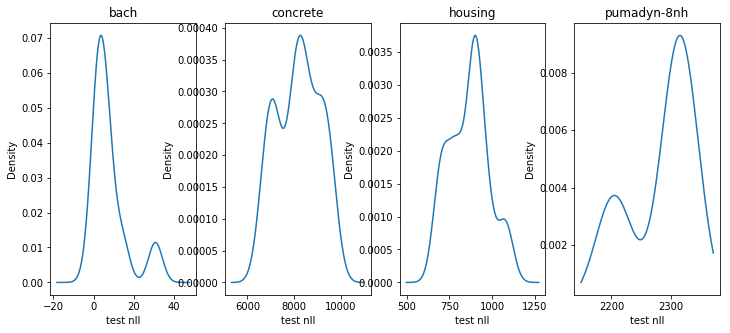

In [494]:
fig, axes = plt.subplots(ncols=4, figsize=(12,5))
for i, (dataset, gp) in enumerate(df.groupby('dataset')):
    gp['test_nll'].plot(kind='kde', ax=axes[i])
    axes[i].set_title(dataset)
    axes[i].set_xlabel('test nll')

In [543]:
df = pd.read_csv('./_partial_ablation_results.csv', index_col=0)

In [546]:
df = df.reset_index()

In [549]:
df[~pd.isnull(df['error'])]

,index,error,fold,mse,n_projections,repeat,test_nll,test_nmll,train_nll,train_nmll,train_time
440,0,"Traceback (most recent call last):\n File ""/h...",NaN,NaN,512,NaN,NaN,NaN,NaN,NaN,NaN
441,0,"Traceback (most recent call last):\n File ""/h...",NaN,NaN,1024,NaN,NaN,NaN,NaN,NaN,NaN
442,0,"Traceback (most recent call last):\n File ""/h...",NaN,NaN,2048,NaN,NaN,NaN,NaN,NaN,NaN
443,0,"Traceback (most recent call last):\n File ""/h...",NaN,NaN,4096,NaN,NaN,NaN,NaN,NaN,NaN
684,0,"Traceback (most recent call last):\n File ""/h...",NaN,NaN,4096,NaN,NaN,NaN,NaN,NaN,NaN


In [548]:
print(df[~pd.isnull(df['error'])].iloc[-1]['error'])

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 256, in rp_ablation
    dataset, split, cv, repeats=inner_repeats)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 109, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 226, in train_rp_gp
    patience=patience)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 52, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/adam.py", line 58, in step
    loss = closure()
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 50, in closure
    loss.backward()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/tensor.py", line 102, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "/home/ian/min

In [550]:
df

,index,error,fold,mse,n_projections,repeat,test_nll,test_nmll,train_nll,train_nmll,train_time
0,0,NaN,0.0,0.486855,1,0.0,24.069698,1.203484,261.778412,1.454324,0.662972
1,1,NaN,0.0,0.527890,1,1.0,23.196873,1.160030,248.519241,1.380614,0.576021
2,2,NaN,1.0,0.411384,1,0.0,22.703733,1.135183,263.102417,1.461680,0.705728
3,3,NaN,1.0,0.410259,1,1.0,22.812260,1.140615,262.532196,1.458512,0.492423
4,4,NaN,2.0,0.890565,1,0.0,27.352665,1.367627,254.533264,1.414092,0.648426
5,5,NaN,2.0,0.674492,1,1.0,25.650726,1.282536,258.448120,1.435823,0.515353
6,6,NaN,3.0,3.598660,1,0.0,69.651253,3.482563,224.592819,1.247738,0.406367
7,7,NaN,3.0,3.667796,1,1.0,82.452293,4.122632,227.409195,1.263384,0.384980
8,8,NaN,4.0,0.504163,1,0.0,24.056507,1.202825,258.057495,1.433652,0.667018
9,9,NaN,4.0,0.503880,1,1.0,23.386456,1.169323,262.110901,1.456172,0.585067


In [506]:
df.iloc[np.arange(0, 664, step=20)]

,index,error,fold,mse,n_projections,repeat,test_nll,test_nmll,train_nll,train_nmll,train_time
0,0,NaN,0.0,0.486855,1,0.0,24.069698,1.203484,261.778412,1.454324,0.662972
20,0,NaN,0.0,0.397469,2,0.0,22.428295,1.122100,246.106522,1.367243,0.645539
40,0,NaN,0.0,0.158680,4,0.0,10.724103,0.530556,94.036537,0.520256,0.693838
60,0,NaN,0.0,0.204252,8,0.0,11.980025,0.600485,80.732178,0.454219,0.948707
80,0,NaN,0.0,0.088827,16,0.0,4.687931,0.227642,-39.321976,-0.221840,1.058221
100,0,NaN,0.0,0.076476,32,0.0,5.979223,0.316861,-52.879028,-0.284290,1.132384
120,0,NaN,0.0,0.055167,64,0.0,1.596035,0.055423,-62.916428,-0.358086,1.372175
140,0,NaN,0.0,0.049707,128,0.0,0.957937,0.048633,-56.815567,-0.326975,2.204242
160,0,NaN,0.0,0.735402,256,0.0,34.793686,1.739684,-103.460632,-0.574781,1.124098
180,0,NaN,0.0,0.735402,512,0.0,34.793686,1.739684,-103.460632,-0.574781,1.961373


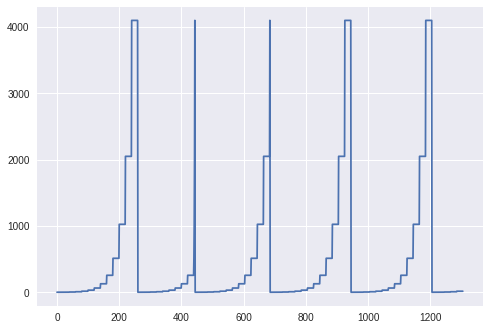

In [551]:
df['n_projections'].plot()

In [552]:
df.loc[0:259, 'dataset'] = 'bach'

In [553]:
df.loc[260:443, 'dataset'] = 'concrete'

In [564]:
df.loc[444:684, 'dataset'] = 'housing'

In [565]:
df.loc[685:944, 'dataset'] = 'servo'

In [566]:
df.loc[945:1204, 'dataset'] = 'bach'
df.loc[1205:, 'dataset'] = 'concrete'

In [567]:
plt.style.use('seaborn')

In [571]:
bach_ard = pd.read_csv('./ard_bach_results.csv')

In [580]:
bach_ard['test_nll'].mean()

5.626373147964477

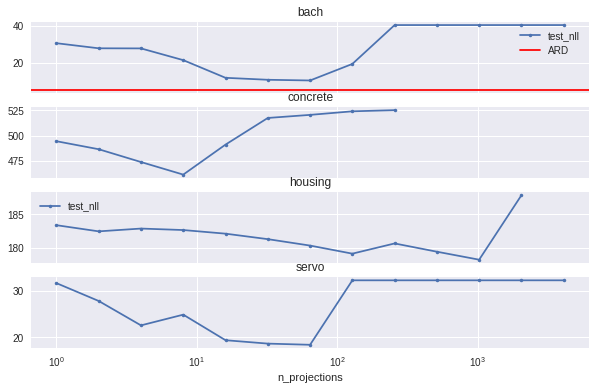

In [582]:
tmp = df.groupby(['dataset', 'n_projections'])['test_nll'].mean()
fig, ax = plt.subplots(4, sharex=True, figsize=(10,6))
tmp.loc['bach'].plot(ax=ax[0], logx=True, marker='.')
ax[0].axhline(bach_ard['test_nll'].mean(), label='ARD', color='r', )
ax[0].legend()
ax[0].set_title('bach')
tmp.loc['concrete'].plot(ax=ax[1], marker='.')
ax[1].set_title('concrete')
tmp.loc['housing'].plot(ax=ax[2], marker='.')
# ax[2].axhline(159, color='r', label='ARD')
ax[2].legend()
ax[2].set_title('housing')
tmp.loc['servo'].plot(ax=ax[3], marker='.')
ax[3].set_title('servo')
plt.show()


In [71]:
from gpytorch.kernels import AdditiveKernel, RBFKernel, AdditiveStructureKernel

In [20]:
import torch
import numpy as np

In [72]:
AdditiveStructureKernel?

In [46]:
covar_module = RBFKernel(active_dims=torch.tensor([0])) + RBFKernel(active_dims=torch.tensor([1]))
x1 = torch.randn(50, 2)
additive_kernel_matrix = covar_module(x1)

In [78]:
RBFKernel()(x1.index_select(-1, torch.tensor([0]))).evaluate()[0,:]

tensor([1.0000e+00, 1.2974e-01, 6.1584e-02, 2.9683e-01, 7.3305e-01, 9.0773e-01,
        6.5709e-01, 4.5333e-01, 5.0640e-02, 3.1225e-06, 7.6006e-01, 5.5906e-01,
        9.8568e-01, 1.1503e-01, 9.9708e-01, 1.0082e-03, 1.3331e-02, 2.2860e-03,
        6.3964e-01, 1.0194e-01, 7.1816e-02, 9.7346e-01, 2.5662e-02, 2.3526e-01,
        2.9755e-04, 7.4691e-02, 3.8728e-03, 2.8905e-01, 9.8994e-01, 5.6178e-01,
        1.2967e-03, 8.8941e-01, 2.1058e-04, 4.0759e-02, 9.9616e-01, 9.1698e-01,
        5.6877e-01, 9.2835e-01, 7.1356e-01, 3.1349e-01, 7.0825e-01, 7.1739e-01,
        5.3447e-01, 1.3908e-01, 2.8387e-02, 7.3677e-01, 1.8212e-01, 4.9728e-02,
        8.4898e-01, 6.0986e-02], grad_fn=<SliceBackward>)

In [64]:
x1

tensor([[ 0.9512, -2.1194],
        [-0.4497,  0.0408],
        [ 2.5877,  1.4482],
        [-0.1292,  0.8974],
        [ 0.4049, -1.1008],
        [ 0.6462,  0.2432],
        [ 0.3159,  1.0221],
        [ 0.0793, -1.0760],
        [-0.7419,  0.3326],
        [-2.5390,  1.3161],
        [ 0.4377, -0.6893],
        [ 0.2037, -0.0882],
        [ 1.0689,  1.8429],
        [-0.4904,  2.0375],
        [ 1.0042,  0.0210],
        [-1.6237,  0.5130],
        [-1.0857, -1.8123],
        [-1.4661,  0.0312],
        [ 0.2959,  0.7716],
        [-0.5301, -1.2391],
        [-0.6396, -0.4983],
        [ 1.1119, -0.2757],
        [-0.9249, -1.4485],
        [-0.2280, -0.3480],
        [-1.8421,  0.2441],
        [-0.6277, -0.5349],
        [-1.3590,  0.2654],
        [-0.1409,  0.4415],
        [ 1.0497,  1.3418],
        [ 0.2068,  0.1580],
        [-1.5763, -1.1919],
        [ 1.2868, -0.6950],
        [-1.9010, -1.6662],
        [-0.8024,  1.3457],
        [ 0.8904,  0.2418],
        [ 1.2398,  2

In [65]:
x1.index_select(-1, torch.tensor([1]))

tensor([[-2.1194],
        [ 0.0408],
        [ 1.4482],
        [ 0.8974],
        [-1.1008],
        [ 0.2432],
        [ 1.0221],
        [-1.0760],
        [ 0.3326],
        [ 1.3161],
        [-0.6893],
        [-0.0882],
        [ 1.8429],
        [ 2.0375],
        [ 0.0210],
        [ 0.5130],
        [-1.8123],
        [ 0.0312],
        [ 0.7716],
        [-1.2391],
        [-0.4983],
        [-0.2757],
        [-1.4485],
        [-0.3480],
        [ 0.2441],
        [-0.5349],
        [ 0.2654],
        [ 0.4415],
        [ 1.3418],
        [ 0.1580],
        [-1.1919],
        [-0.6950],
        [-1.6662],
        [ 1.3457],
        [ 0.2418],
        [ 2.4870],
        [ 0.5519],
        [-3.1600],
        [-0.5108],
        [ 1.3431],
        [-0.4858],
        [ 0.0126],
        [-0.5711],
        [-0.4311],
        [-1.0488],
        [-1.3089],
        [ 0.1262],
        [ 0.1155],
        [-2.6089],
        [ 0.3849]])

In [76]:
RBFKernel(active_dims=[1])(x1).evaluate()

RuntimeError: invalid argument 3: out of range at /opt/conda/conda-bld/pytorch-nightly-cpu_1542614797320/work/aten/src/TH/generic/THTensor.cpp:348

> /home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/gpytorch/kernels/kernel.py(313)__call__()
    311         # Select the active dimensions
    312         if self.active_dims is not None:
--> 313             x1_ = x1_.index_select(-1, self.active_dims)
    314             if x2_ is not None:
    315                 x2_ = x2_.index_select(-1, self.active_dims)

ipdb> q


In [75]:
%pdb 1
RBFKernel(active_dims=[1])(x1).evaluate()

Automatic pdb calling has been turned ON


RuntimeError: invalid argument 3: out of range at /opt/conda/conda-bld/pytorch-nightly-cpu_1542614797320/work/aten/src/TH/generic/THTensor.cpp:348

> /home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/gpytorch/kernels/kernel.py(313)__call__()
    311         # Select the active dimensions
    312         if self.active_dims is not None:
--> 313             x1_ = x1_.index_select(-1, self.active_dims)
    314             if x2_ is not None:
    315                 x2_ = x2_.index_select(-1, self.active_dims)

ipdb> q


In [49]:
with torch.no_grad():
    K = additive_kernel_matrix.evaluate()

In [57]:
x1.numpy()[0,:]

array([ 0.9511709, -2.119357 ], dtype=float32)

In [58]:
x1

tensor([[ 0.9512, -2.1194],
        [-0.4497,  0.0408],
        [ 2.5877,  1.4482],
        [-0.1292,  0.8974],
        [ 0.4049, -1.1008],
        [ 0.6462,  0.2432],
        [ 0.3159,  1.0221],
        [ 0.0793, -1.0760],
        [-0.7419,  0.3326],
        [-2.5390,  1.3161],
        [ 0.4377, -0.6893],
        [ 0.2037, -0.0882],
        [ 1.0689,  1.8429],
        [-0.4904,  2.0375],
        [ 1.0042,  0.0210],
        [-1.6237,  0.5130],
        [-1.0857, -1.8123],
        [-1.4661,  0.0312],
        [ 0.2959,  0.7716],
        [-0.5301, -1.2391],
        [-0.6396, -0.4983],
        [ 1.1119, -0.2757],
        [-0.9249, -1.4485],
        [-0.2280, -0.3480],
        [-1.8421,  0.2441],
        [-0.6277, -0.5349],
        [-1.3590,  0.2654],
        [-0.1409,  0.4415],
        [ 1.0497,  1.3418],
        [ 0.2068,  0.1580],
        [-1.5763, -1.1919],
        [ 1.2868, -0.6950],
        [-1.9010, -1.6662],
        [-0.8024,  1.3457],
        [ 0.8904,  0.2418],
        [ 1.2398,  2

In [50]:
def k(z1, z2):
    return np.exp(-1/2*(z1[0] - z2[0])**2) + np.exp(-1/2*(z1[1] - z2[1])**2)

In [51]:
def alt_k(z1, z2):
    return np.exp(-1/2*((z1 - z2)**2).sum())

In [52]:
k(x1.numpy()[0, :], x1.numpy()[0,:])

2.0

In [53]:
k(x1.numpy()[0, :], x1.numpy()[1,:])

0.4718611608136692

In [54]:
k(x1.numpy()[0, :], x1.numpy()[2,:])

0.2637801985719343

In [55]:
alt_k(x1.numpy()[0, :], x1.numpy()[1,:])

0.036358830302657526

In [167]:
type(torch.float)

torch.dtype

In [133]:
import os
def get_datasets():
    folders = os.listdir('./uci')
    folders = [f for f in folders if os.path.isdir(os.path.join('./uci', f))]
    return folders

In [135]:
import rp_experiments

In [139]:
datasets = get_datasets()
lengths = [] 
for d in datasets:
    df = rp_experiments.load_dataset(d)
    lengths.append(len(df))
idx = np.argsort(lengths)
sorted_datasets = np.array(datasets)[idx]
sorted_datasets

array(['challenger', 'fertility', 'concreteslump', 'autos', 'servo',
       'breastcancer', 'machine', 'yacht', 'autompg', 'housing', 'forest',
       'stock', 'pendulum', 'energy', 'concrete', 'solar', 'airfoil',
       'wine', 'gas', 'skillcraft', 'sml', 'parkinsons', 'pumadyn32nm',
       'pol', 'elevators', 'bike', 'kin40k', 'protein', 'tamielectric',
       'keggdirected', 'slice', 'keggundirected', '3droad', 'song',
       'buzz', 'houseelectric'], dtype='<U14')

In [143]:
df = rp_experiments.load_dataset('pumadyn32nm')
len(df)

8192

In [144]:
df = rp_experiments.load_dataset('concrete')
len(df)

1030

In [181]:
df = pd.read_csv('./unfitted_rp_compare_ablation_results.csv')

In [233]:
df = pd.read_csv('./fitted_rp_compare_ablation_results.csv')

In [234]:
df['dataset'].value_counts()

challenger       619
yacht            310
stock            294
servo            278
autos            266
pendulum         253
energy           251
machine          243
fertility        239
forest           231
housing          226
autompg          225
concreteslump    220
breastcancer     220
concrete          98
Name: dataset, dtype: int64

In [235]:
df

,Unnamed: 0,J,RP,d,dataset,error,fold,k,mse,n,repeat,test_nll,test_nmll,train_nll,train_nmll,train_time
0,0,NaN,False,2,challenger,NaN,0,NaN,0.047998,23,0.0,2.639138,0.879713,15.938777,0.802482,3.499574
1,1,NaN,False,2,challenger,NaN,1,NaN,0.631643,23,0.0,3.532650,1.177550,-44.532104,-2.226649,3.245336
2,2,NaN,False,2,challenger,"Traceback (most recent call last):\n File ""/h...",2,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,False,2,challenger,NaN,2,NaN,0.289048,23,0.0,2.907558,0.969186,12.207608,0.612222,2.725384
4,4,NaN,False,2,challenger,NaN,3,NaN,0.705085,23,0.0,3.091580,1.030527,14.126294,0.702780,2.813419
5,5,NaN,False,2,challenger,NaN,4,NaN,1.413526,23,0.0,22.358122,7.452707,-0.860893,-0.070002,1.152074
6,6,NaN,False,2,challenger,NaN,5,NaN,0.101079,23,0.0,1.880436,0.626812,15.446164,0.790465,3.671856
7,7,NaN,False,2,challenger,NaN,6,NaN,0.440934,23,0.0,2.940188,0.980063,14.799351,0.738958,2.370483
8,8,NaN,False,2,challenger,NaN,7,NaN,0.170012,23,0.0,1.681394,0.840697,16.300705,0.765093,1.808852
9,9,NaN,False,2,challenger,"Traceback (most recent call last):\n File ""/h...",8,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN,NaN


In [238]:
df_clean = df[df['error'].isnull()]

In [241]:
df_clean.columns

Index(['Unnamed: 0', 'J', 'RP', 'd', 'dataset', 'error', 'fold', 'k', 'mse',
       'n', 'repeat', 'test_nll', 'test_nmll', 'train_nll', 'train_nmll',
       'train_time'],
      dtype='object')

In [244]:
df_clean.groupby(('dataset', 'RP', 'k', 'J'))['test_nll'].count()

/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


dataset  RP    k     J   
autompg  True  1.0   1.0     10
                     2.0     10
                     3.0     10
                     5.0     10
                     8.0     10
                     13.0    10
                     20.0    10
               4.0   1.0     10
                     2.0     10
                     3.0     10
                     5.0     10
                     8.0     10
                     13.0    10
                     20.0    10
               10.0  1.0     10
                     2.0     10
                     3.0     10
                     5.0     10
                     8.0     10
                     13.0    10
                     20.0    10
autos    True  1.0   1.0     10
                     2.0     10
                     3.0     10
                     5.0     10
                     8.0     10
                     13.0    10
                     20.0     9
               4.0   1.0     10
                     2.0     10
              

In [224]:
concrete

,index,0,1,2,3,4,5,6,7,target
0,0,2.476712,-0.856472,-0.846733,-0.916319,-0.620147,0.862735,-1.217079,-0.279597,44.172039
1,1,2.476712,-0.856472,-0.846733,-0.916319,-0.620147,1.055651,-1.217079,-0.279597,26.072039
2,2,0.491187,0.795140,-0.846733,2.174405,-1.038638,-0.526262,-2.239829,3.551340,4.452039
3,3,0.491187,0.795140,-0.846733,2.174405,-1.038638,-0.526262,-2.239829,5.055221,5.232039
4,4,-0.790075,0.678079,-0.846733,0.488555,-1.038638,0.070492,0.647569,4.976069,8.482039
5,5,-0.145138,0.464818,-0.846733,2.174405,-1.038638,-0.526262,-1.291914,0.701883,11.212039
6,6,0.945704,0.244603,-0.846733,2.174405,-1.038638,-0.526262,-2.239829,5.055221,7.882039
7,7,0.945704,0.244603,-0.846733,2.174405,-1.038638,-0.526262,-2.239829,-0.279597,0.632039
8,8,-0.145138,0.464818,-0.846733,2.174405,-1.038638,-0.526262,-1.291914,-0.279597,10.032039
9,9,1.854740,-0.856472,-0.846733,2.174405,-1.038638,-0.526262,-2.239829,-0.279597,3.472039


In [200]:
df.groupby(('dataset', 'RP'))['errored_out'].mean()

/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


dataset        RP   
autompg        False    0.400000
               True     0.109524
autos          False    1.000000
               True     0.428571
breastcancer   False    0.100000
               True     0.000000
challenger     False    0.900000
               True     0.395238
concreteslump  False    0.000000
               True     0.000000
fertility      False    1.000000
               True     0.380952
forest         False    1.000000
               True     0.057143
housing        False    0.600000
               True     0.090476
machine        False    0.900000
               True     0.433333
pendulum       False    0.300000
               True     0.066667
servo          False    1.000000
               True     0.252381
stock          False    1.000000
               True     0.376190
yacht          False    1.000000
               True     0.428571
Name: errored_out, dtype: float64

In [118]:
import gp_helpers
import gpytorch
import imp
imp.reload(gp_helpers)

<module 'gp_helpers' from '/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py'>

In [80]:
k1 = RBFKernel().initialize(lengthscale=5)

In [83]:
k2 = RBFKernel().initialize(lengthscale=1)

In [85]:
k3 = gpytorch.kernels.MaternKernel()

In [125]:
import pandas as pd

In [127]:
%pdb off

Automatic pdb calling has been turned OFF


In [130]:
pd.DataFrame([[1,2,3],[4,5,6]], columns=list(range(2))+['target']).reset_index()

,index,0,1,target
0,0,1,2,3
1,1,4,5,6


In [91]:
w1 = torch.randn(3, 1)
w2 = torch.randn(3, 1)
b = torch.zeros(1)

In [92]:
w1

tensor([[1.2965],
        [0.3718],
        [1.2945]])

In [105]:
X = torch.rand(10, 3)
X

tensor([[0.4312, 0.7876, 0.2615],
        [0.1323, 0.3638, 0.8795],
        [0.5182, 0.9314, 0.4416],
        [0.5821, 0.3041, 0.2143],
        [0.7950, 0.8816, 0.2877],
        [0.0133, 0.7323, 0.1628],
        [0.6067, 0.2846, 0.8322],
        [0.1019, 0.5423, 0.3672],
        [0.0066, 0.3660, 0.7272],
        [0.7739, 0.4451, 0.2889]])

In [119]:
rp_kernel = gp_helpers.RPKernel(2, 1, 3, [k1, k2], [w1, w2], [b, b], 'sigmoid')

In [120]:
rp_kernel(X).evaluate()

/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/nn/functional.py:1174: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[2.0000, 1.9999, 1.9990, 1.9973, 1.9994, 1.9989, 1.9997, 1.9991, 1.9996,
         1.9993],
        [1.9999, 2.0000, 1.9987, 1.9978, 1.9992, 1.9989, 1.9999, 1.9993, 1.9997,
         1.9996],
        [1.9990, 1.9987, 2.0000, 1.9933, 1.9999, 1.9961, 1.9988, 1.9964, 1.9973,
         1.9971],
        [1.9973, 1.9978, 1.9933, 2.0000, 1.9945, 1.9989, 1.9975, 1.9993, 1.9990,
         1.9992],
        [1.9994, 1.9992, 1.9999, 1.9945, 2.0000, 1.9968, 1.9993, 1.9972, 1.9980,
         1.9979],
        [1.9989, 1.9989, 1.9961, 1.9989, 1.9968, 2.0000, 1.9983, 1.9999, 1.9997,
         1.9992],
        [1.9997, 1.9999, 1.9988, 1.9975, 1.9993, 1.9983, 2.0000, 1.9988, 1.9994,
         1.9995],
        [1.9991, 1.9993, 1.9964, 1.9993, 1.9972, 1.9999, 1.9988, 2.0000, 1.9999,
         1.9996],
        [1.9996, 1.9997, 1.9973, 1.9990, 1.9980, 1.9997, 1.9994, 1.9999, 2.0000,
         1.9999],
        [1.9993, 1.9996, 1.9971, 1.9992, 1.9979, 1.9992, 1.9995, 1.9996, 1.9999,
         2.0000]], grad_fn=<

In [121]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [124]:
# sanity check
def myk1(x, y):
    return np.exp(-1/2*(x - y)**2/25)
def myk2(x, y):
    return np.exp(-1/2*(x - y)**2)
def numpy_rp_kernel(x, y):
    x1 = sigmoid(w1.numpy().flatten().dot(x))
    x2 = sigmoid(w2.numpy().flatten().dot(x))
    y1 = sigmoid(w1.numpy().flatten().dot(y))
    y2 = sigmoid(w2.numpy().flatten().dot(y))
    
    kval1 = myk1(x1, y1)
    kval2 = myk2(x2, y2)
    return kval1 + kval2
xnp = X.numpy()
numpy_rp_kernel(xnp[0], xnp[2])    

1.999038034853454

In [3]:
import rp_experiments
import rp
import gp_helpers

ModuleNotFoundError: No module named 'gpytorch'

In [1]:
import imp

In [2]:
imp.reload(gp_helpers)

NameError: name 'gp_helpers' is not defined

In [319]:
gas = rp_experiments.load_dataset('gas')
X = torch.Tensor(gas.values[:, 1:-1])
Y = torch.Tensor(gas.values[:, -1])
trainX = X[:9*len(X)//10, :]
trainY = Y[:9*len(X)//10]
testX = X[9*len(X)//10:, :]
testY = Y[9*len(X)//10:]

In [321]:
rp_experiments.train_additive_rp_gp(trainX, trainY, testX, testY, ard=False, activation=None, patience=5, verbose=True, k=1, J=5)

Iter 1/100 - Loss: 0.981


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation

In [305]:
kernel = RBFKernel(ard_num_dims=X.shape[1])
kernel = gpytorch.kernels.ScaleKernel(kernel)

In [306]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = gp_helpers.ExactGPModel(trainX, trainY, likelihood, kernel)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
gp_helpers.fit_gp_model(
    model,
    likelihood,
    trainX, trainY,
    torch.optim.Adam,
    lr=0.1, 
    n_epochs=100,
    gp_mll=mll,
    verbose=True,
    patience=100
)

Iter 1/100 - Loss: 1.077
Iter 2/100 - Loss: 1.028
Iter 3/100 - Loss: 0.975
Iter 4/100 - Loss: 0.929
Iter 5/100 - Loss: 0.889
Iter 6/100 - Loss: 0.843
Iter 7/100 - Loss: 0.797
Iter 8/100 - Loss: 0.755
Iter 9/100 - Loss: 0.706
Iter 10/100 - Loss: 0.659
Iter 11/100 - Loss: 0.612
Iter 12/100 - Loss: 0.570
Iter 13/100 - Loss: 0.517
Iter 14/100 - Loss: 0.469
Iter 15/100 - Loss: 0.428
Iter 16/100 - Loss: 0.381
Iter 17/100 - Loss: 0.335
Iter 18/100 - Loss: 0.289
Iter 19/100 - Loss: 0.252
Iter 20/100 - Loss: 0.209
Iter 21/100 - Loss: 0.162
Iter 22/100 - Loss: 0.126
Iter 23/100 - Loss: 0.075
Iter 24/100 - Loss: 0.031
Iter 25/100 - Loss: -0.006
Iter 26/100 - Loss: -0.050
Iter 27/100 - Loss: -0.091
Iter 28/100 - Loss: -0.123
Iter 29/100 - Loss: -0.169
Iter 30/100 - Loss: -0.199
Iter 31/100 - Loss: -0.241
Iter 32/100 - Loss: -0.278
Iter 33/100 - Loss: -0.303
Iter 34/100 - Loss: -0.358
Iter 35/100 - Loss: -0.380
Iter 36/100 - Loss: -0.413
Iter 37/100 - Loss: -0.446
Iter 38/100 - Loss: -0.486
Iter 39

In [307]:
likelihood.noise

tensor([[0.0003]], grad_fn=<SoftplusBackward>)

In [308]:
list(model.covar_module.parameters())

[Parameter containing:
 tensor([-1.3616], requires_grad=True), Parameter containing:
 tensor([[[ 8.2300,  9.9539,  7.5712,  8.4116,  8.7345,  8.3944,  8.6121,
            9.1584,  2.6534, 10.1278,  6.9371,  7.8115,  8.3512,  6.9355,
            7.2168,  9.1016,  5.8206,  9.5956,  7.2222,  7.4172,  8.2212,
            5.5663,  7.6434,  9.2380,  5.7259,  9.5648,  7.0014,  7.1603,
            8.0579,  5.3922,  7.9859,  9.7566,  5.0349,  8.1895,  6.3009,
            6.0172,  8.0087,  2.2746,  6.9714,  7.6899,  3.1094,  3.8098,
            6.4657,  7.2874,  8.1667,  2.1612,  6.4230,  8.9385,  6.0749,
            8.3636,  7.1474,  6.7626,  7.4691,  6.1605,  7.9524,  9.4307,
            6.4509,  7.4320,  7.3175,  7.1579,  7.6668,  6.8280,  8.2536,
            8.9846,  0.1036,  9.7622,  3.5719,  7.2114,  8.1148,  5.5528,
            7.6338,  8.5782,  0.7152,  9.8478,  7.1845,  8.3517,  8.8291,
            5.1034,  7.1914,  8.8369,  6.5047,  9.7333,  7.2966,  7.5994,
            8.1453,  6.7957

In [309]:
model.covar_module.base_kernel.lengthscale

tensor([[[ 8.2303,  9.9539,  7.5717,  8.4118,  8.7346,  8.3946,  8.6123,
           9.1585,  2.7214, 10.1278,  6.9380,  7.8119,  8.3514,  6.9364,
           7.2175,  9.1017,  5.8235,  9.5957,  7.2230,  7.4178,  8.2214,
           5.5702,  7.6439,  9.2381,  5.7291,  9.5649,  7.0024,  7.1611,
           8.0582,  5.3967,  7.9863,  9.7567,  5.0414,  8.1898,  6.3027,
           6.0196,  8.0091,  2.3725,  6.9723,  7.6904,  3.1530,  3.8317,
           6.4672,  7.2881,  8.1669,  2.2702,  6.4246,  8.9386,  6.0772,
           8.3639,  7.1482,  6.7637,  7.4697,  6.1626,  7.9528,  9.4308,
           6.4525,  7.4325,  7.3181,  7.1586,  7.6672,  6.8291,  8.2539,
           8.9847,  0.7463,  9.7623,  3.5996,  7.2122,  8.1151,  5.5567,
           7.6343,  8.5784,  1.1134,  9.8479,  7.1852,  8.3519,  8.8292,
           5.1094,  7.1921,  8.8371,  6.5062,  9.7333,  7.2973,  7.5999,
           8.1456,  6.7969,  7.9144,  9.8342,  5.6666,  9.4673,  7.3353,
           7.1960,  7.9907,  6.1717,  8.0629,  9.52

In [310]:
model.covar_module.outputscale

tensor([0.2281], grad_fn=<SoftplusBackward>)

In [311]:
model(trainX).mean

tensor([0.8879, 0.8879, 0.8879,  ..., 0.8879, 0.8879, 0.8879],
       grad_fn=<SelectBackward>)

(array([   0.,    0.,    0.,    0.,    0., 2308.,    0.,    0.,    0.,
           0.]),
 array([0.3878907, 0.4878907, 0.5878907, 0.6878907, 0.7878907, 0.8878907,
        0.9878907, 1.0878907, 1.1878906, 1.2878907, 1.3878907],
       dtype=float32),
 <a list of 10 Patch objects>)

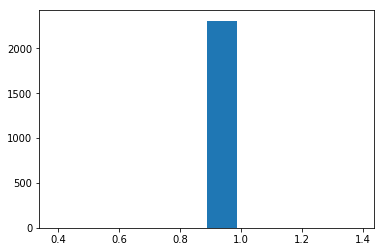

In [312]:
plt.hist(model(trainX).mean.detach().numpy())

(array([ 38.,   1., 257.,  85.,  74., 516., 431., 552., 340.,  14.]),
 array([-3.1037    , -2.5891168 , -2.0745335 , -1.5599504 , -1.0453671 ,
        -0.5307839 , -0.01620069,  0.4983825 ,  1.0129657 ,  1.5275489 ,
         2.0421321 ], dtype=float32),
 <a list of 10 Patch objects>)

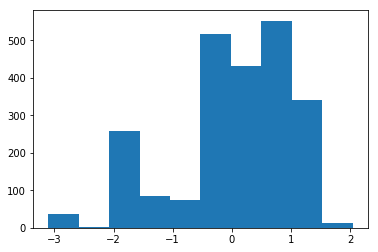

In [313]:
plt.hist(trainY.numpy())

In [2]:
import rp_experiments
dsets = ['autos', 'fertility', 'energy', 'yacht']
rp_experiments.rp_compare_ablation(fit=True, filename='./test-run-smoothed-ard.csv', dsets=dsets)

autos starting


/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py:101: RuntimeWarning: Mean of empty slice.
  ma[i] = losses[i-patience+1:i+1].mean()
/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ian/gpytorch/gpytorch/lazy/added_diag_lazy_tensor.py:63: UserWarning: NaNs encountered in preconditioner computation. Attempting to continue without preconditioning.
  "NaNs encountered in preconditioner computation. Attempting to continue without preconditioning."
/home/ian/gpytorch/gpytorch/models/exact_gp.py:190: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


2019-03-08 13:48:59.279113 - {'fold': 0, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 59.168853759765625, 'train_time': 5.175243242003489, 'train_nmll': 0.45276331901550293, 'test_nmll': 0.46097275614738464, 'train_nll': 64.74515533447266, 'test_nll': 7.375564098358154}
2019-03-08 13:49:20.619561 - {'fold': 1, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 97.55072784423828, 'train_time': 21.337001956999302, 'train_nmll': 6.297364711761475, 'test_nmll': 6.2573561668396, 'train_nll': 900.5231323242188, 'test_nll': 100.1176986694336}
2019-03-08 13:49:29.569992 - {'fold': 2, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 337442594881536.0, 'train_time': 8.946739618986612, 'train_nmll': 0.45276331901550293, 'test_nmll': 0.46097275614738464, 'train_nll': 64.74515533447266, 'test_nll': 7.375564098358154}
2019-03-08 13:49:50.873953 - {'fold': 3, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 152.59066772460938, 'train_time': 21.300463017978473, 'train_nmll': 7.5755085945129395, 'test_nmll': 7.860793113708496, 'train_nll':

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 268, in train_SE_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariate_normal.

2019-03-08 13:52:13.092653 - {'fold': 7, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 65183.1171875, 'train_time': 7.6967540370242205, 'train_nmll': 0.45276331901550293, 'test_nmll': 0.46097275614738464, 'train_nll': 64.74515533447266, 'test_nll': 7.375564098358154}
2019-03-08 13:52:21.565458 - {'fold': 8, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 10160948903936.0, 'train_time': 8.468426944979, 'train_nmll': 0.45276331901550293, 'test_nmll': 0.46097275614738464, 'train_nll': 64.74515533447266, 'test_nll': 7.375564098358154}
2019-03-08 13:53:19.457751 - {'fold': 9, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 96782312.0, 'train_time': 57.88807578399428, 'train_nmll': 0.4527634382247925, 'test_nmll': 0.4636884331703186, 'train_nll': 65.19793701171875, 'test_nll': 6.955326557159424}
2019-03-08 13:53:32.227513 - {'fold': 0, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.17757460474967957, 'train_time': 12.742602529004216, 'train_nmll': 0.9197594523429871, 'test_nmll': 0.6742397546768188, 'train_nll': 131.52569

/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py:530: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([df, result])


2019-03-08 13:55:01.650493 - {'fold': 0, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.2893752455711365, 'train_time': 7.599420998012647, 'train_nmll': 1.0444300174713135, 'test_nmll': 0.869263768196106, 'train_nll': 149.3863067626953, 'test_nll': 13.908226013183594}
2019-03-08 13:55:10.702180 - {'fold': 1, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.44297242164611816, 'train_time': 9.047850544011453, 'train_nmll': 0.8842072486877441, 'test_nmll': 1.0046026706695557, 'train_nll': 126.34515380859375, 'test_nll': 16.07362937927246}
2019-03-08 13:55:16.490737 - {'fold': 2, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.2851460576057434, 'train_time': 5.784824731003027, 'train_nmll': 0.9374583959579468, 'test_nmll': 0.8332677483558655, 'train_nll': 134.6587677001953, 'test_nll': 13.332265853881836}
2019-03-08 13:55:25.393499 - {'fold': 3, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.24735482037067413, 'train_time': 8.89884575799806, 'train_nmll': 0.8447364568710327, 'test_nmll': 0.7425084710121155, 'train_n

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

2019-03-08 13:55:44.149857 - {'fold': 5, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.418037086725235, 'train_time': 9.149201816995628, 'train_nmll': 1.038954734802246, 'test_nmll': 0.9931157827377319, 'train_nll': 148.56044006347656, 'test_nll': 15.889838218688965}
2019-03-08 13:55:48.977123 - {'fold': 6, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 1044923416576.0, 'train_time': 4.823512117989594, 'train_nmll': 0.45276331901550293, 'test_nmll': 0.46097275614738464, 'train_nll': 64.74515533447266, 'test_nll': 7.375564098358154}
2019-03-08 13:55:53.017091 - {'fold': 7, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 1825173504.0, 'train_time': 4.0360774580040015, 'train_nmll': 0.45276331901550293, 'test_nmll': 0.46097275614738464, 'train_nll': 64.74515533447266, 'test_nll': 7.375564098358154}
2019-03-08 13:56:07.727273 - {'fold': 8, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.6311161518096924, 'train_time': 14.706509137002286, 'train_nmll': 0.9744921922683716, 'test_nmll': 1.2566074132919312, 'train_nll': 1

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

2019-03-08 13:59:56.647312 - {'fold': 7, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.7059181332588196, 'train_time': 10.085808331001317, 'train_nmll': 0.8036907911300659, 'test_nmll': 1.2166162729263306, 'train_nll': 114.5573959350586, 'test_nll': 19.466045379638672}
2019-03-08 14:00:06.724674 - {'fold': 8, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.6068747639656067, 'train_time': 10.073570945998654, 'train_nmll': 0.575423002243042, 'test_nmll': 1.3992482423782349, 'train_nll': 81.89657592773438, 'test_nll': 22.387840270996094}
2019-03-08 14:00:16.621874 - {'fold': 9, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.5867995023727417, 'train_time': 9.89345107099507, 'train_nmll': 0.994683563709259, 'test_nmll': 1.1514966487884521, 'train_nll': 143.43167114257812, 'test_nll': 17.272449493408203}
2019-03-08 14:00:27.780506 - {'fold': 0, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.12127098441123962, 'train_time': 11.137226378021296, 'train_nmll': 0.17314137518405914, 'test_nmll': 0.3609575629234314, 'trai

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

2019-03-08 14:01:13.166751 - {'fold': 4, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.324707567691803, 'train_time': 10.51249680199544, 'train_nmll': 0.763055145740509, 'test_nmll': 0.8472974300384521, 'train_nll': 107.98573303222656, 'test_nll': 13.560449600219727}
2019-03-08 14:01:22.593050 - {'fold': 5, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.12283086031675339, 'train_time': 9.420951772015542, 'train_nmll': 0.4151480197906494, 'test_nmll': 0.4495130181312561, 'train_nll': 59.67192840576172, 'test_nll': 7.186639785766602}
2019-03-08 14:01:34.346209 - {'fold': 6, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.15204930305480957, 'train_time': 11.749468885012902, 'train_nmll': 0.49094924330711365, 'test_nmll': 0.496702641248703, 'train_nll': 69.74943542480469, 'test_nll': 7.947028636932373}
2019-03-08 14:01:48.013636 - {'fold': 7, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.3596118986606598, 'train_time': 13.663904841989279, 'train_nmll': 0.49136364459991455, 'test_nmll': 0.9203458428382874, 'train

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

2019-03-08 14:02:35.143306 - {'fold': 0, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.12151297181844711, 'train_time': 14.084500833996572, 'train_nmll': 0.13302356004714966, 'test_nmll': 0.3805065155029297, 'train_nll': 18.742813110351562, 'test_nll': 6.084962844848633}
2019-03-08 14:02:52.158143 - {'fold': 1, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.18085336685180664, 'train_time': 17.010681220010156, 'train_nmll': 0.152189239859581, 'test_nmll': 0.4192869961261749, 'train_nll': 22.589279174804688, 'test_nll': 6.71261739730835}
2019-03-08 14:03:14.458144 - {'fold': 2, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.13066893815994263, 'train_time': 22.29644237298635, 'train_nmll': 0.2108057737350464, 'test_nmll': 0.3828120827674866, 'train_nll': 28.72270965576172, 'test_nll': 6.124215126037598}
2019-03-08 14:03:35.549740 - {'fold': 3, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.255144327878952, 'train_time': 21.08795573300449, 'train_nmll': 0.03098137117922306, 'test_nmll': 0.870764970779419, 'train

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

2019-03-08 14:07:17.660449 - {'fold': 3, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.10076569020748138, 'train_time': 27.18018418000429, 'train_nmll': 0.011822894215583801, 'test_nmll': 0.2528536915779114, 'train_nll': 2.0349578857421875, 'test_nll': 4.0392045974731445}
2019-03-08 14:07:38.086243 - {'fold': 4, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.16731511056423187, 'train_time': 20.421453940012725, 'train_nmll': 0.04594848304986954, 'test_nmll': 0.6277163028717041, 'train_nll': 6.311553955078125, 'test_nll': 10.033773422241211}
2019-03-08 14:07:56.910840 - {'fold': 5, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.07429185509681702, 'train_time': 18.818723719014088, 'train_nmll': 0.046986933797597885, 'test_nmll': 0.21038538217544556, 'train_nll': 6.397125244140625, 'test_nll': 3.3709535598754883}
2019-03-08 14:08:10.084171 - {'fold': 6, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.06088205426931381, 'train_time': 13.169415623007808, 'train_nmll': 0.040060725063085556, 'test_nmll': 0.0667729973

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

2019-03-08 14:08:30.611442 - {'fold': 7, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.2911008596420288, 'train_time': 20.083921800018288, 'train_nmll': -0.05328582599759102, 'test_nmll': 0.9173120260238647, 'train_nll': -8.040878295898438, 'test_nll': 14.686849594116211}
2019-03-08 14:08:54.426800 - {'fold': 8, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.11789576709270477, 'train_time': 23.811484087986173, 'train_nmll': -0.03106614761054516, 'test_nmll': 0.3030065894126892, 'train_nll': -1.94451904296875, 'test_nll': 4.834296226501465}
2019-03-08 14:09:15.778989 - {'fold': 9, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.15582042932510376, 'train_time': 21.348608658998273, 'train_nmll': 0.0837021917104721, 'test_nmll': 0.3654387891292572, 'train_nll': 12.514190673828125, 'test_nll': 5.476931571960449}
2019-03-08 14:09:22.820978 - {'fold': 0, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.39071914553642273, 'train_time': 7.016576995025389, 'train_nmll': 0.2829347550868988, 'test_nmll': 1.0442476272583008

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

2019-03-08 14:09:52.966072 - {'fold': 3, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.7266501784324646, 'train_time': 7.416531199996825, 'train_nmll': 0.8722905516624451, 'test_nmll': 1.3158257007598877, 'train_nll': 125.94912719726562, 'test_nll': 21.053104400634766}
2019-03-08 14:09:58.765175 - {'fold': 4, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.35304903984069824, 'train_time': 5.795374790002825, 'train_nmll': 0.8423023223876953, 'test_nmll': 0.9002928733825684, 'train_nll': 121.78070068359375, 'test_nll': 14.399946212768555}
2019-03-08 14:10:08.345621 - {'fold': 5, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.18667158484458923, 'train_time': 9.573786577006103, 'train_nmll': 0.22534136474132538, 'test_nmll': 0.5282726287841797, 'train_nll': 33.09990692138672, 'test_nll': 8.404766082763672}
2019-03-08 14:10:19.938069 - {'fold': 6, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.2593492865562439, 'train_time': 11.58899836699129, 'train_nmll': 0.19392459094524384, 'test_nmll': 0.6492409110069275, 'tr

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

2019-03-08 14:12:20.608435 - {'fold': 4, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.1945161372423172, 'train_time': 9.34160316598718, 'train_nmll': -0.0903041809797287, 'test_nmll': 0.641638994216919, 'train_nll': -12.279647827148438, 'test_nll': 10.262689590454102}
2019-03-08 14:12:32.434836 - {'fold': 5, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.12187107652425766, 'train_time': 11.82284920901293, 'train_nmll': -0.06065507233142853, 'test_nmll': 0.41546106338500977, 'train_nll': -11.22613525390625, 'test_nll': 6.666135787963867}
2019-03-08 14:13:32.368798 - {'fold': 6, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.312171995639801, 'train_time': 59.930365412990795, 'train_nmll': -0.20224767923355103, 'test_nmll': 0.5178393721580505, 'train_nll': -29.865631103515625, 'test_nll': 8.370487213134766}
2019-03-08 14:13:42.718091 - {'fold': 7, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.34569960832595825, 'train_time': 10.345654984004796, 'train_nmll': -0.1514802873134613, 'test_nmll': 0.811989605426788

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

{'error': 'Traceback (most recent call last):\n  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment\n    **training_options)\n  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp\n    patience=patience, smooth=smooth)\n  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model\n    loss = optimizer_.step(closure).item()\n  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 103, in step\n    orig_loss = closure()\n  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure\n    loss = -gp_mll(output, ys)\n  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__\n    outputs = self.forward(*inputs, **kwargs)\n  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward\n    res = output.log_prob(target)\n  File "/home/ian/gpytorch/gpytorch/d

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 103, in step
    orig_loss = closure()
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariate_

2019-03-08 14:15:53.923426 - {'fold': 8, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 41505.9296875, 'train_time': 1.9586251740111038, 'train_nmll': 0.45276331901550293, 'test_nmll': 0.46097275614738464, 'train_nll': 64.74515533447266, 'test_nll': 7.375564098358154}
2019-03-08 14:16:30.215533 - {'fold': 9, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.13076968491077423, 'train_time': 36.28841728399857, 'train_nmll': -0.12709447741508484, 'test_nmll': 0.4864048957824707, 'train_nll': -19.690414428710938, 'test_nll': 7.2825846672058105}
2019-03-08 14:16:38.152286 - {'fold': 0, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.09044604003429413, 'train_time': 7.906923036993248, 'train_nmll': -0.0825367122888565, 'test_nmll': 0.3932546377182007, 'train_nll': -11.666275024414062, 'test_nll': 6.315622329711914}
2019-03-08 14:16:47.654684 - {'fold': 1, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.40585705637931824, 'train_time': 9.49640967999585, 'train_nmll': -0.055061180144548416, 'test_nmll': 0.7465199828147888, 

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

{'error': 'Traceback (most recent call last):\n  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment\n    **training_options)\n  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp\n    patience=patience, smooth=smooth)\n  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model\n    loss = optimizer_.step(closure).item()\n  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step\n    loss = float(closure())\n  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure\n    loss = -gp_mll(output, ys)\n  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__\n    outputs = self.forward(*inputs, **kwargs)\n  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward\n    res = output.log_prob(target)\n  File "/home/ian/gpytorch/gpytorch

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

2019-03-08 14:18:18.444484 - {'fold': 9, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.13661883771419525, 'train_time': 7.149603889003629, 'train_nmll': -0.13326729834079742, 'test_nmll': 0.5164383053779602, 'train_nll': -19.358551025390625, 'test_nll': 7.72872257232666}
2019-03-08 14:18:30.331524 - {'fold': 0, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.08308592438697815, 'train_time': 11.862930837000022, 'train_nmll': -0.07928808033466339, 'test_nmll': 0.36901962757110596, 'train_nll': -12.385223388671875, 'test_nll': 5.940049171447754}
2019-03-08 14:18:44.555082 - {'fold': 1, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.3801354169845581, 'train_time': 14.219874179980252, 'train_nmll': -0.060783013701438904, 'test_nmll': 0.7157980799674988, 'train_nll': -9.171951293945312, 'test_nll': 11.460224151611328}
2019-03-08 14:18:53.680670 - {'fold': 2, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.14629855751991272, 'train_time': 9.122115468984703, 'train_nmll': -0.1367320865392685, 'test_nmll': 0.4413932859

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

2019-03-08 14:20:51.510048 - {'fold': 9, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.10636666417121887, 'train_time': 14.194881809991784, 'train_nmll': -0.09115155786275864, 'test_nmll': 0.4556005597114563, 'train_nll': -13.22381591796875, 'test_nll': 6.825105667114258}
2019-03-08 14:21:09.903431 - {'fold': 0, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.10736089944839478, 'train_time': 18.368212895002216, 'train_nmll': -0.1417558640241623, 'test_nmll': 0.42060020565986633, 'train_nll': -20.408050537109375, 'test_nll': 6.7927775382995605}
2019-03-08 14:21:42.940771 - {'fold': 1, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.4208256006240845, 'train_time': 33.03380965697579, 'train_nmll': -0.08480194956064224, 'test_nmll': 0.7953730821609497, 'train_nll': -11.72943115234375, 'test_nll': 12.698384284973145}
2019-03-08 14:21:53.567960 - {'fold': 2, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.17346805334091187, 'train_time': 10.623219763016095, 'train_nmll': -0.10853256285190582, 'test_nmll': 0.490129351

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

2019-03-08 14:28:22.363067 - {'fold': 7, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.8056730031967163, 'train_time': 27.10585295999772, 'train_nmll': -0.1479204148054123, 'test_nmll': 1.33848237991333, 'train_nll': -22.092391967773438, 'test_nll': 21.387901306152344}
2019-03-08 14:28:33.838718 - {'fold': 8, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 1.0440566539764404, 'train_time': 11.4717164329777, 'train_nmll': -0.006478689610958099, 'test_nmll': 1.2990843057632446, 'train_nll': -0.598968505859375, 'test_nll': 20.785564422607422}
2019-03-08 14:28:47.854568 - {'fold': 9, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.3516008257865906, 'train_time': 14.011833450989798, 'train_nmll': -0.2589479982852936, 'test_nmll': 0.9008261561393738, 'train_nll': -36.918426513671875, 'test_nll': 13.51250171661377}
2019-03-08 14:29:01.530772 - {'fold': 0, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.2406129240989685, 'train_time': 13.6373815429979, 'train_nmll': 0.03352062404155731, 'test_nmll': 0.714123010635376, 't

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

2019-03-08 14:32:33.612221 - {'fold': 0, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.23729956150054932, 'train_time': 10.311507329024607, 'train_nmll': 0.011728459969162941, 'test_nmll': 0.706745982170105, 'train_nll': 1.6125640869140625, 'test_nll': 11.256771087646484}
2019-03-08 14:32:48.527680 - {'fold': 1, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.8799811005592346, 'train_time': 14.91170613700524, 'train_nmll': 0.0038738118018954992, 'test_nmll': 1.2625765800476074, 'train_nll': 0.5995025634765625, 'test_nll': 20.207355499267578}
2019-03-08 14:32:56.504221 - {'fold': 2, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.31762516498565674, 'train_time': 7.9730669840064365, 'train_nmll': -0.04397764429450035, 'test_nmll': 0.7613165378570557, 'train_nll': -6.6075592041015625, 'test_nll': 12.181962966918945}
2019-03-08 14:33:05.150898 - {'fold': 3, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.27200260758399963, 'train_time': 8.640040491998661, 'train_nmll': -0.030257325619459152, 'test_nmll': 0.73730510

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

2019-03-08 14:33:41.797835 - {'fold': 6, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.3035311698913574, 'train_time': 12.344826486019883, 'train_nmll': -0.06404593586921692, 'test_nmll': 0.7755491733551025, 'train_nll': -8.471343994140625, 'test_nll': 12.401782035827637}
2019-03-08 14:33:49.948563 - {'fold': 7, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.6898965835571289, 'train_time': 8.146650928014424, 'train_nmll': -0.08684747666120529, 'test_nmll': 1.2064937353134155, 'train_nll': -12.13031005859375, 'test_nll': 19.30109977722168}
2019-03-08 14:34:00.490611 - {'fold': 8, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.9898037910461426, 'train_time': 10.538494542008266, 'train_nmll': -0.03390993922948837, 'test_nmll': 1.2881741523742676, 'train_nll': -5.2034454345703125, 'test_nll': 20.58578109741211}
2019-03-08 14:34:21.606501 - {'fold': 9, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.31545260548591614, 'train_time': 21.11253996400046, 'train_nmll': -0.2058866322040558, 'test_nmll': 0.84473782777786

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

2019-03-08 14:39:11.961994 - {'fold': 8, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 1.007610559463501, 'train_time': 12.54413704900071, 'train_nmll': -0.133518785238266, 'test_nmll': 1.2724322080612183, 'train_nll': -18.7601318359375, 'test_nll': 20.329105377197266}
2019-03-08 14:39:26.962389 - {'fold': 9, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.33666521310806274, 'train_time': 14.994443010975374, 'train_nmll': 0.006609810516238213, 'test_nmll': 0.8599516749382019, 'train_nll': 0.406463623046875, 'test_nll': 12.898994445800781}
2019-03-08 14:39:50.803680 - {'fold': 0, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.23760825395584106, 'train_time': 23.813724523992278, 'train_nmll': 0.09305460751056671, 'test_nmll': 0.7170102000236511, 'train_nll': 13.613479614257812, 'test_nll': 11.556758880615234}
2019-03-08 14:40:20.623755 - {'fold': 1, 'repeat': 0, 'n': 159, 'd': 22, 'mse': 0.775691032409668, 'train_time': 29.81642229098361, 'train_nmll': -0.1887618899345398, 'test_nmll': 1.2140438556671143, '

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 268, in train_SE_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariate_normal.

2019-03-08 14:45:22.680621 - {'fold': 3, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 16491718115328.0, 'train_time': 16.734787861001678, 'train_nmll': 31590.5390625, 'test_nmll': 84850.984375, 'train_nll': 2843148.5, 'test_nll': 848509.8125}
2019-03-08 14:45:38.024605 - {'fold': 4, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.6219282150268555, 'train_time': 15.340287744009402, 'train_nmll': 0.8970413208007812, 'test_nmll': 1.2441246509552002, 'train_nll': 79.65084838867188, 'test_nll': 12.441247940063477}
2019-03-08 14:45:50.179813 - {'fold': 5, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.079095721244812, 'train_time': 12.151423428003909, 'train_nmll': 0.9457610249519348, 'test_nmll': 1.4531781673431396, 'train_nll': 84.83412170410156, 'test_nll': 14.531781196594238}
2019-03-08 14:45:58.023500 - {'fold': 6, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 9.927581787109375, 'train_time': 7.839041178987827, 'train_nmll': 7.104040622711182, 'test_nmll': 7.159770965576172, 'train_nll': 640.25830078125, 'test_nll':

/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py:502: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([df, result])


2019-03-08 14:46:59.538281 - {'fold': 0, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 20800.30078125, 'train_time': 2.6771150800050236, 'train_nmll': 0.4527634382247925, 'test_nmll': 0.4850500524044037, 'train_nll': 40.74871063232422, 'test_nll': 4.850500583648682}
2019-03-08 14:47:08.205372 - {'fold': 1, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.234758734703064, 'train_time': 8.663382529979572, 'train_nmll': 1.4009380340576172, 'test_nmll': 1.5498870611190796, 'train_nll': 126.08441162109375, 'test_nll': 15.49885368347168}
2019-03-08 14:47:15.678395 - {'fold': 2, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.0930030345916748, 'train_time': 7.469159871019656, 'train_nmll': 1.378194808959961, 'test_nmll': 1.4871351718902588, 'train_nll': 124.03754425048828, 'test_nll': 14.871349334716797}
2019-03-08 14:47:21.252678 - {'fold': 3, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.1339285373687744, 'train_time': 5.5705698219826445, 'train_nmll': 1.397795557975769, 'test_nmll': 1.495357871055603, 'train_nll': 125.8

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

2019-03-08 14:50:33.004523 - {'fold': 3, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.9635717272758484, 'train_time': 6.851173711998854, 'train_nmll': 1.2947497367858887, 'test_nmll': 1.4040790796279907, 'train_nll': 116.95860290527344, 'test_nll': 14.040788650512695}
2019-03-08 14:50:56.693688 - {'fold': 4, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.21281597018241882, 'train_time': 23.68324826200842, 'train_nmll': 1.3299086093902588, 'test_nmll': 1.0038920640945435, 'train_nll': 119.80040740966797, 'test_nll': 10.038920402526855}
2019-03-08 14:51:05.745319 - {'fold': 5, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.1366841793060303, 'train_time': 9.047942071978468, 'train_nmll': 1.2888596057891846, 'test_nmll': 1.5162943601608276, 'train_nll': 115.82136535644531, 'test_nll': 15.162944793701172}
2019-03-08 14:51:26.197319 - {'fold': 6, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.4030392169952393, 'train_time': 20.448035156005062, 'train_nmll': 1.3310960531234741, 'test_nmll': 1.6092472076416016, 'train_

2019-03-08 14:57:20.345832 - {'fold': 5, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.0258893966674805, 'train_time': 8.43485918402439, 'train_nmll': 1.173207402229309, 'test_nmll': 1.4168391227722168, 'train_nll': 105.15347290039062, 'test_nll': 14.168391227722168}
2019-03-08 14:57:41.444357 - {'fold': 6, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.1336584091186523, 'train_time': 21.09439333001501, 'train_nmll': 1.2190454006195068, 'test_nmll': 1.4866167306900024, 'train_nll': 109.19100952148438, 'test_nll': 14.866167068481445}
2019-03-08 14:57:54.340584 - {'fold': 7, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.46431487798690796, 'train_time': 12.892431886983104, 'train_nmll': 1.2407082319259644, 'test_nmll': 1.1199538707733154, 'train_nll': 111.68094635009766, 'test_nll': 11.199536323547363}
2019-03-08 14:58:07.410346 - {'fold': 8, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.624249815940857, 'train_time': 13.065088233997812, 'train_nmll': 1.2037755250930786, 'test_nmll': 1.6814771890640259, 'train_nl

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

2019-03-08 15:00:02.670652 - {'fold': 5, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.8541119694709778, 'train_time': 12.767304843990132, 'train_nmll': 1.17422616481781, 'test_nmll': 1.3443543910980225, 'train_nll': 105.53443908691406, 'test_nll': 13.443544387817383}
2019-03-08 15:00:22.059337 - {'fold': 6, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.3727688789367676, 'train_time': 19.3850865449931, 'train_nmll': 1.1805741786956787, 'test_nmll': 1.6167621612548828, 'train_nll': 106.46190643310547, 'test_nll': 16.167621612548828}
2019-03-08 15:00:31.451022 - {'fold': 7, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.7738416194915771, 'train_time': 9.387877487984952, 'train_nmll': 1.1394760608673096, 'test_nmll': 1.2686007022857666, 'train_nll': 103.52351379394531, 'test_nll': 12.686001777648926}
2019-03-08 15:00:46.762134 - {'fold': 8, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.5967137813568115, 'train_time': 15.307494794018567, 'train_nmll': 1.1988996267318726, 'test_nmll': 1.6801064014434814, 'train_nll

2019-03-08 15:04:39.911526 - {'fold': 7, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.3537965416908264, 'train_time': 7.410355692991288, 'train_nmll': 1.085411787033081, 'test_nmll': 1.0792264938354492, 'train_nll': 97.59095764160156, 'test_nll': 10.792264938354492}
2019-03-08 15:04:53.003107 - {'fold': 8, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.5312732458114624, 'train_time': 13.087610237009358, 'train_nmll': 0.9653192162513733, 'test_nmll': 1.6879860162734985, 'train_nll': 87.34309387207031, 'test_nll': 16.879859924316406}
2019-03-08 15:05:01.197171 - {'fold': 9, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.33579543232917786, 'train_time': 8.190440000995295, 'train_nmll': 1.0764073133468628, 'test_nmll': 1.0771557092666626, 'train_nll': 96.80448913574219, 'test_nll': 10.771556854248047}
2019-03-08 15:05:17.994707 - {'fold': 0, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.9805547595024109, 'train_time': 16.764017768990016, 'train_nmll': 1.0278809070587158, 'test_nmll': 1.3930208683013916, 'train_nll

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 388, in train_additive_rp_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariat

2019-03-08 15:05:40.208030 - {'fold': 2, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.3042612075805664, 'train_time': 9.584314748994075, 'train_nmll': 0.9661604166030884, 'test_nmll': 1.595992088317871, 'train_nll': 87.3468017578125, 'test_nll': 15.959920883178711}
2019-03-08 15:05:46.079889 - {'fold': 3, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.7035318613052368, 'train_time': 5.866207523999037, 'train_nmll': 0.9929393529891968, 'test_nmll': 1.2688044309616089, 'train_nll': 89.11622619628906, 'test_nll': 12.688044548034668}
2019-03-08 15:05:56.369433 - {'fold': 4, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.3965611755847931, 'train_time': 10.285818228992866, 'train_nmll': 1.002253532409668, 'test_nmll': 1.1060993671417236, 'train_nll': 90.1305160522461, 'test_nll': 11.060994148254395}
2019-03-08 15:06:03.621325 - {'fold': 5, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.9954131841659546, 'train_time': 7.248003487999085, 'train_nmll': 0.9587247967720032, 'test_nmll': 1.4175803661346436, 'train_nll': 86

2019-03-08 15:11:48.605765 - {'fold': 4, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.4645121693611145, 'train_time': 13.53104011301184, 'train_nmll': 1.0044283866882324, 'test_nmll': 1.1418852806091309, 'train_nll': 90.75833892822266, 'test_nll': 11.418852806091309}
2019-03-08 15:12:00.856924 - {'fold': 5, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.9186315536499023, 'train_time': 12.246538225008408, 'train_nmll': 0.9473071694374084, 'test_nmll': 1.3821531534194946, 'train_nll': 85.39738464355469, 'test_nll': 13.821531295776367}
2019-03-08 15:12:11.604944 - {'fold': 6, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.2714616060256958, 'train_time': 10.744213111000136, 'train_nmll': 0.9681367874145508, 'test_nmll': 1.54685378074646, 'train_nll': 87.51719665527344, 'test_nll': 15.468536376953125}
2019-03-08 15:12:22.114290 - {'fold': 7, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.4702087938785553, 'train_time': 10.505714958999306, 'train_nmll': 1.0089061260223389, 'test_nmll': 1.1279317140579224, 'train_nll'

2019-03-08 15:15:57.346449 - {'fold': 6, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.3110870122909546, 'train_time': 6.5820100720156915, 'train_nmll': 0.9364617466926575, 'test_nmll': 1.5677032470703125, 'train_nll': 84.42181396484375, 'test_nll': 15.677032470703125}
2019-03-08 15:16:02.239260 - {'fold': 7, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.4492871165275574, 'train_time': 4.8884117559937295, 'train_nmll': 1.0273045301437378, 'test_nmll': 1.1396987438201904, 'train_nll': 92.41481018066406, 'test_nll': 11.396987915039062}
2019-03-08 15:16:19.007742 - {'fold': 8, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.534727931022644, 'train_time': 16.765126939018955, 'train_nmll': 0.8192818760871887, 'test_nmll': 1.6977558135986328, 'train_nll': 74.11882019042969, 'test_nll': 16.977558135986328}
2019-03-08 15:16:34.659871 - {'fold': 9, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.36475878953933716, 'train_time': 15.648522987001343, 'train_nmll': 0.982088565826416, 'test_nmll': 1.0931121110916138, 'train_nl

2019-03-08 15:21:22.674184 - {'fold': 8, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.5242290496826172, 'train_time': 9.975181877991417, 'train_nmll': 0.9176421165466309, 'test_nmll': 1.696925401687622, 'train_nll': 81.82240295410156, 'test_nll': 16.969253540039062}
2019-03-08 15:21:35.424935 - {'fold': 9, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 0.34042757749557495, 'train_time': 12.744680536998203, 'train_nmll': 0.9778456687927246, 'test_nmll': 1.0806939601898193, 'train_nll': 87.93225860595703, 'test_nll': 10.806940078735352}
2019-03-08 15:21:47.655359 - {'fold': 0, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.324361801147461, 'train_time': 12.19336812698748, 'train_nmll': 0.8906404972076416, 'test_nmll': 1.6017539501190186, 'train_nll': 79.98597717285156, 'test_nll': 16.017539978027344}
2019-03-08 15:21:56.214725 - {'fold': 1, 'repeat': 0, 'n': 100, 'd': 7, 'mse': 1.0952155590057373, 'train_time': 8.555743672011886, 'train_nmll': 0.9813507795333862, 'test_nmll': 1.4565393924713135, 'train_nll':

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 268, in train_SE_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariate_normal.

2019-03-08 15:28:05.444375 - {'fold': 1, 'repeat': 0, 'n': 768, 'd': 6, 'mse': 1237984863059968.0, 'train_time': 124.27751278699725, 'train_nmll': 0.4527634382247925, 'test_nmll': 0.45276355743408203, 'train_nll': 312.8595275878906, 'test_nll': 34.86279296875}
2019-03-08 15:30:21.091948 - {'fold': 2, 'repeat': 0, 'n': 768, 'd': 6, 'mse': 0.2931789755821228, 'train_time': 135.64306496098288, 'train_nmll': 6170126.0, 'test_nmll': 1362.8203125, 'train_nll': 4263557632.0, 'test_nll': 104951.4375}
{'error': 'Traceback (most recent call last):\n  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment\n    **training_options)\n  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 268, in train_SE_gp\n    patience=patience, smooth=smooth)\n  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model\n    loss = optimizer_.step(closure).item()\n  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 268, in train_SE_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariate_normal.

2019-03-08 15:33:02.381483 - {'fold': 3, 'repeat': 0, 'n': 768, 'd': 6, 'mse': 0.004105998203158379, 'train_time': 155.78467581799487, 'train_nmll': -3.439941644668579, 'test_nmll': 16.673669815063477, 'train_nll': -3073.14599609375, 'test_nll': 1273.8568115234375}
{'error': 'Traceback (most recent call last):\n  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment\n    **training_options)\n  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 268, in train_SE_gp\n    patience=patience, smooth=smooth)\n  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model\n    loss = optimizer_.step(closure).item()\n  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step\n    loss = float(closure())\n  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure\n    loss = -gp_mll(output, ys)\n  File "/home/ian/gpytorch/

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 268, in train_SE_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariate_normal.

2019-03-08 15:33:51.105438 - {'fold': 4, 'repeat': 0, 'n': 768, 'd': 6, 'mse': 9702.6005859375, 'train_time': 7.179702072025975, 'train_nmll': 0.4527634382247925, 'test_nmll': 0.45276355743408203, 'train_nll': 312.8595275878906, 'test_nll': 34.86279296875}
2019-03-08 15:34:26.829548 - {'fold': 5, 'repeat': 0, 'n': 768, 'd': 6, 'mse': 3.0478029251098633, 'train_time': 35.721320689015556, 'train_nmll': 395442.65625, 'test_nmll': 16.359071731567383, 'train_nll': 273250720.0, 'test_nll': 1286.8359375}
{'error': 'Traceback (most recent call last):\n  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment\n    **training_options)\n  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 268, in train_SE_gp\n    patience=patience, smooth=smooth)\n  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model\n    loss = optimizer_.step(closure).item()\n  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/pyth

Traceback (most recent call last):
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 166, in run_experiment
    **training_options)
  File "/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py", line 268, in train_SE_gp
    patience=patience, smooth=smooth)
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 99, in fit_gp_model
    loss = optimizer_.step(closure).item()
  File "/home/ian/miniconda3/envs/GPyTorchEnv2/lib/python3.6/site-packages/torch/optim/lbfgs.py", line 213, in step
    loss = float(closure())
  File "/home/ian/Documents/Research/Scalable_GPs/gp_helpers.py", line 93, in closure
    loss = -gp_mll(output, ys)
  File "/home/ian/gpytorch/gpytorch/module.py", line 20, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/home/ian/gpytorch/gpytorch/mlls/exact_marginal_log_likelihood.py", line 28, in forward
    res = output.log_prob(target)
  File "/home/ian/gpytorch/gpytorch/distributions/multivariate_normal.

KeyboardInterrupt: 

In [4]:
import pandas as pd
df = pd.read_csv('./test-run-smoothed-ard.csv')
df = df[df['dataset'] != 'challenger']
df.loc[df['RP'] == False, ['k', 'J']] = 0
display(df.groupby(['dataset', 'RP', 'k'])['error'].count())

dataset    RP     k   
autos      False  0.0     1
           True   1.0     6
                  4.0     7
                  10.0    4
fertility  False  0.0     1
           True   1.0     2
                  4.0     1
                  10.0    0
Name: error, dtype: int64

In [12]:
import torch
import gpytorch

In [6]:
covar = torch.load('covar.pkl')

In [7]:
covar

tensor([[0.0054, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0054, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0054,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0054, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0054, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0054]])

In [10]:
(covar - torch.diag(covar.diag())).sum()

tensor(0.1853)

In [13]:
covar = gpytorch.lazify(covar)

In [15]:
root_decomp = covar.root_decomposition()

In [23]:
evl = root_decomp.root.evaluate()

In [27]:
evl.t().matmul(evl)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  1.9063e-03,  2.6259e-10,  5.7376e-12,  1.6689e-09,
         -1.9552e-08],
        [ 0.0000e+00,  2.6259e-10,  4.5801e-03,  1.3733e-10,  7.0385e-10,
         -4.8336e-09],
        [ 0.0000e+00,  5.7376e-12,  1.3733e-10,  5.4525e-03,  1.2785e-10,
         -8.3247e-10],
        [ 0.0000e+00,  1.6689e-09,  7.0385e-10,  1.2785e-10,  4.7223e-02,
          2.2299e-08],
        [ 0.0000e+00, -1.9552e-08, -4.8336e-09, -8.3247e-10,  2.2299e-08,
          1.3963e-01]])

In [29]:
gpytorch.utils.cholesky.psd_safe_cholesky(covar.evaluate())

RuntimeError: Adding jitter of 1e-06 to the diagonal did not make A p.d.

In [32]:
nr = 3
nc = 2
maxSquare = [[-1]*nc]*nr
maxSquare[0][1]

-1

In [33]:
for f in ["0111", "1101", "0111"]:
    print(f)

0111
1101
0111


In [2]:
import rp_experiments
import imp
imp.reload(rp_experiments)

<module 'rp_experiments' from '/home/ian/Documents/Research/Scalable_GPs/rp_experiments.py'>

In [14]:
options = dict(verbose=True, ard=False, activation=None,
                optimizer='adam', n_epochs=1000,
                lr=0.1, patience=20, k=1, J=10,
                smooth=True, noise_prior=True,
                ski=False, grid_ratio=10.0,)

In [15]:
rp_experiments.run_experiment(
    rp_experiments.train_additive_rp_gp,
    options, 'breastcancer', .1, cv=False
)

Iter 1/1000 - Loss: 1.582, Noise: 0.6931
Iter 2/1000 - Loss: 1.538, Noise: 0.6445
Iter 3/1000 - Loss: 1.540, Noise: 0.6795
Iter 4/1000 - Loss: 1.513, Noise: 0.6841
Iter 5/1000 - Loss: 1.507, Noise: 0.6647
Iter 6/1000 - Loss: 1.492, Noise: 0.6368
Iter 7/1000 - Loss: 1.525, Noise: 0.6270
Iter 8/1000 - Loss: 1.469, Noise: 0.6444
Iter 9/1000 - Loss: 1.516, Noise: 0.6604
Iter 10/1000 - Loss: 1.460, Noise: 0.6815
Iter 11/1000 - Loss: 1.479, Noise: 0.6964
Iter 12/1000 - Loss: 1.463, Noise: 0.7022
Iter 13/1000 - Loss: 1.483, Noise: 0.6987
Iter 14/1000 - Loss: 1.440, Noise: 0.6917
Iter 15/1000 - Loss: 1.447, Noise: 0.6794
Iter 16/1000 - Loss: 1.441, Noise: 0.6705
Iter 17/1000 - Loss: 1.435, Noise: 0.6648
Iter 18/1000 - Loss: 1.439, Noise: 0.6642
Iter 19/1000 - Loss: 1.413, Noise: 0.6729
Iter 20/1000 - Loss: 1.422, Noise: 0.6844
Iter 21/1000 - Loss: 1.423, Noise: 0.7004
Iter 22/1000 - Loss: 1.410, Noise: 0.7162
Iter 23/1000 - Loss: 1.399, Noise: 0.7263
Iter 24/1000 - Loss: 1.401, Noise: 0.7293
I

/home/ian/gpytorch/gpytorch/models/exact_gp.py:190: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


2019-03-10 22:26:45.126955 - {'fold': 0, 'repeat': 0, 'n': 194, 'd': 31, 'mse': 0.6444960236549377, 'train_time': 16.13184176100185, 'prior_train_nmll': 1.3833636045455933, 'train_nll': 219.05364990234375, 'test_nll': 24.55875015258789, 'train_mse': 0.6968062520027161}


,d,fold,mse,n,prior_train_nmll,repeat,test_nll,train_mse,train_nll,train_time
0,31,0,0.644496,194,1.383364,0,24.55875,0.696806,219.05365,16.131842


In [16]:
options = dict(verbose=True, ard=False, activation=None,
                optimizer='adam', n_epochs=1000,
                lr=0.1, patience=20, k=1, J=10,
                smooth=True, noise_prior=True,
                ski=True, grid_ratio=2.0,)

In [17]:
rp_experiments.run_experiment(
    rp_experiments.train_additive_rp_gp,
    options, 'breastcancer', .1, cv=False
)

Iter 1/1000 - Loss: 1.521, Noise: 0.6931
Iter 2/1000 - Loss: 1.510, Noise: 0.6444
Iter 3/1000 - Loss: 1.494, Noise: 0.6232
Iter 4/1000 - Loss: 1.503, Noise: 0.6244
Iter 5/1000 - Loss: 1.476, Noise: 0.6379
Iter 6/1000 - Loss: 1.477, Noise: 0.6489
Iter 7/1000 - Loss: 1.491, Noise: 0.6590
Iter 8/1000 - Loss: 1.452, Noise: 0.6767
Iter 9/1000 - Loss: 1.463, Noise: 0.6807
Iter 10/1000 - Loss: 1.435, Noise: 0.6778
Iter 11/1000 - Loss: 1.439, Noise: 0.6666
Iter 12/1000 - Loss: 1.422, Noise: 0.6522
Iter 13/1000 - Loss: 1.454, Noise: 0.6380
Iter 14/1000 - Loss: 1.443, Noise: 0.6336
Iter 15/1000 - Loss: 1.426, Noise: 0.6379
Iter 16/1000 - Loss: 1.397, Noise: 0.6480
Iter 17/1000 - Loss: 1.420, Noise: 0.6620
Iter 18/1000 - Loss: 1.394, Noise: 0.6791
Iter 19/1000 - Loss: 1.397, Noise: 0.6904
Iter 20/1000 - Loss: 1.389, Noise: 0.6972
Iter 21/1000 - Loss: 1.397, Noise: 0.6986
Iter 22/1000 - Loss: 1.386, Noise: 0.6982
Iter 23/1000 - Loss: 1.396, Noise: 0.6934
Iter 24/1000 - Loss: 1.379, Noise: 0.6896
I

,d,fold,mse,n,prior_train_nmll,repeat,test_nll,train_mse,train_nll,train_time
0,31,0,0.735154,194,1.367429,0,25.594864,0.636444,213.296265,226.667797


In [24]:
options = dict(verbose=True, ard=False, activation=None,
                optimizer='adam', n_epochs=1000,
                lr=0.1, patience=20, k=1, J=1,
                smooth=True, noise_prior=True,
                ski=True, grid_ratio=1.0,)

In [19]:
import gpytorch

In [23]:
with gpytorch.settings.fast_pred_samples(True):
    rp_experiments.run_experiment(
        rp_experiments.train_additive_rp_gp,
        options, 'pumadyn32nm', .1, cv=False
    )

Iter 1/1000 - Loss: 1.459, Noise: 0.6931
Iter 2/1000 - Loss: 1.445, Noise: 0.7444
Iter 3/1000 - Loss: 1.434, Noise: 0.7972
Iter 4/1000 - Loss: 1.427, Noise: 0.8507
Iter 5/1000 - Loss: 1.423, Noise: 0.9035
Iter 6/1000 - Loss: 1.421, Noise: 0.9542
Iter 7/1000 - Loss: 1.421, Noise: 1.0013
Iter 8/1000 - Loss: 1.421, Noise: 1.0433
Iter 9/1000 - Loss: 1.422, Noise: 1.0792
Iter 10/1000 - Loss: 1.423, Noise: 1.1082
Iter 11/1000 - Loss: 1.424, Noise: 1.1299
Iter 12/1000 - Loss: 1.425, Noise: 1.1445
Iter 13/1000 - Loss: 1.425, Noise: 1.1521
Iter 14/1000 - Loss: 1.425, Noise: 1.1534
Iter 15/1000 - Loss: 1.425, Noise: 1.1491
Iter 16/1000 - Loss: 1.424, Noise: 1.1401
Iter 17/1000 - Loss: 1.424, Noise: 1.1270
Iter 18/1000 - Loss: 1.423, Noise: 1.1108
Iter 19/1000 - Loss: 1.422, Noise: 1.0923
Iter 20/1000 - Loss: 1.421, Noise: 1.0723
Iter 21/1000 - Loss: 1.421, Noise: 1.0516
Iter 22/1000 - Loss: 1.420, Noise: 1.0310
Iter 23/1000 - Loss: 1.420, Noise: 1.0111
Iter 24/1000 - Loss: 1.420, Noise: 0.9927
I

KeyboardInterrupt: 

In [ ]:
options = dict(verbose=True, ard=False, activation=None,
                optimizer='adam', n_epochs=1000,
                lr=0.1, patience=20, k=1, J=1,
                smooth=True, noise_prior=True,
                ski=False, grid_ratio=1.0,)

In [ ]:
with gpytorch.settings.fast_pred_samples(True):
    rp_experiments.run_experiment(
        rp_experiments.train_additive_rp_gp,
        options, 'pumadyn32nm', .1, cv=False
    )

In [1]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel, GridInterpolationKernel
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial
import pandas as pd

In [2]:
import rp_experiments
import rp
import gp_helpers
import rp
import time

In [3]:
auto = rp_experiments.load_dataset('autos')

n_per_fold = int(np.ceil(len(auto)*0.1))
fold = 4

train = auto.iloc[:n_per_fold*fold]  # if fold=0, none before fold
test = auto.iloc[n_per_fold*fold:n_per_fold*(fold+1)]
train = pd.concat([train,
                   auto.iloc[n_per_fold*(fold+1):]])
trainX = torch.Tensor(train.values[:, 1:-1])
trainY = torch.Tensor(train.values[:, -1])
testX = torch.Tensor(test.values[:, 1:-1])
testY = torch.Tensor(test.values[:, -1])

# X = torch.Tensor(auto.values[:, 1:-1])

In [4]:
times = []
ns = []

In [5]:
for n in np.arange(1000, 10000, 1000):
    n = int(n)
    print(n)
    d = 1
    k = 1
    J = 1
    synthX = torch.randn(n, 1)
    synthY = torch.sin(synthX).squeeze()
    Ws = [rp.gen_rp(d, k) for i in range(J)]
    bs = [torch.zeros(1, k) for i in range(J)]
#     base_kernels = [GridInterpolationKernel(RBFKernel(), n, num_dims=k) for i in range(J)]
#     kernel = gp_helpers.RPKernel(J, k, d, base_kernels, Ws, bs, activation=None)
#     kernel = base_kernels[0]
    kernel = RBFKernel()
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    with gpytorch.settings.fast_pred_var(False):
        model = gp_helpers.ExactGPModel(synthX, synthY, likelihood, kernel)
    
    t1 = time.perf_counter()
    model.eval()
    p = model(synthX)
    t2 = time.perf_counter()
    times.append(t2-t1)
    ns.append(n)

1000


/home/ian/gpytorch/gpytorch/models/exact_gp.py:190: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


2000
3000
4000
5000
6000
7000
8000


KeyboardInterrupt: 

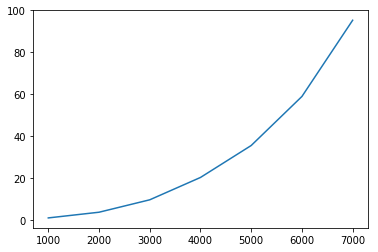

In [6]:
plt.plot(ns, times)

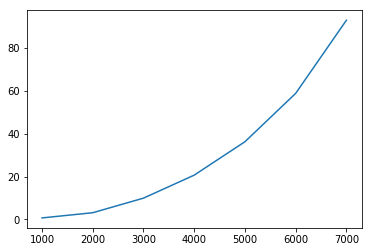

In [12]:
plt.plot(ns, times)

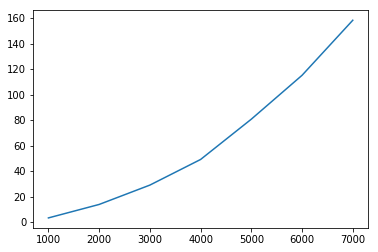

In [9]:
plt.plot(ns, times)

In [13]:
ski_ns = ns
ski_times = times

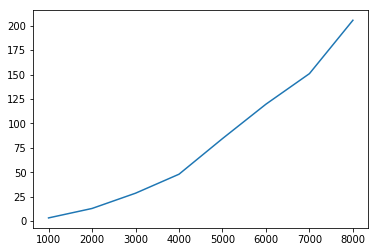

In [14]:
plt.plot(ns, times)

In [31]:
K.matmul((K+torch.eye(n)*1/100).inv_matmul(trainY))

tensor([-0.6701,  1.3693, -0.1794,  0.0087,  1.3041,  1.5798, -0.7688,  1.3515,
        -0.2587,  0.3251, -0.5411, -1.1535, -0.0922,  0.2849,  1.5458,  0.7118,
        -0.6772, -0.6183, -0.7674,  0.1365, -1.3754,  1.6055,  1.3082, -0.5172,
        -0.3615,  0.3904,  0.8537, -0.2502, -0.9713,  0.1645,  2.7172, -0.4749,
         0.9010,  0.1152, -1.0904,  0.0699, -0.2126,  1.8005,  0.9124, -0.4749,
        -0.8363,  0.0942, -0.8034, -1.0197,  0.6391, -0.2099, -0.8135, -0.5178,
         0.2022, -0.5388,  1.2630,  0.7822,  1.0631, -1.0426, -1.0070, -0.7864,
         0.5804, -0.7024,  0.1316, -0.9195,  0.8401,  1.3991, -0.9229,  0.4088,
        -0.8253, -0.2812,  1.5433, -1.0515, -0.6883, -0.8532,  1.2665, -0.2370,
        -0.7681, -0.5375, -0.7393, -0.7840,  1.3517, -0.7232,  1.2349, -0.7053,
        -0.7588, -0.5375,  0.1457,  0.2167, -1.1534, -0.2165,  0.3020,  1.3911,
         0.2302,  0.3567, -0.7529, -0.7793, -1.2651, -0.4846, -0.9547, -0.7151,
        -0.6399,  1.3853, -0.5458,  0.16

In [47]:
n = 10000
d = 1
k = 1
J = 1
Ws = [rp.gen_rp(d, k) for i in range(J)]
bs = [torch.zeros(1, k) for i in range(J)]
base_kernels = [GridInterpolationKernel(RBFKernel(), n, num_dims=k) for i in range(J)]
kernel = gp_helpers.RPKernel(J, k, d, base_kernels, Ws, bs, activation=None)
synthX = torch.randn(100, 1)
synthY = torch.sin(synthX).squeeze()

In [48]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = gp_helpers.ExactGPModel(synthX, synthY, likelihood, kernel)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
gp_helpers.fit_gp_model(
    model,
    likelihood,
    synthX, synthY,
    torch.optim.Adam,
    lr=0.1, 
    n_epochs=100,
    gp_mll=mll,
    verbose=True,
    patience=50
)

Iter 1/100 - Loss: 0.865, Noise: 0.6931
Iter 2/100 - Loss: 0.832, Noise: 0.6444
Iter 3/100 - Loss: 0.798, Noise: 0.5981
Iter 4/100 - Loss: 0.764, Noise: 0.5542


KeyboardInterrupt: 

In [50]:
model.eval()
pred = model(synthX)

/home/ian/gpytorch/gpytorch/models/exact_gp.py:190: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


In [ ]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

train_x = torch.linspace(0, 1, 1000)
train_y = torch.sin(train_x * (4 * math.pi) + torch.randn(train_x.size()) * 0.2)